In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

# 他社債務(12か月)

## 参考
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

## モジュールとCSVの読み込み

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14524874425469597422
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16531103064309397575
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA RTX A2000 Laptop GPU


In [5]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
app_br_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train_br_all-domein_12-monthes.csv')
app_br_test_origin = pd.read_csv('./home-credit-default-risk/exports/app_test_br_all-domein_12-monthes.csv')
#POS_CASH_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
#previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
#installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
#app_br_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_Loan_From_other_banks_cash-consumer-loans.csv')
#app_br_test_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_Loan_From_other_banks_cash-consumer-loans.csv')
#app_train_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_overdue_hist.csv')
#app_test_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_overdue_hist.csv')
#app_train_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_debt_credit_ratio_none.csv')
#app_test_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_debt_credit_ratio_none.csv')

app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

In [7]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
bureau_balance = bureau_balance_origin.copy()
app_br_train = app_br_train_origin.copy()
app_br_test = app_br_test_origin.copy()

In [8]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 他金融機関での借り入れ情報(bureau)前処理

In [9]:
len(app_train)

307511

In [10]:
len(app_test)

48744

In [11]:
len(app_br_train)

90055

In [12]:
len(app_br_test)

42311

In [13]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
app_train = app_train[['SK_ID_CURR','TARGET']].copy()
app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

In [14]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

In [15]:
# trainへマージ
app_train = pd.merge(app_train, app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

### br_min_credit_day_overdue

In [16]:
app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

TARGET  br_min_credit_day_overdue
TARGET                     1.000000                   0.011316
br_min_credit_day_overdue  0.011316                   1.000000

The correlation between br_min_credit_day_overdue and the TARGET is 0.0113
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


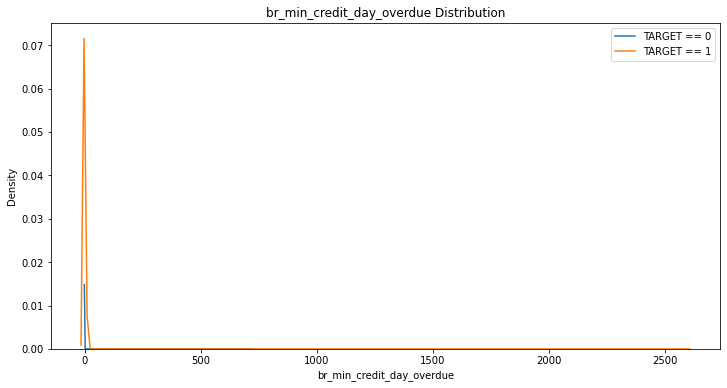

In [17]:
kde_target('br_min_credit_day_overdue', app_train)

In [18]:
## Yao-Johnson変換
#num_cols = ['br_min_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [19]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

### br_max_credit_day_overdue

In [20]:
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.0000                     0.0002
br_max_credit_day_overdue  0.0002                     1.0000

The correlation between br_max_credit_day_overdue and the TARGET is 0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


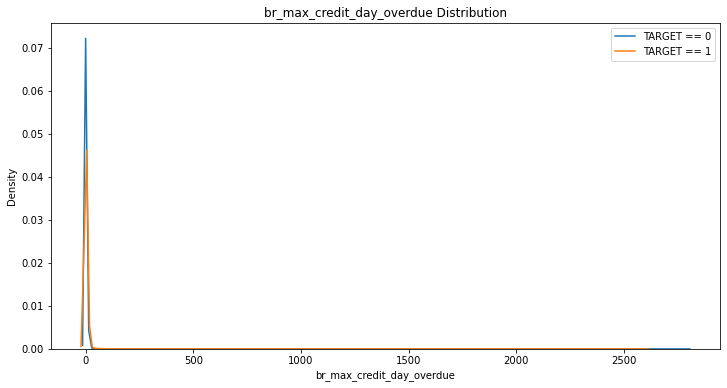

In [21]:
kde_target('br_max_credit_day_overdue', app_train)

In [22]:
## Yao-Johnson変換
num_cols = ['br_max_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [23]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                   0.034473
br_max_credit_day_overdue  0.034473                   1.000000

The correlation between br_max_credit_day_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.1069
Median value for loan that was repaid =     -0.1069


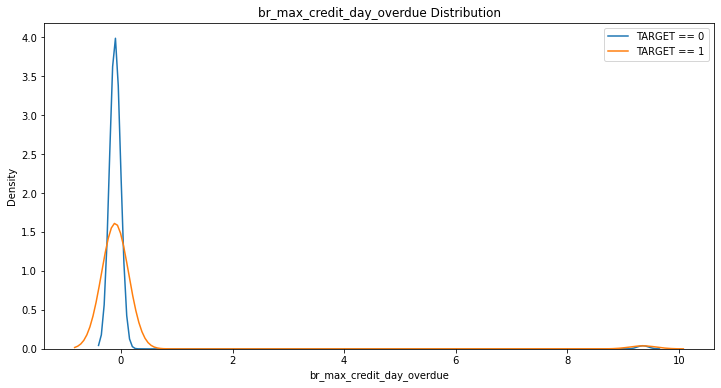

In [24]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_credit_day_overdue', app_train)

### br_sum_credit_day_overdue

In [25]:
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                  -0.001964
br_sum_credit_day_overdue -0.001964                   1.000000

The correlation between br_sum_credit_day_overdue and the TARGET is -0.0020
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


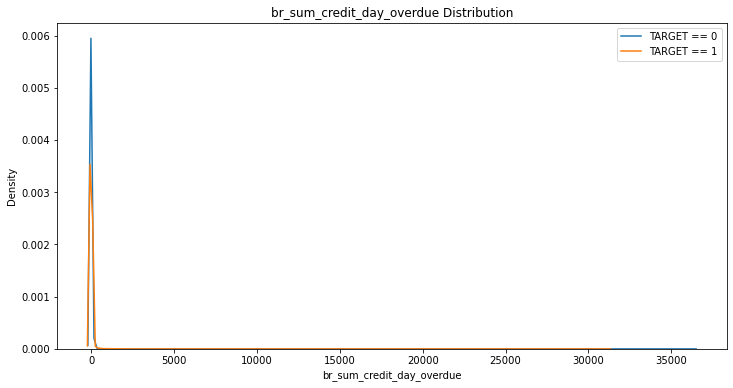

In [26]:
kde_target('br_sum_credit_day_overdue', app_train)

In [27]:
## Yao-Johnson変換
num_cols = ['br_sum_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [28]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                   0.034473
br_sum_credit_day_overdue  0.034473                   1.000000

The correlation between br_sum_credit_day_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.1069
Median value for loan that was repaid =     -0.1069


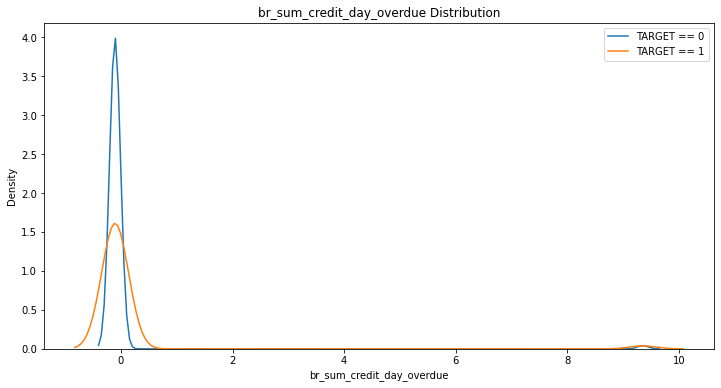

In [29]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_credit_day_overdue', app_train)

### br_avg_credit_day_overdue

In [30]:
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.002594
br_avg_credit_day_overdue  0.002594                   1.000000

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


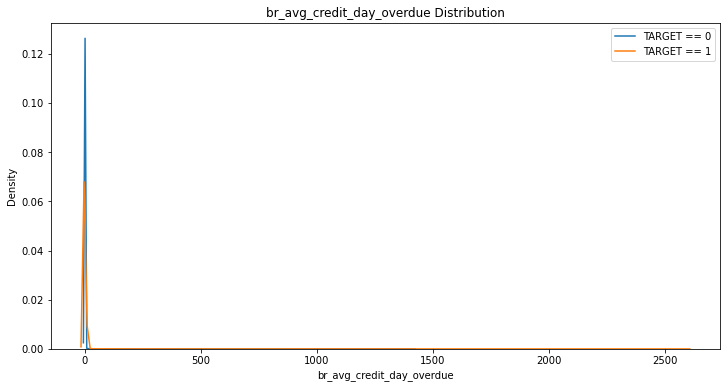

In [31]:
kde_target('br_avg_credit_day_overdue', app_train)

In [32]:
## Yao-Johnson変換
num_cols = ['br_avg_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [33]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.034491
br_avg_credit_day_overdue  0.034491                   1.000000

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.1069
Median value for loan that was repaid =     -0.1069


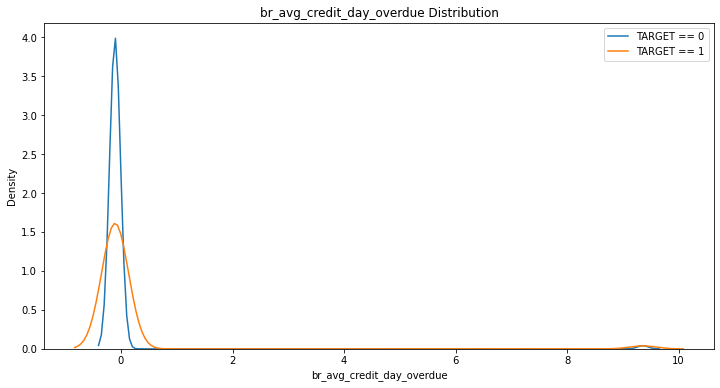

In [34]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_credit_day_overdue', app_train)

### br_cnt_credit_day_overdue

In [35]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.012242
br_cnt_credit_day_overdue -0.012242                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0122
Median value for loan that was not repaid = 35.0000
Median value for loan that was repaid =     38.0000


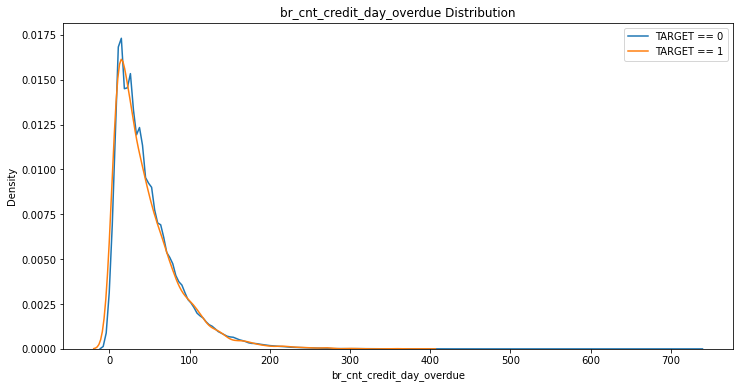

In [36]:
kde_target('br_cnt_credit_day_overdue', app_train)

In [37]:
## Yao-Johnson変換
num_cols = ['br_cnt_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [38]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.022992
br_cnt_credit_day_overdue -0.022992                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0230
Median value for loan that was not repaid = -0.0478
Median value for loan that was repaid =     0.0477


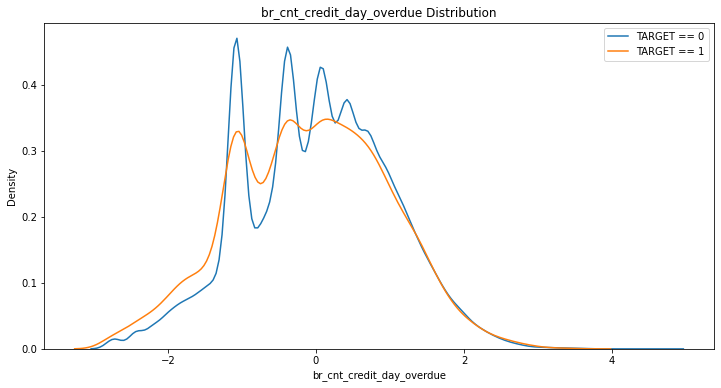

In [39]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_credit_day_overdue', app_train)

### br_stddev_credit_day_overdue

In [40]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                     -0.003045
br_stddev_credit_day_overdue -0.003045                      1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0030
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


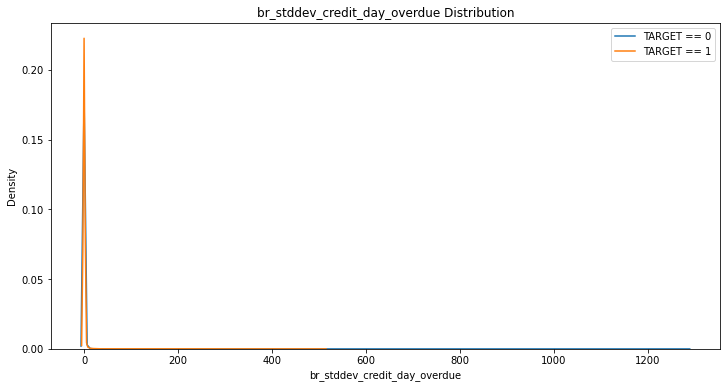

In [41]:
kde_target('br_stddev_credit_day_overdue', app_train)

In [42]:
## Yao-Johnson変換
num_cols = ['br_stddev_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [43]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                      0.033017
br_stddev_credit_day_overdue  0.033017                      1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is 0.0330
Median value for loan that was not repaid = -0.1037
Median value for loan that was repaid =     -0.1037


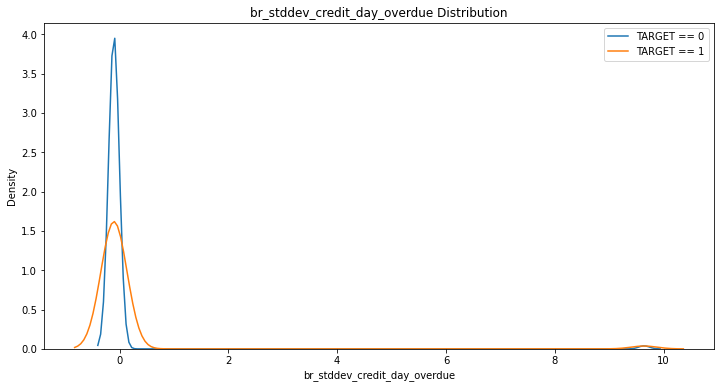

In [44]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_credit_day_overdue', app_train)

### br_stddev_pop_credit_day_overdue

In [45]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                         -0.003045
br_stddev_pop_credit_day_overdue -0.003045                          1.000000

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0030
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


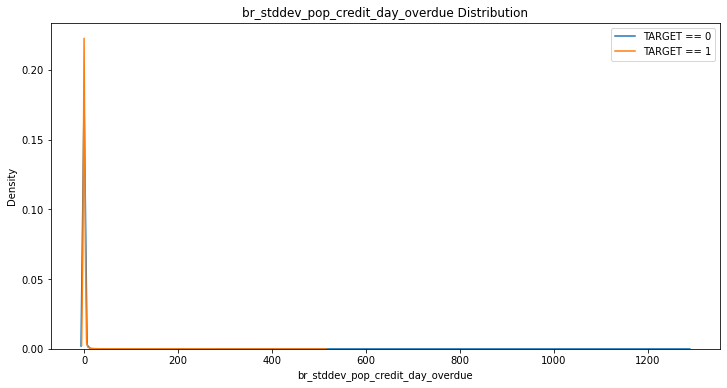

In [46]:
kde_target('br_stddev_pop_credit_day_overdue', app_train)

In [47]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [48]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                          0.033017
br_stddev_pop_credit_day_overdue  0.033017                          1.000000

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is 0.0330
Median value for loan that was not repaid = -0.1037
Median value for loan that was repaid =     -0.1037


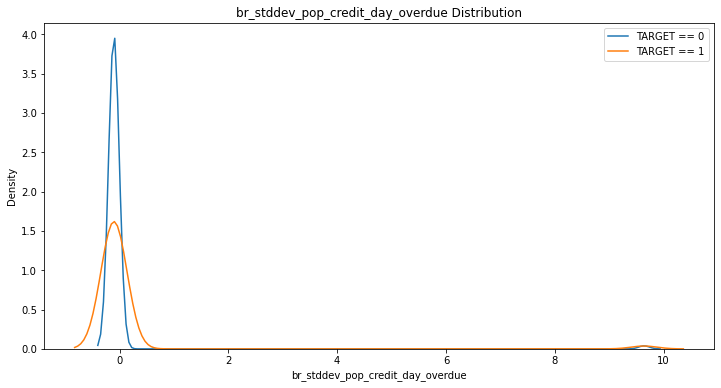

In [49]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_credit_day_overdue', app_train)

### br_var_pop_credit_day_overdue

In [50]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.005206
br_var_pop_credit_day_overdue -0.005206                       1.000000

The correlation between br_var_pop_credit_day_overdue and the TARGET is -0.0052
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


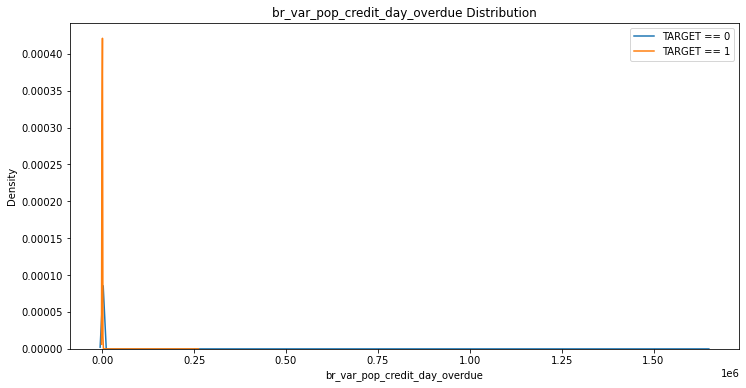

In [51]:
kde_target('br_var_pop_credit_day_overdue', app_train)

In [52]:
## Yao-Johnson変換
num_cols = ['br_var_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [53]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                       0.033037
br_var_pop_credit_day_overdue  0.033037                       1.000000

The correlation between br_var_pop_credit_day_overdue and the TARGET is 0.0330
Median value for loan that was not repaid = -0.1037
Median value for loan that was repaid =     -0.1037


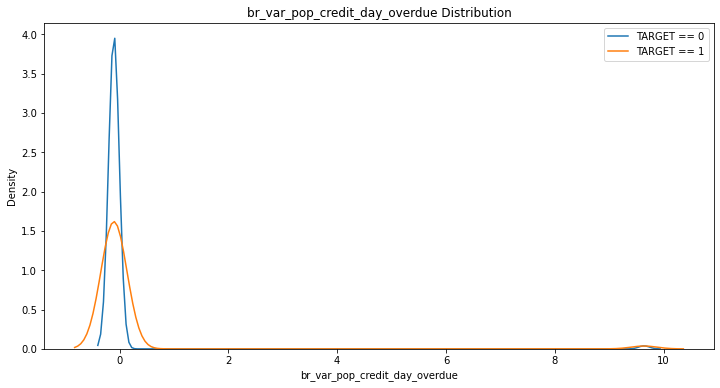

In [54]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_credit_day_overdue', app_train)

### br_var_samp_credit_day_overdue

In [55]:
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                       -0.005205
br_var_samp_credit_day_overdue -0.005205                        1.000000

The correlation between br_var_samp_credit_day_overdue and the TARGET is -0.0052
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


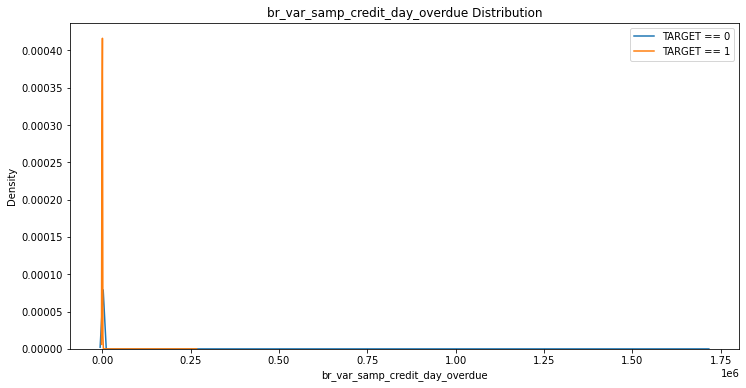

In [56]:
kde_target('br_var_samp_credit_day_overdue', app_train)

In [57]:
## Yao-Johnson変換
num_cols = ['br_var_samp_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [58]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                        0.033037
br_var_samp_credit_day_overdue  0.033037                        1.000000

The correlation between br_var_samp_credit_day_overdue and the TARGET is 0.0330
Median value for loan that was not repaid = -0.1037
Median value for loan that was repaid =     -0.1037


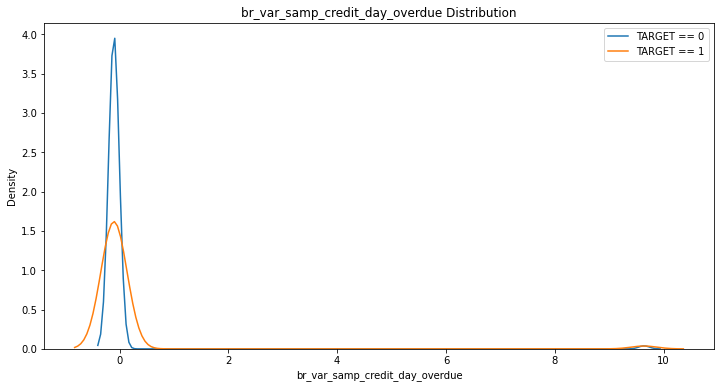

In [59]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_credit_day_overdue', app_train)

### br_variance_pop_credit_day_overdue

In [60]:
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue -0.005206   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                       -0.005206  
br_variance_pop_credit_day_overdue                            1.000000

The correlation between br_variance_pop_credit_day_overdue and the TARGET is -0.0052
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


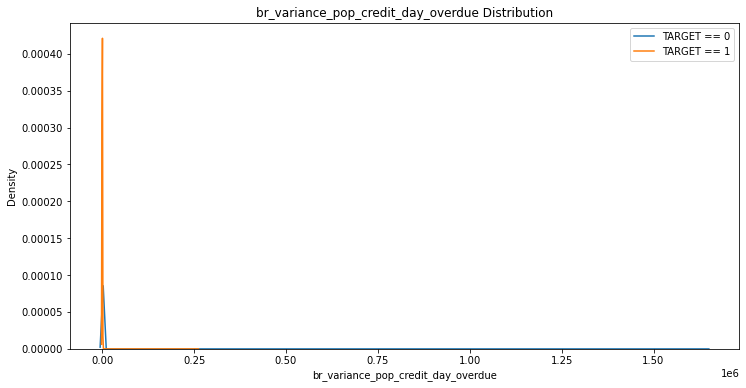

In [61]:
kde_target('br_variance_pop_credit_day_overdue', app_train)

In [62]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [63]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue  0.033037   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                        0.033037  
br_variance_pop_credit_day_overdue                            1.000000

The correlation between br_variance_pop_credit_day_overdue and the TARGET is 0.0330
Median value for loan that was not repaid = -0.1037
Median value for loan that was repaid =     -0.1037


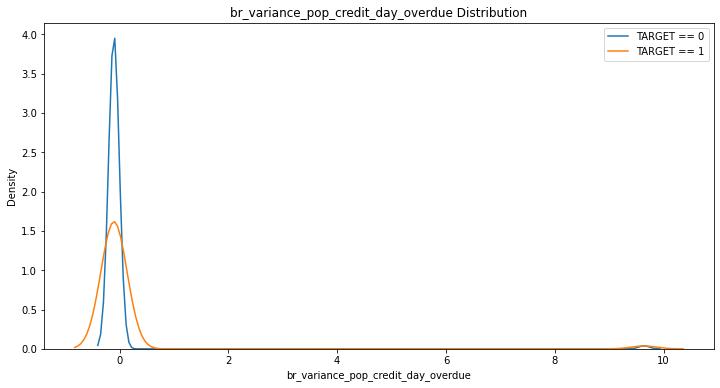

In [64]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_credit_day_overdue', app_train)

### br_min_days_credit_enddate

In [65]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.033229
br_min_days_credit_enddate  0.033229                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0332
Median value for loan that was not repaid = -485.0000
Median value for loan that was repaid =     -733.0000


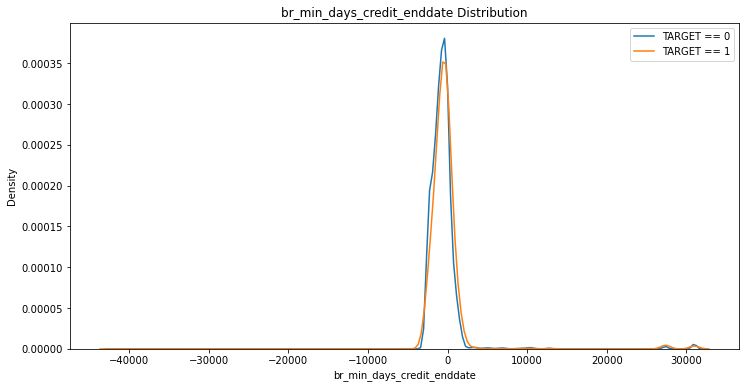

In [66]:
kde_target('br_min_days_credit_enddate', app_train)

In [67]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [68]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.053741
br_min_days_credit_enddate  0.053741                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0537
Median value for loan that was not repaid = 0.3713
Median value for loan that was repaid =     0.1339


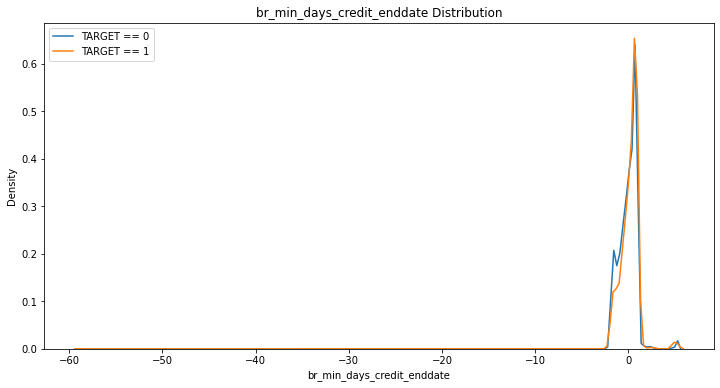

In [69]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_enddate', app_train)

### br_max_days_credit_enddate

In [70]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.038727
br_max_days_credit_enddate  0.038727                    1.000000

The correlation between br_max_days_credit_enddate and the TARGET is 0.0387
Median value for loan that was not repaid = 1086.0000
Median value for loan that was repaid =     899.0000


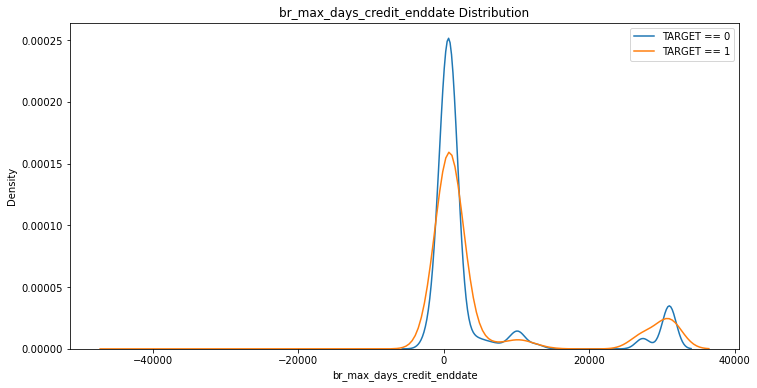

In [71]:
kde_target('br_max_days_credit_enddate', app_train)

In [72]:
## Yao-Johnson変換
#num_cols = ['br_max_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_max_days_credit_enddate'] = pt.transform(app_test[num_cols])


In [73]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

In [74]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_days_credit_enddate', app_train)

### br_sum_days_credit_enddate

In [75]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.00000                     0.04043
br_sum_days_credit_enddate  0.04043                     1.00000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0404
Median value for loan that was not repaid = 4621.0000
Median value for loan that was repaid =     418.5000


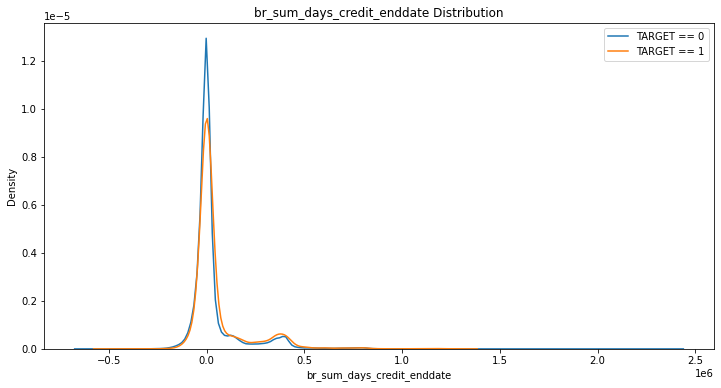

In [76]:
kde_target('br_sum_days_credit_enddate', app_train)

In [77]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [78]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.052367
br_sum_days_credit_enddate  0.052367                    1.000000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0524
Median value for loan that was not repaid = 0.0676
Median value for loan that was repaid =     0.0384


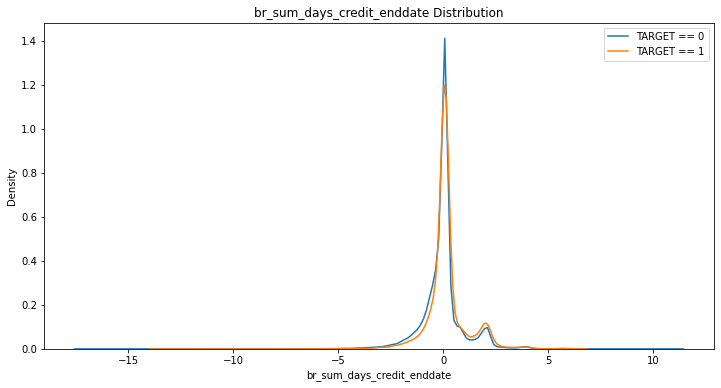

In [79]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_enddate', app_train)

### br_avg_days_credit_enddate

In [80]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.042788
br_avg_days_credit_enddate  0.042788                    1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0428
Median value for loan that was not repaid = 245.1081
Median value for loan that was repaid =     29.4412


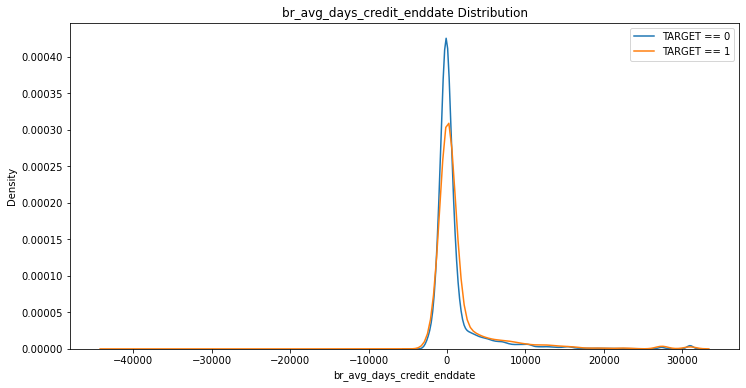

In [81]:
kde_target('br_avg_days_credit_enddate', app_train)

In [82]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [83]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.051396
br_avg_days_credit_enddate  0.051396                    1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0514
Median value for loan that was not repaid = 0.1525
Median value for loan that was repaid =     0.0901


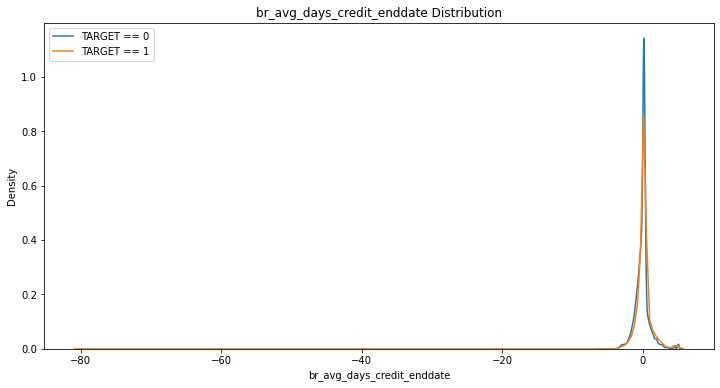

In [84]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_enddate', app_train)

### br_cnt_days_credit_enddate

In [85]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.018419
br_cnt_days_credit_enddate -0.018419                    1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0184
Median value for loan that was not repaid = 31.0000
Median value for loan that was repaid =     35.0000


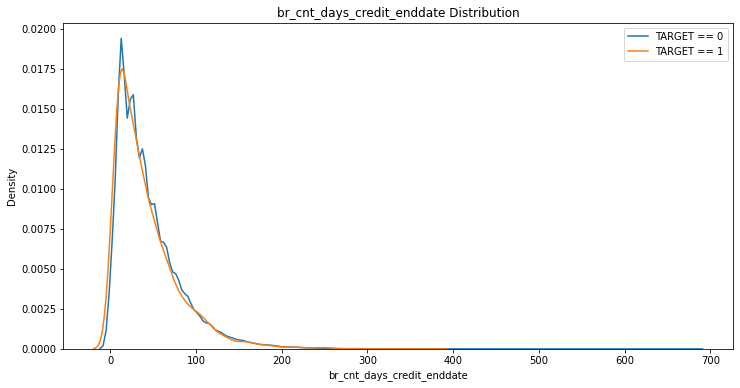

In [86]:
kde_target('br_cnt_days_credit_enddate', app_train)

In [87]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_enddate'] = pt.transform(app_test[num_cols])


In [88]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.028974
br_cnt_days_credit_enddate -0.028974                    1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0290
Median value for loan that was not repaid = -0.1131
Median value for loan that was repaid =     0.0213


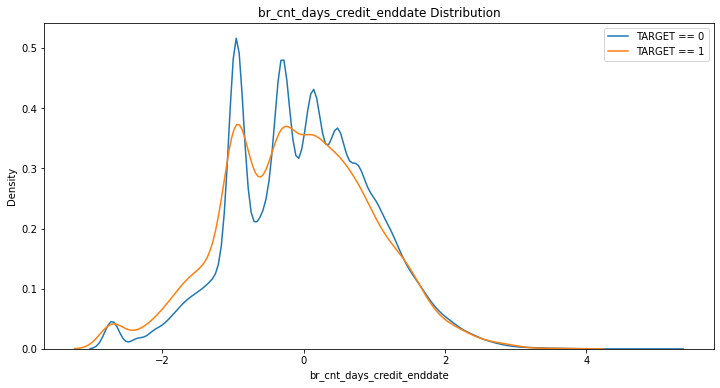

In [89]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_enddate', app_train)

### br_stddev_days_credit_enddate

In [90]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.027884
br_stddev_days_credit_enddate  0.027884                       1.000000

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0279
Median value for loan that was not repaid = 591.7227
Median value for loan that was repaid =     600.4949


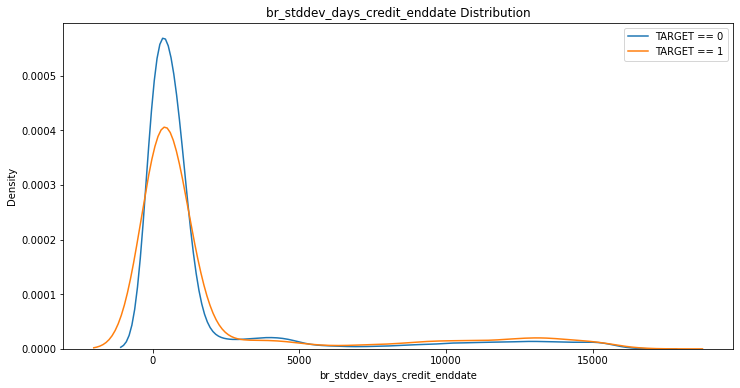

In [91]:
kde_target('br_stddev_days_credit_enddate', app_train)

In [92]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [93]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

In [94]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_days_credit_enddate', app_train)

### br_stddev_pop_days_credit_enddate

In [95]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.027884
br_stddev_pop_days_credit_enddate  0.027884                           1.000000

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0279
Median value for loan that was not repaid = 591.7227
Median value for loan that was repaid =     600.4949


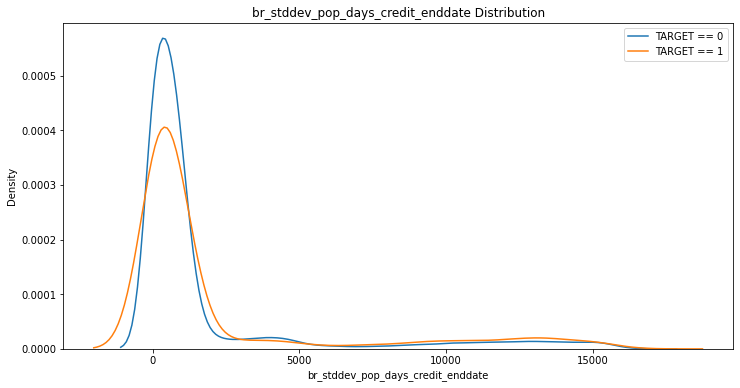

In [96]:
kde_target('br_stddev_pop_days_credit_enddate', app_train)

In [97]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [98]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

In [99]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_days_credit_enddate', app_train)

### br_var_pop_days_credit_enddate

In [100]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.029151
br_var_pop_days_credit_enddate  0.029151                        1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0292
Median value for loan that was not repaid = 350135.7039
Median value for loan that was repaid =     360594.1597


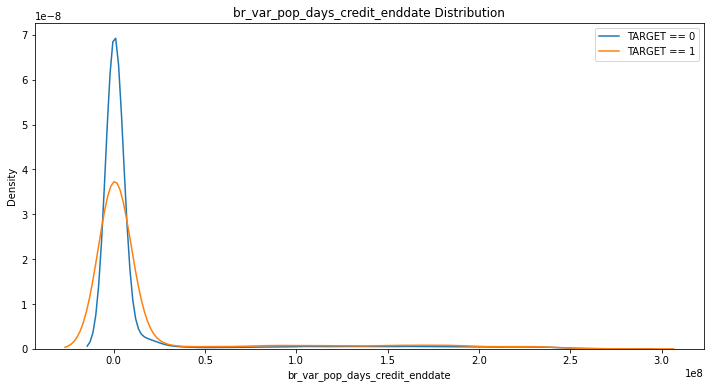

In [101]:
kde_target('br_var_pop_days_credit_enddate', app_train)

In [102]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [103]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.003202
br_var_pop_days_credit_enddate  0.003202                        1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0032
Median value for loan that was not repaid = 0.1606
Median value for loan that was repaid =     0.1670


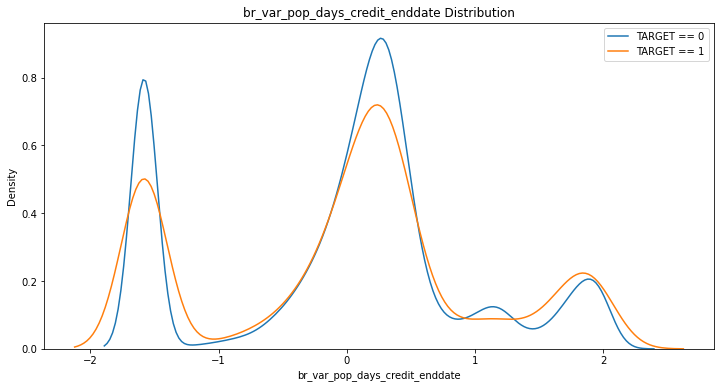

In [104]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_enddate', app_train)

### br_var_samp_days_credit_enddate

In [105]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.029774
br_var_samp_days_credit_enddate  0.029774                         1.000000

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0298
Median value for loan that was not repaid = 362313.8095
Median value for loan that was repaid =     370999.4474


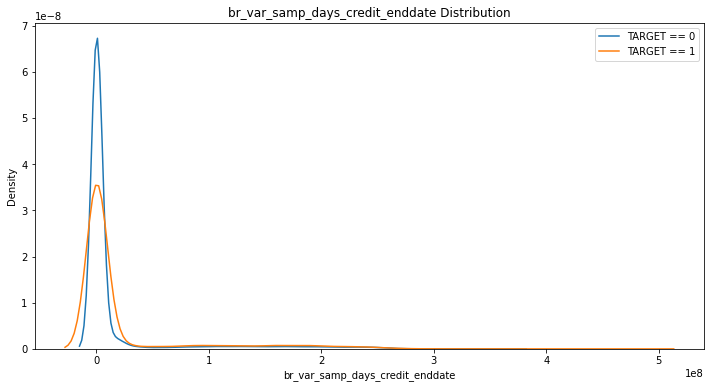

In [106]:
kde_target('br_var_samp_days_credit_enddate', app_train)

In [107]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [108]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

In [109]:

## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_days_credit_enddate', app_train)

### br_variance_pop_days_credit_enddate

In [110]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_days_credit_enddate  0.029151   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                          0.029151  
br_variance_pop_days_credit_enddate                             1.000000

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0292
Median value for loan that was not repaid = 350135.7039
Median value for loan that was repaid =     360594.1597


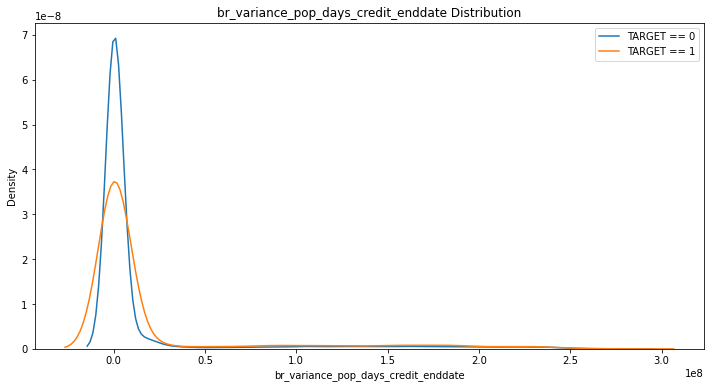

In [111]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

### br_min_days_enddate_fact

In [112]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.061652
br_min_days_enddate_fact  0.061652                  1.000000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0617
Median value for loan that was not repaid = -555.0000
Median value for loan that was repaid =     -811.0000


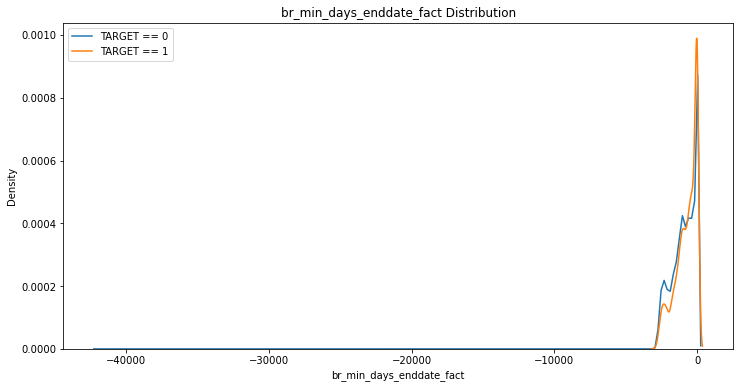

In [113]:
kde_target('br_min_days_enddate_fact', app_train)

In [114]:
## Yao-Johnson変換
num_cols = ['br_min_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_min_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [115]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.00000                   0.06139
br_min_days_enddate_fact  0.06139                   1.00000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0614
Median value for loan that was not repaid = 0.0177
Median value for loan that was repaid =     -0.2596


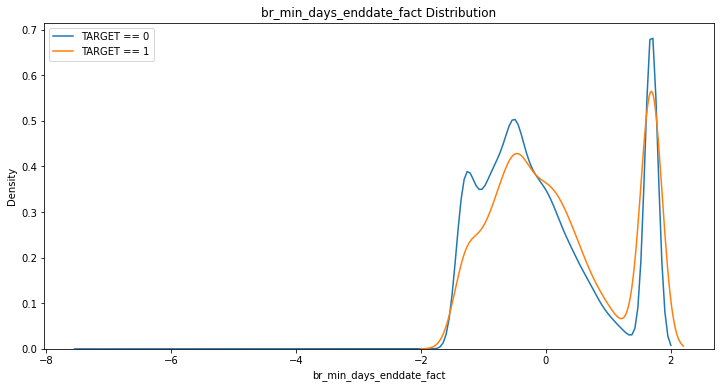

In [116]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_enddate_fact', app_train)

### br_max_days_enddate_fact

In [117]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.034766
br_max_days_enddate_fact  0.034766                  1.000000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0348
Median value for loan that was not repaid = -184.0000
Median value for loan that was repaid =     -235.0000


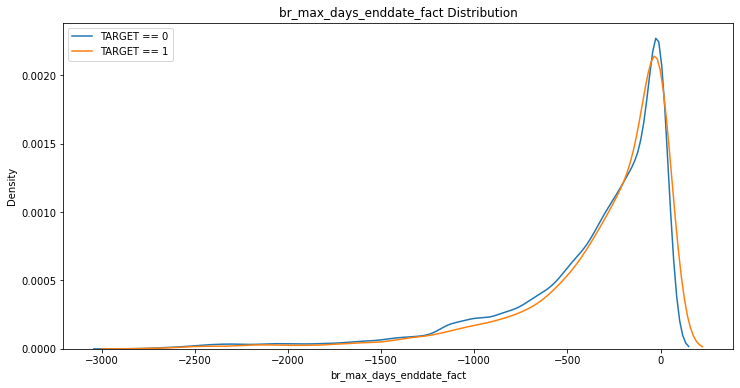

In [118]:
kde_target('br_max_days_enddate_fact', app_train)

In [119]:
## Yao-Johnson変換
num_cols = ['br_max_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_max_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [120]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.046031
br_max_days_enddate_fact  0.046031                  1.000000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0460
Median value for loan that was not repaid = -0.0133
Median value for loan that was repaid =     -0.1549


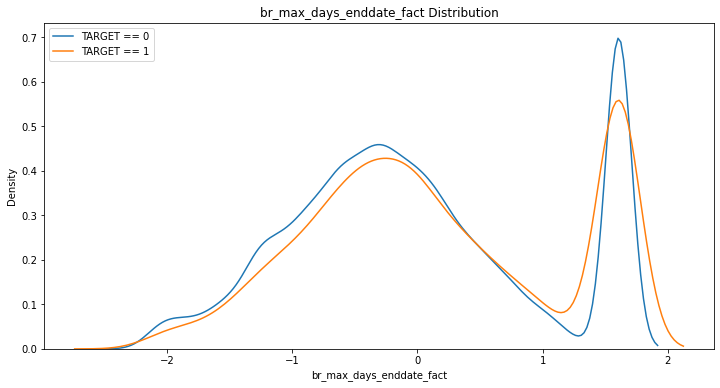

In [121]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_enddate_fact', app_train)

### br_sum_days_enddate_fact

In [122]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.048325
br_sum_days_enddate_fact  0.048325                  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0483
Median value for loan that was not repaid = -8281.0000
Median value for loan that was repaid =     -13533.0000


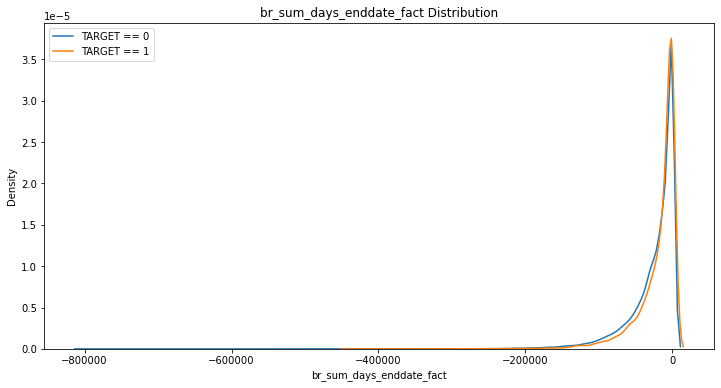

In [123]:
kde_target('br_sum_days_enddate_fact', app_train)

In [124]:
## Yao-Johnson変換
num_cols = ['br_sum_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [125]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.059242
br_sum_days_enddate_fact  0.059242                  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0592
Median value for loan that was not repaid = 0.0149
Median value for loan that was repaid =     -0.2125


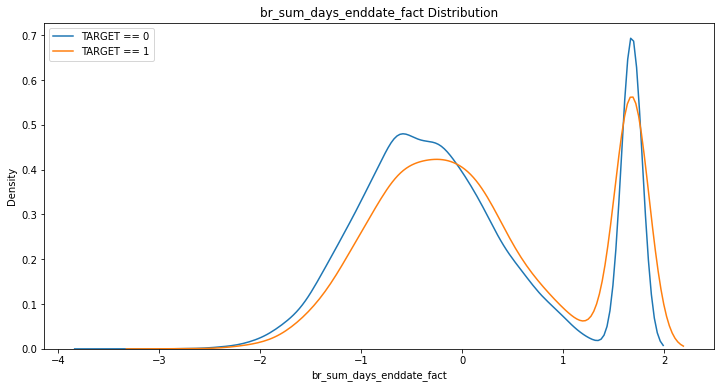

In [126]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_enddate_fact', app_train)

### br_avg_days_enddate_fact

In [127]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.058075
br_avg_days_enddate_fact  0.058075                  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0581
Median value for loan that was not repaid = -422.0455
Median value for loan that was repaid =     -572.0000


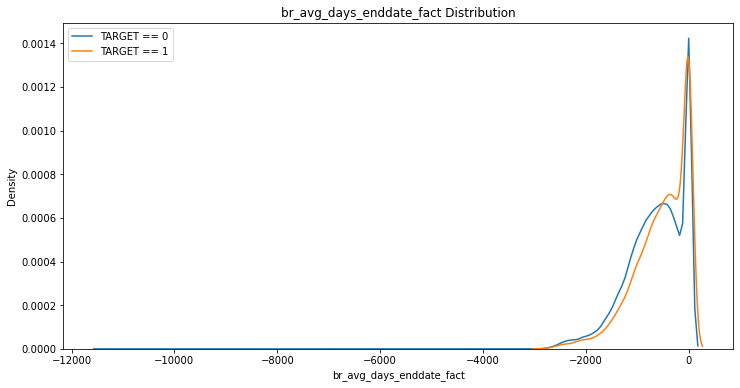

In [128]:
kde_target('br_avg_days_enddate_fact', app_train)

In [129]:
## Yao-Johnson変換
num_cols = ['br_avg_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [130]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.059941
br_avg_days_enddate_fact  0.059941                  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0599
Median value for loan that was not repaid = -0.0097
Median value for loan that was repaid =     -0.2465


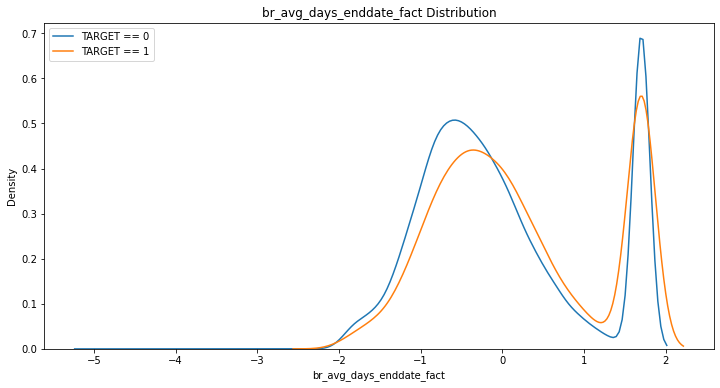

In [131]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_enddate_fact', app_train)

### br_cnt_days_enddate_fact

In [132]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.036698
br_cnt_days_enddate_fact -0.036698                  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0367
Median value for loan that was not repaid = 13.0000
Median value for loan that was repaid =     22.0000


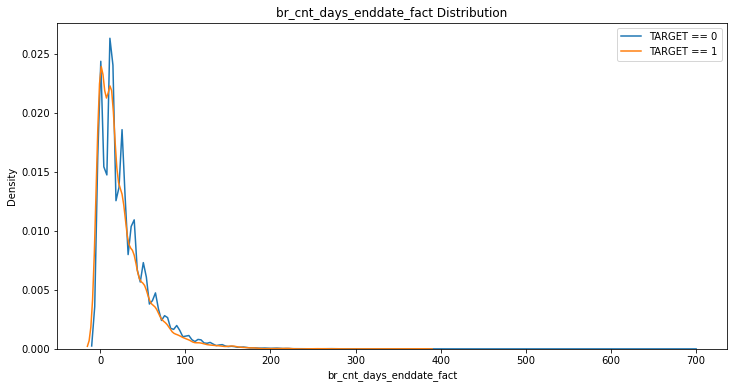

In [133]:
kde_target('br_cnt_days_enddate_fact', app_train)

In [134]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [135]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.048143
br_cnt_days_enddate_fact -0.048143                  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0481
Median value for loan that was not repaid = -0.2524
Median value for loan that was repaid =     0.1368


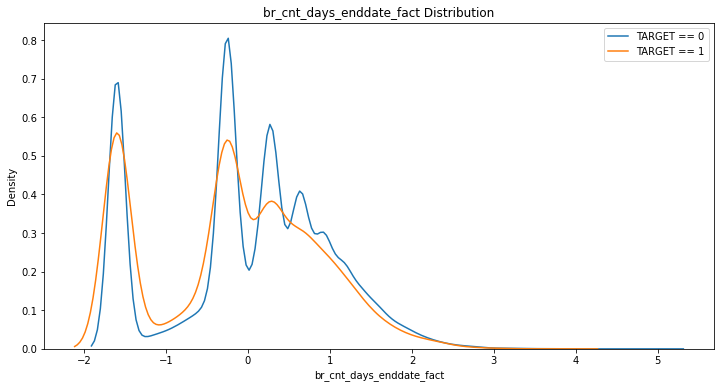

In [136]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_enddate_fact', app_train)

### br_stddev_days_enddate_fact

In [137]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.047689
br_stddev_days_enddate_fact -0.047689                     1.000000

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0477
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     71.5818


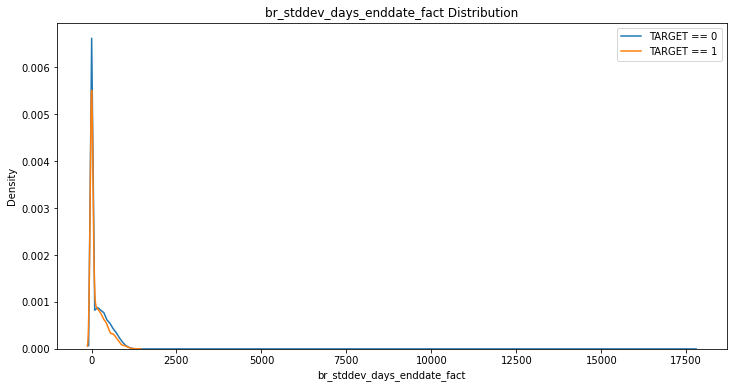

In [138]:
kde_target('br_stddev_days_enddate_fact', app_train)

In [139]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_enddate_fact'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [140]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

In [141]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_days_enddate_fact', app_train)

### br_stddev_pop_days_enddate_fact

In [142]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.047689
br_stddev_pop_days_enddate_fact -0.047689                         1.000000

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0477
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     71.5818


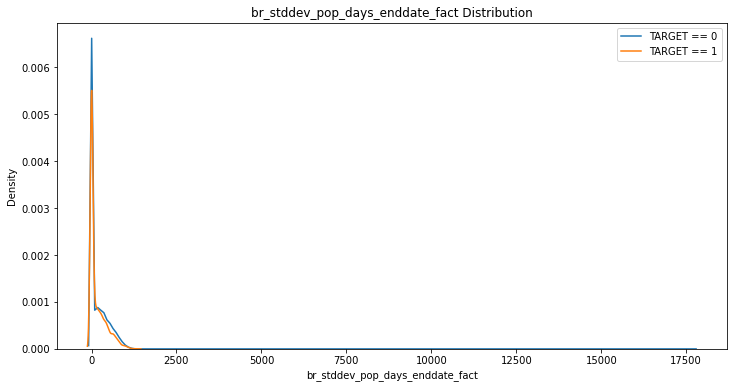

In [143]:
kde_target('br_stddev_pop_days_enddate_fact', app_train)

In [144]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [145]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0477
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     71.5818


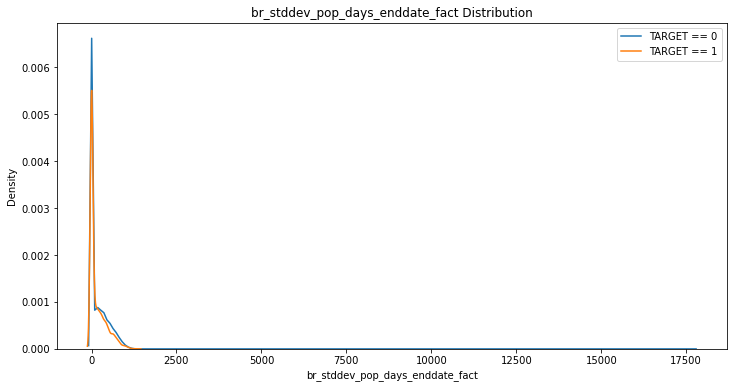

In [146]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_enddate_fact', app_train)

### br_var_pop_days_enddate_fact

In [147]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.008911
br_var_pop_days_enddate_fact -0.008911                      1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     5123.9578


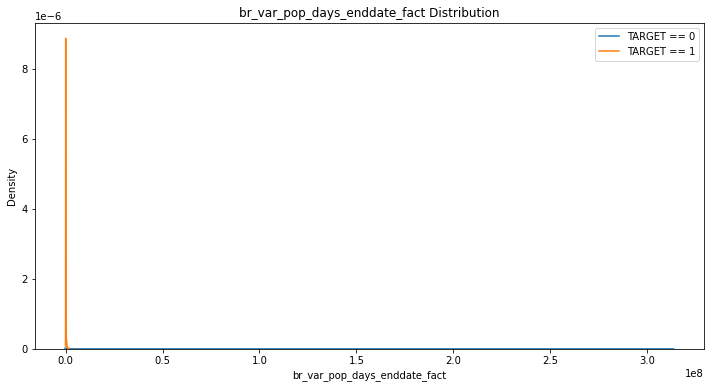

In [148]:
kde_target('br_var_pop_days_enddate_fact', app_train)

In [149]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [150]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.043885
br_var_pop_days_enddate_fact -0.043885                      1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0439
Median value for loan that was not repaid = -1.0682
Median value for loan that was repaid =     0.3999


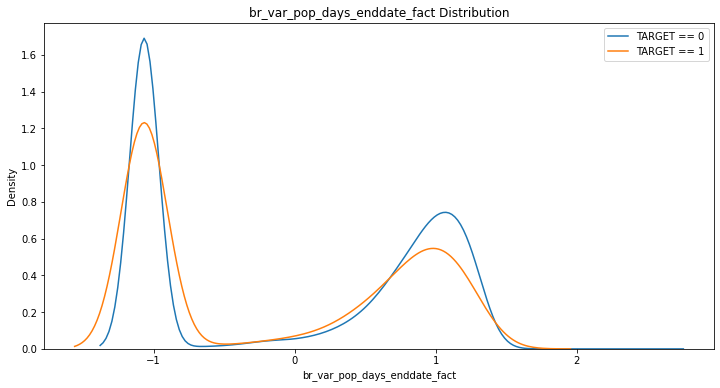

In [151]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_enddate_fact', app_train)

### br_var_samp_days_enddate_fact

In [152]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.008939
br_var_samp_days_enddate_fact -0.008939                       1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     5361.9359


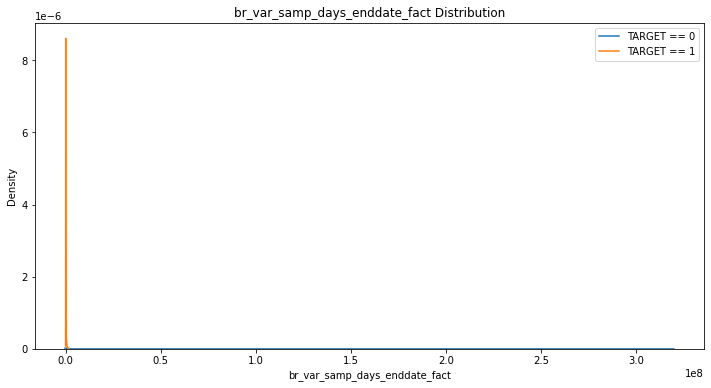

In [153]:
kde_target('br_var_samp_days_enddate_fact', app_train)

In [154]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [155]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.043825
br_var_samp_days_enddate_fact -0.043825                       1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0438
Median value for loan that was not repaid = -1.0687
Median value for loan that was repaid =     0.4030


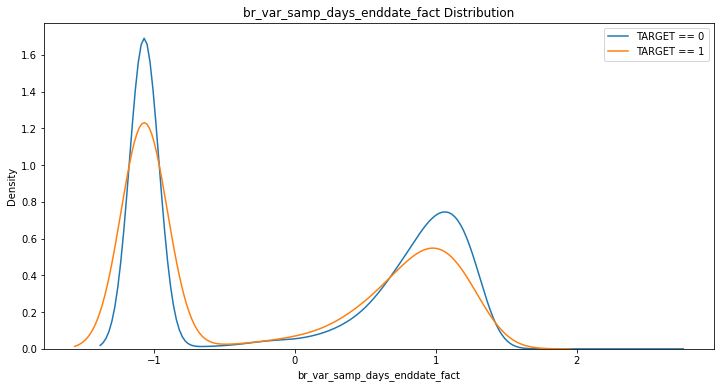

In [156]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_enddate_fact', app_train)

### br_variance_pop_days_enddate_fact

In [157]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.008911
br_variance_pop_days_enddate_fact -0.008911                           1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     5123.9578


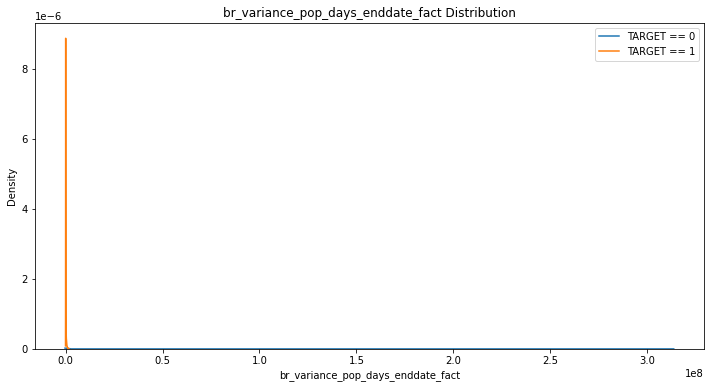

In [158]:
kde_target('br_variance_pop_days_enddate_fact', app_train)

In [159]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [160]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.043885
br_variance_pop_days_enddate_fact -0.043885                           1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0439
Median value for loan that was not repaid = -1.0682
Median value for loan that was repaid =     0.3999


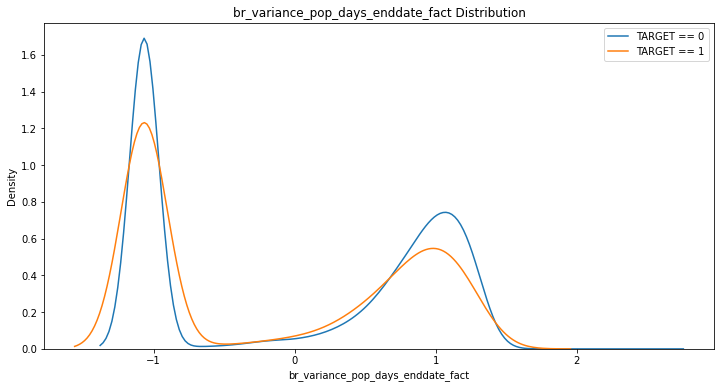

In [161]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_enddate_fact', app_train)

### br_min_amt_credit_max_overdue

In [162]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.002288
br_min_amt_credit_max_overdue  0.002288                       1.000000

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0023
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


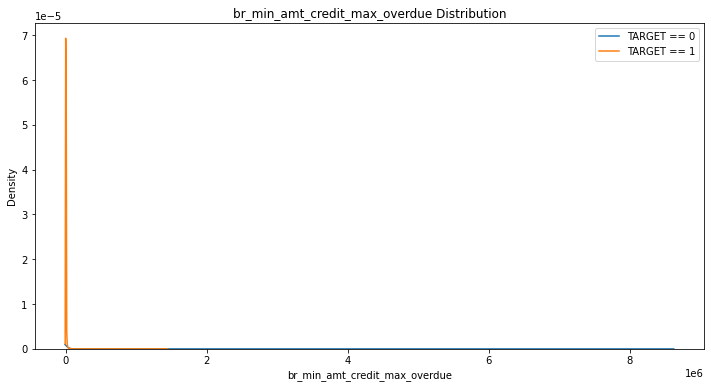

In [163]:
kde_target('br_min_amt_credit_max_overdue', app_train)

In [164]:
num_cols = ['br_min_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_min_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [165]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.028174
br_min_amt_credit_max_overdue  0.028174                       1.000000

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0282
Median value for loan that was not repaid = -0.2594
Median value for loan that was repaid =     -0.2594


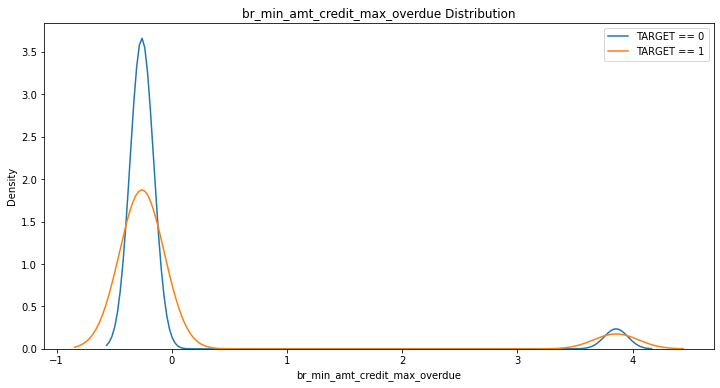

In [166]:
kde_target('br_min_amt_credit_max_overdue', app_train)

### br_max_amt_credit_max_overdue

In [167]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.000188
br_max_amt_credit_max_overdue  0.000188                       1.000000

The correlation between br_max_amt_credit_max_overdue and the TARGET is 0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


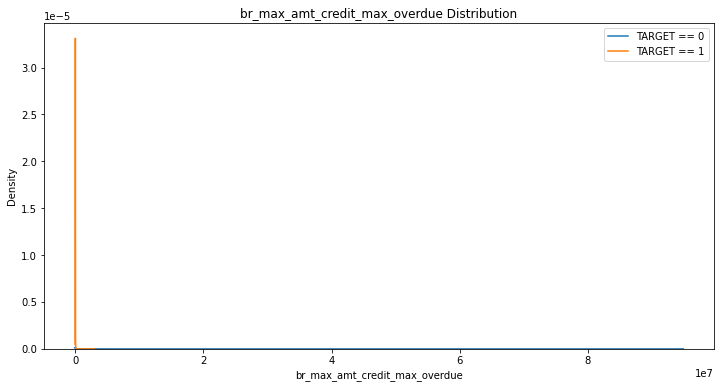

In [168]:
kde_target('br_max_amt_credit_max_overdue', app_train)

In [169]:
num_cols = ['br_max_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_max_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [170]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.00000                        0.04298
br_max_amt_credit_max_overdue  0.04298                        1.00000

The correlation between br_max_amt_credit_max_overdue and the TARGET is 0.0430
Median value for loan that was not repaid = -0.4836
Median value for loan that was repaid =     -0.4836


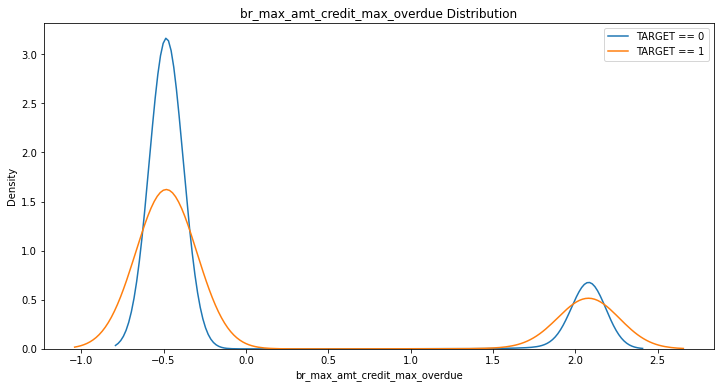

In [171]:
kde_target('br_max_amt_credit_max_overdue', app_train)

### br_sum_amt_credit_max_overdue

In [172]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.000105
br_sum_amt_credit_max_overdue  0.000105                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0001
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


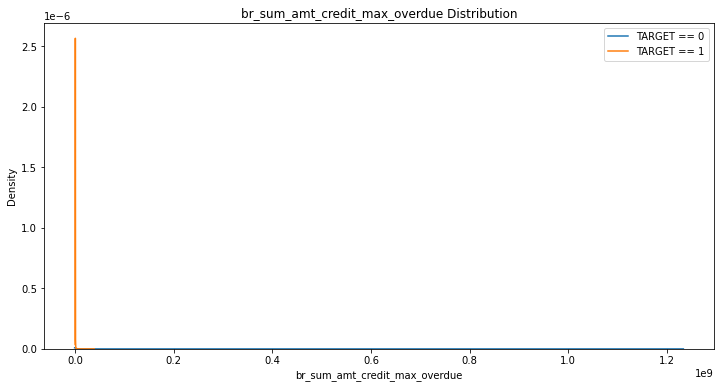

In [173]:
kde_target('br_sum_amt_credit_max_overdue', app_train)

In [174]:
num_cols = ['br_sum_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [175]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.042693
br_sum_amt_credit_max_overdue  0.042693                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0427
Median value for loan that was not repaid = -0.4840
Median value for loan that was repaid =     -0.4840


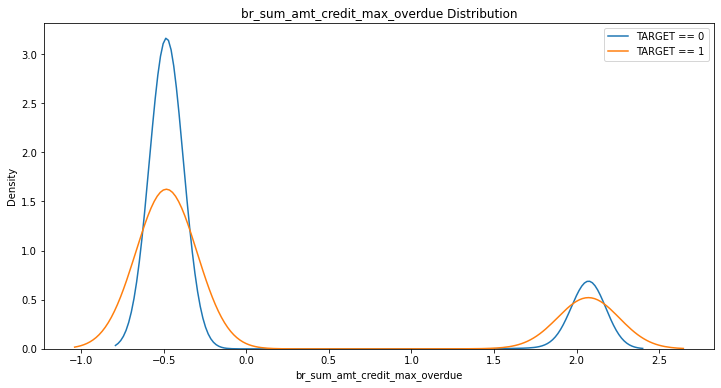

In [176]:
kde_target('br_sum_amt_credit_max_overdue', app_train)

### br_avg_amt_credit_max_overdue

In [177]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000193
br_avg_amt_credit_max_overdue -0.000193                       1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is -0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


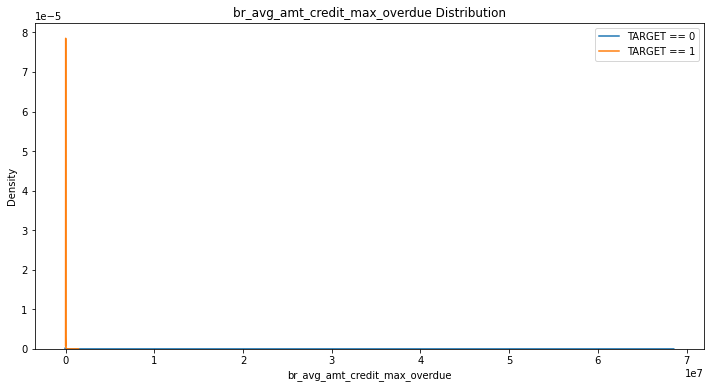

In [178]:
kde_target('br_avg_amt_credit_max_overdue', app_train)

In [179]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [180]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                       0.043043
br_avg_amt_credit_max_overdue  0.043043                       1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is 0.0430
Median value for loan that was not repaid = -0.4831
Median value for loan that was repaid =     -0.4831


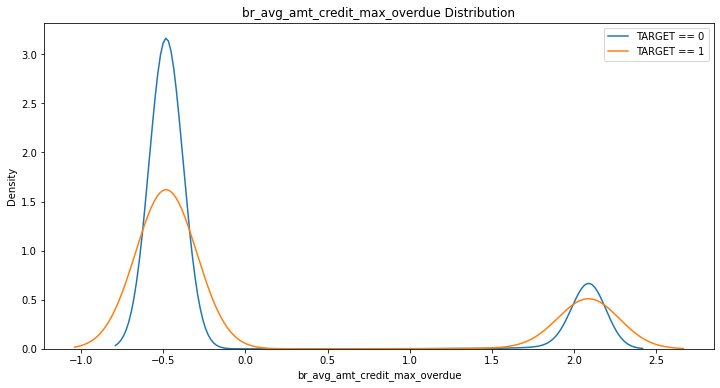

In [181]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_max_overdue', app_train)

### br_cnt_amt_credit_max_overdue

In [182]:
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                       0.001113
br_cnt_amt_credit_max_overdue  0.001113                       1.000000

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is 0.0011
Median value for loan that was not repaid = 11.0000
Median value for loan that was repaid =     12.0000


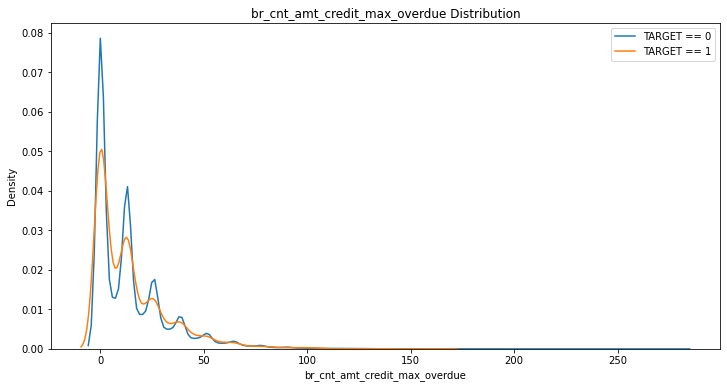

In [183]:
kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [184]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [185]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                       0.004802
br_cnt_amt_credit_max_overdue  0.004802                       1.000000

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is 0.0048
Median value for loan that was not repaid = 0.3686
Median value for loan that was repaid =     0.4236


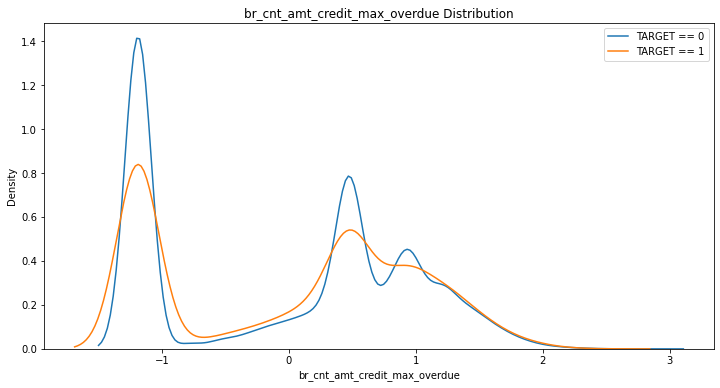

In [186]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_max_overdue', app_train)

### br_stddev_amt_credit_max_overdue

In [187]:
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                         -0.000151
br_stddev_amt_credit_max_overdue -0.000151                          1.000000

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is -0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


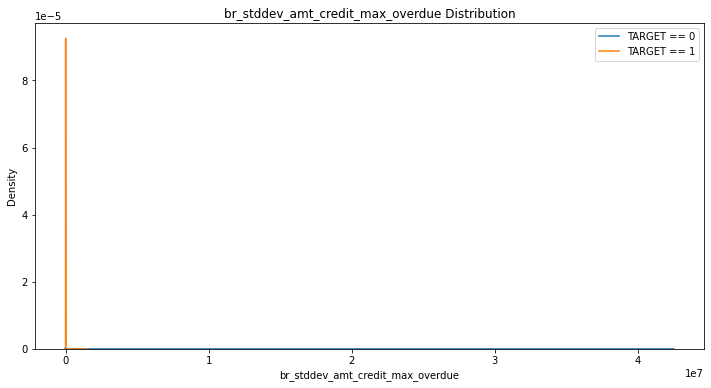

In [188]:
kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [189]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [190]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.034414
br_stddev_amt_credit_max_overdue  0.034414                          1.000000

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0344
Median value for loan that was not repaid = -0.4012
Median value for loan that was repaid =     -0.4012


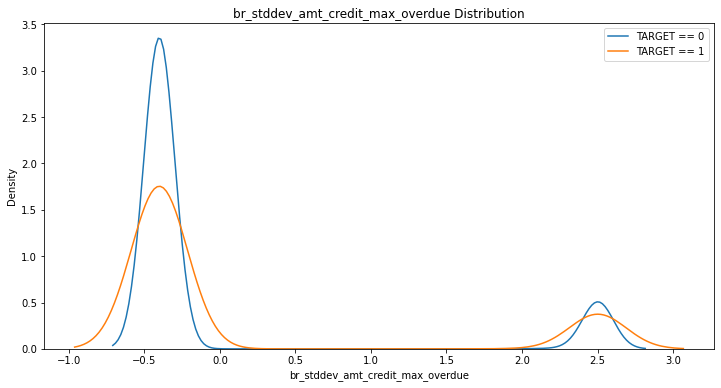

In [191]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_max_overdue', app_train)

### br_stddev_pop_amt_credit_max_overdue

In [192]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue -0.000151   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                           -0.000151  
br_stddev_pop_amt_credit_max_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is -0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


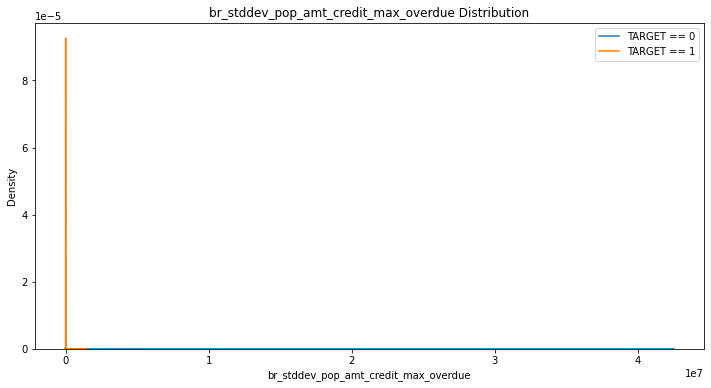

In [193]:
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [194]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [195]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.034414   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.034414  
br_stddev_pop_amt_credit_max_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0344
Median value for loan that was not repaid = -0.4012
Median value for loan that was repaid =     -0.4012


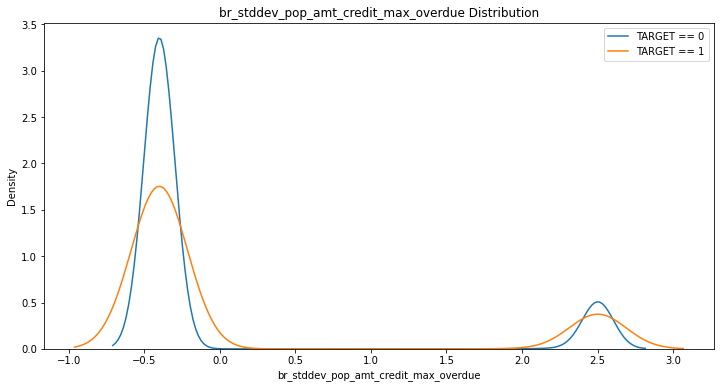

In [196]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

### br_var_pop_amt_credit_max_overdue

In [197]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                          -0.000987
br_var_pop_amt_credit_max_overdue -0.000987                           1.000000

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


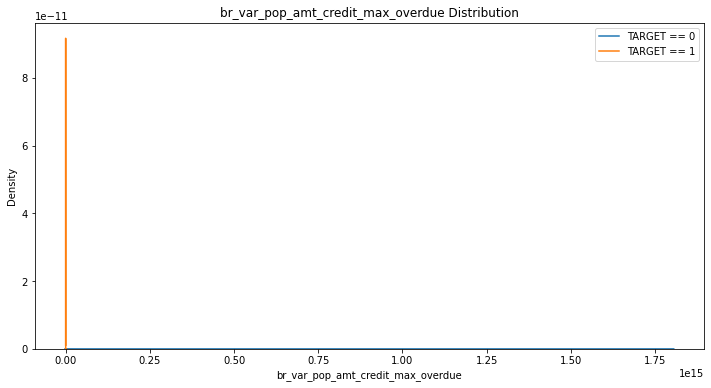

In [198]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [199]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [200]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                           0.034478
br_var_pop_amt_credit_max_overdue  0.034478                           1.000000

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.4010
Median value for loan that was repaid =     -0.4010


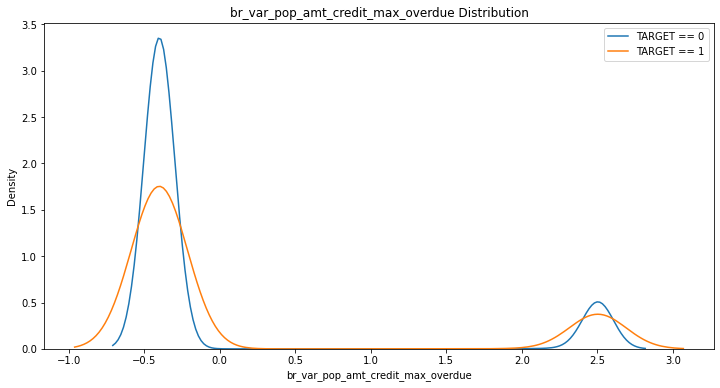

In [201]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

### br_var_samp_amt_credit_max_overdue

In [202]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue -0.000988   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                       -0.000988  
br_var_samp_amt_credit_max_overdue                            1.000000

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


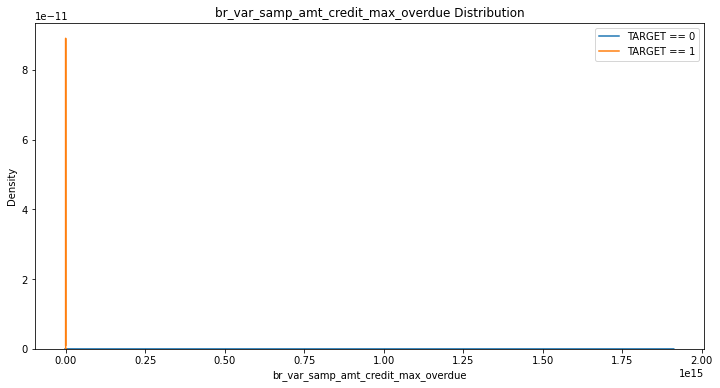

In [203]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [204]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [205]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue  0.034475   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                        0.034475  
br_var_samp_amt_credit_max_overdue                            1.000000

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.4010
Median value for loan that was repaid =     -0.4010


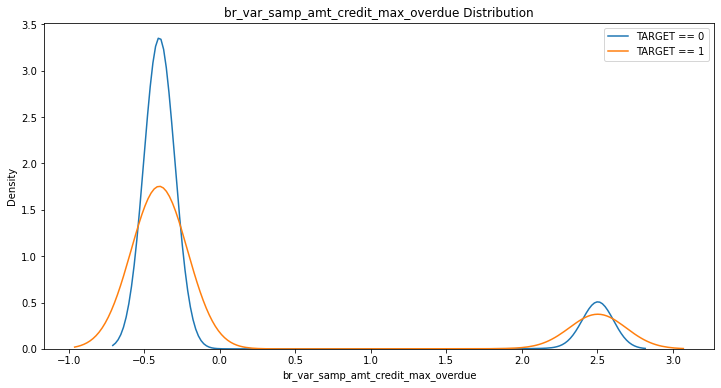

In [206]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

### br_variance_pop_amt_credit_max_overdue

In [207]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue -0.000987   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                               -0.000987  
br_variance_pop_amt_credit_max_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


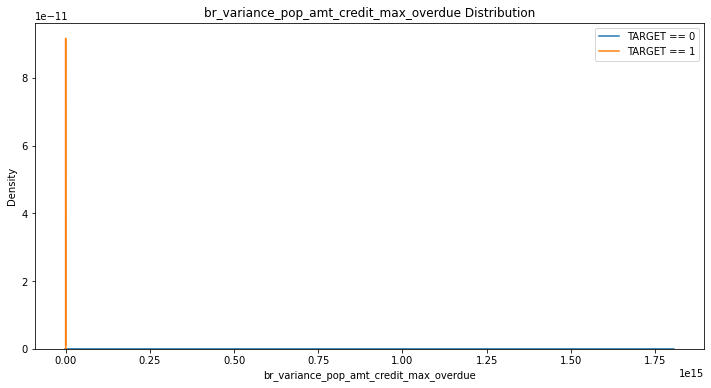

In [208]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [209]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [210]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue  0.034478   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                                0.034478  
br_variance_pop_amt_credit_max_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.4010
Median value for loan that was repaid =     -0.4010


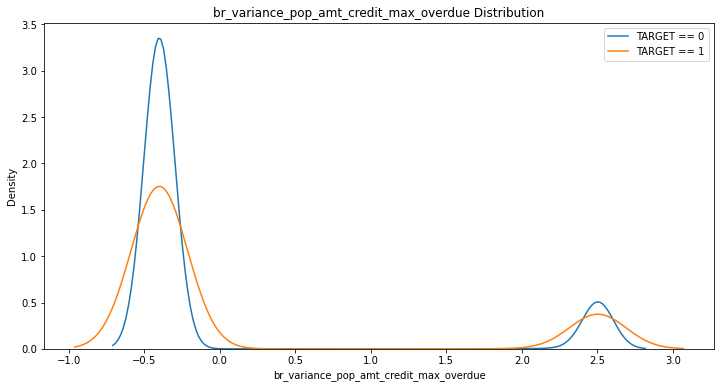

In [211]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

### br_min_cnt_credit_prolong

In [212]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.004577
br_min_cnt_credit_prolong  0.004577                   1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0046
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


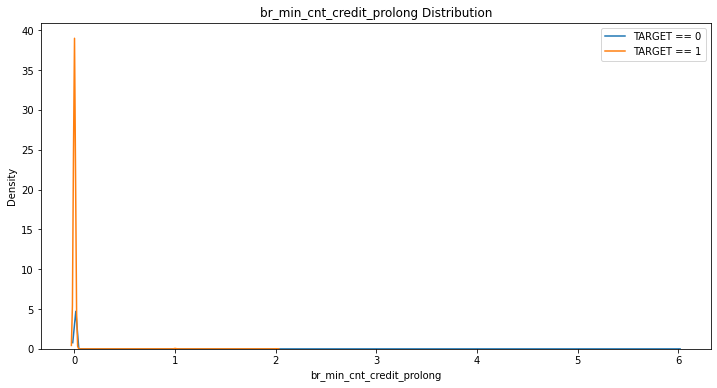

In [213]:
kde_target('br_min_cnt_credit_prolong', app_train)

In [214]:
## Yao-Johnson変換
num_cols = ['br_min_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_min_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [215]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                      1.000                      0.006
br_min_cnt_credit_prolong   0.006                      1.000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0060
Median value for loan that was not repaid = -0.0362
Median value for loan that was repaid =     -0.0362


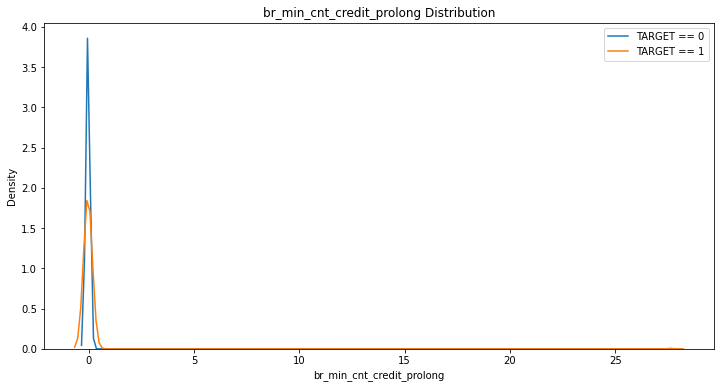

In [216]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_cnt_credit_prolong', app_train)

### br_max_cnt_credit_prolong

In [217]:
## 目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.008901
br_max_cnt_credit_prolong  0.008901                   1.000000

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0089
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


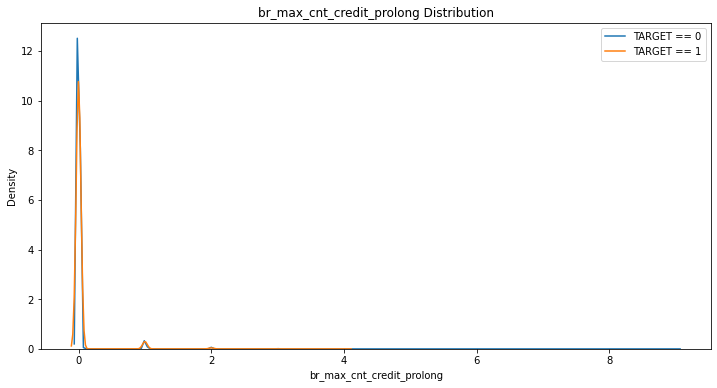

In [218]:
## 特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

In [219]:
## Yao-Johnson変換
num_cols = ['br_max_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_max_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [220]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.013013
br_max_cnt_credit_prolong  0.013013                   1.000000

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0130
Median value for loan that was not repaid = -0.1577
Median value for loan that was repaid =     -0.1577


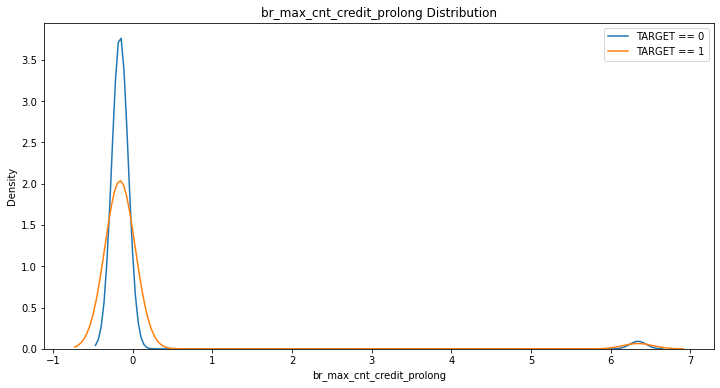

In [221]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

### br_sum_cnt_credit_prolong

In [222]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.000000                   0.005804
br_sum_cnt_credit_prolong  0.005804                   1.000000

The correlation between br_sum_cnt_credit_prolong and the TARGET is 0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


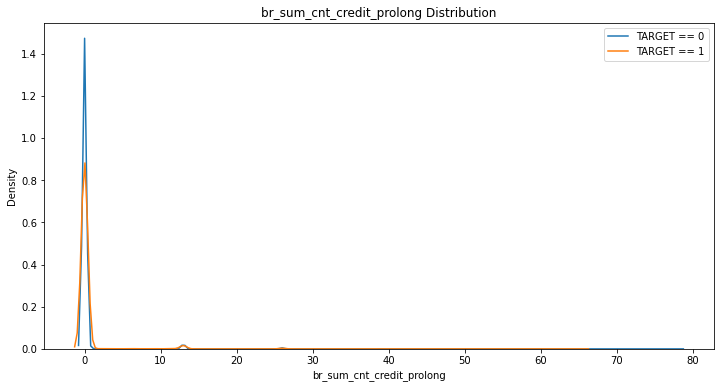

In [223]:
## 特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

In [224]:
## Yao-Johnson変換
num_cols = ['br_sum_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_sum_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [225]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.000000                   0.013013
br_sum_cnt_credit_prolong  0.013013                   1.000000

The correlation between br_sum_cnt_credit_prolong and the TARGET is 0.0130
Median value for loan that was not repaid = -0.1577
Median value for loan that was repaid =     -0.1577


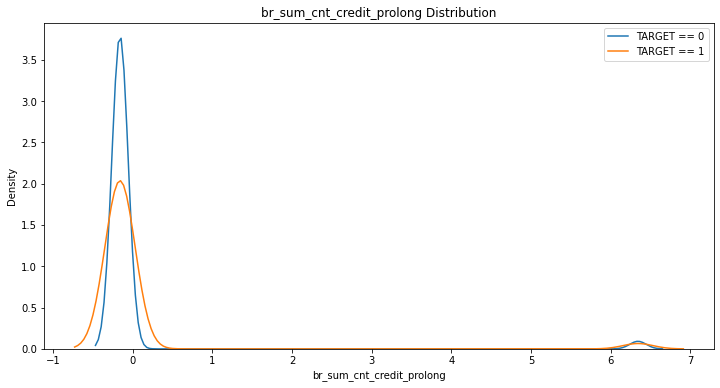

In [226]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

### br_avg_cnt_credit_prolong

In [227]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.008938
br_avg_cnt_credit_prolong  0.008938                   1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0089
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


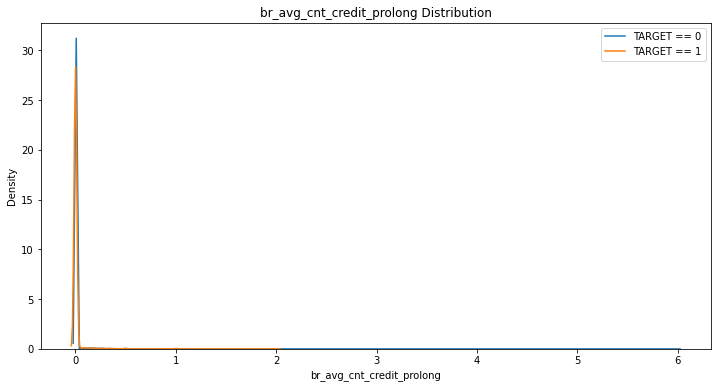

In [228]:
## 特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

In [229]:
## Yao-Johnson変換
num_cols = ['br_avg_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_avg_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [230]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.012969
br_avg_cnt_credit_prolong  0.012969                   1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0130
Median value for loan that was not repaid = -0.1577
Median value for loan that was repaid =     -0.1577


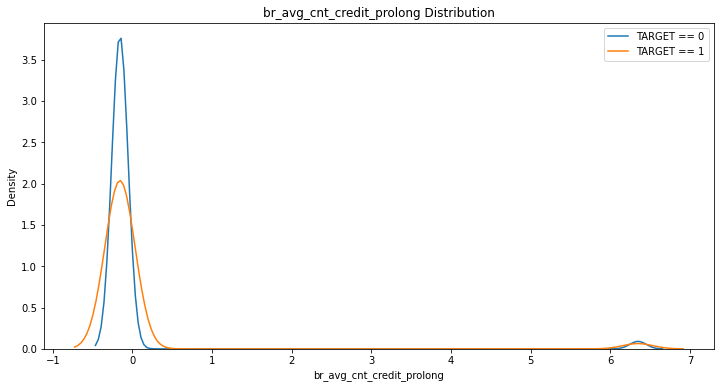

In [231]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

### br_cnt_cnt_credit_prolong

In [232]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.012242
br_cnt_cnt_credit_prolong -0.012242                   1.000000

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0122
Median value for loan that was not repaid = 35.0000
Median value for loan that was repaid =     38.0000


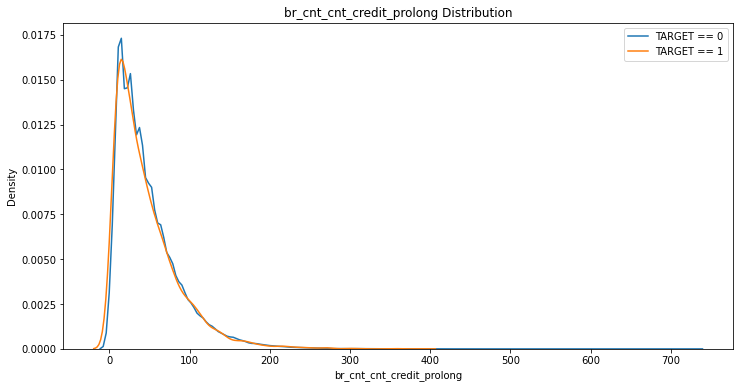

In [233]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

### br_stddev_cnt_credit_prolong

In [234]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.007897
br_stddev_cnt_credit_prolong  0.007897                      1.000000

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0079
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


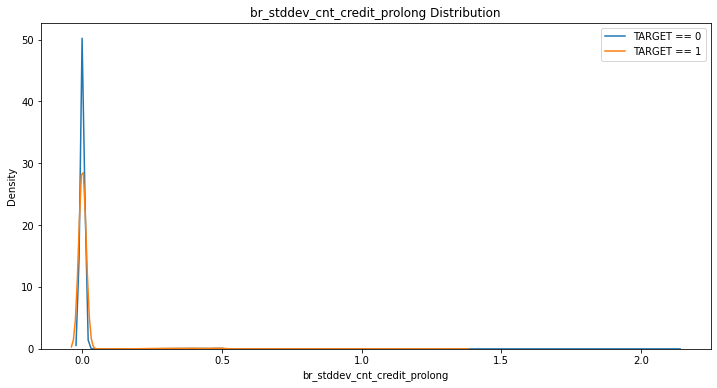

In [235]:
## 特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

In [236]:
## Yao-Johnson変換
num_cols = ['br_stddev_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [237]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.011921
br_stddev_cnt_credit_prolong  0.011921                      1.000000

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0119
Median value for loan that was not repaid = -0.1533
Median value for loan that was repaid =     -0.1533


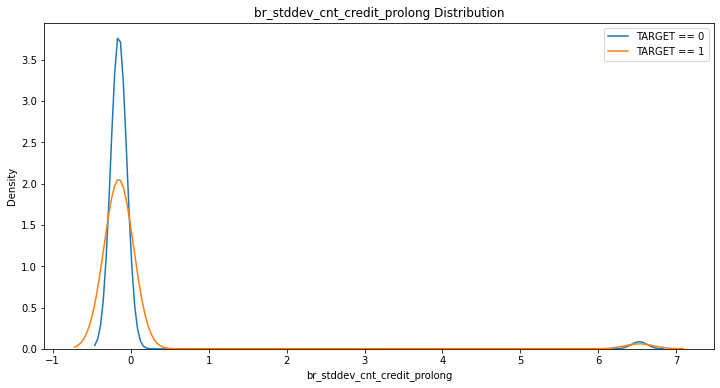

In [238]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

### br_stddev_pop_cnt_credit_prolong

In [239]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.007897
br_stddev_pop_cnt_credit_prolong  0.007897                          1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0079
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


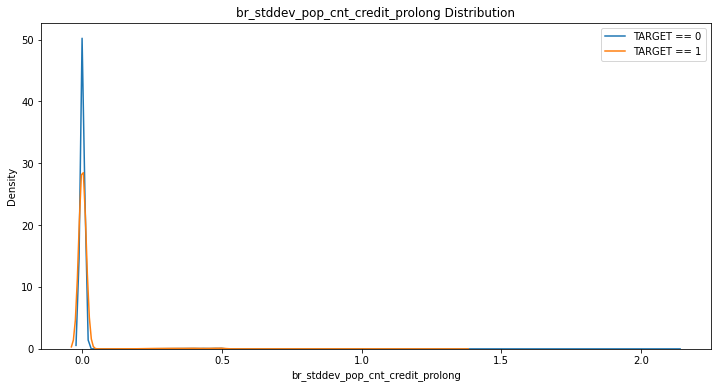

In [240]:
## 特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

In [241]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [242]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.011921
br_stddev_pop_cnt_credit_prolong  0.011921                          1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0119
Median value for loan that was not repaid = -0.1533
Median value for loan that was repaid =     -0.1533


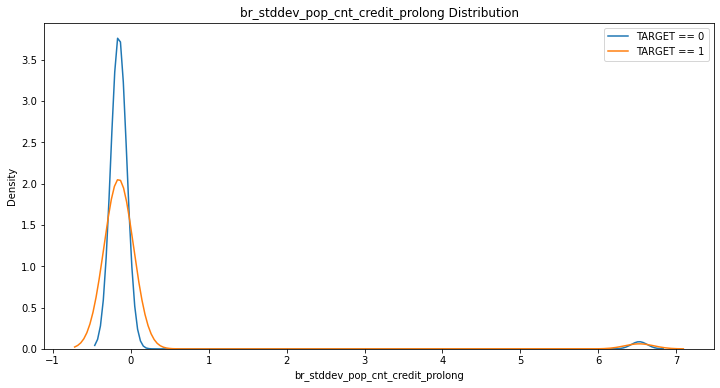

In [243]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

### br_var_pop_cnt_credit_prolong

In [244]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.003283
br_var_pop_cnt_credit_prolong  0.003283                       1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0033
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


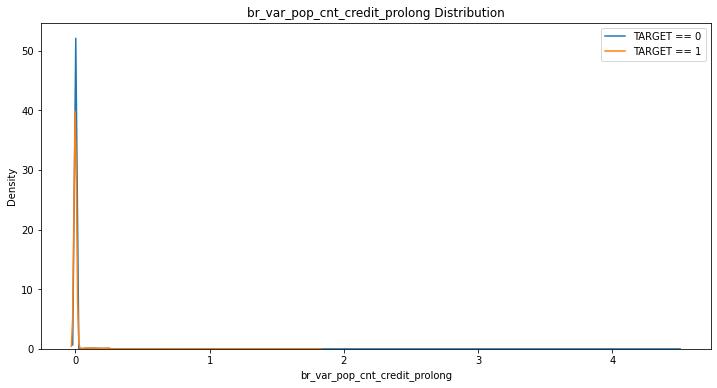

In [245]:
## 特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

In [246]:
## Yao-Johnson変換
num_cols = ['br_var_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [247]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.011935
br_var_pop_cnt_credit_prolong  0.011935                       1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0119
Median value for loan that was not repaid = -0.1533
Median value for loan that was repaid =     -0.1533


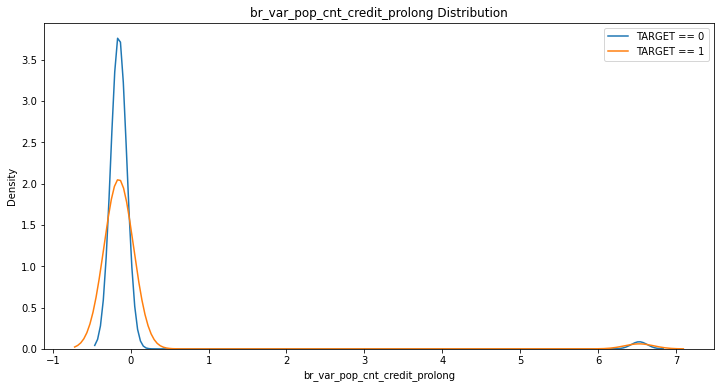

In [248]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

### br_var_samp_cnt_credit_prolong

In [249]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.003479
br_var_samp_cnt_credit_prolong  0.003479                        1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0035
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


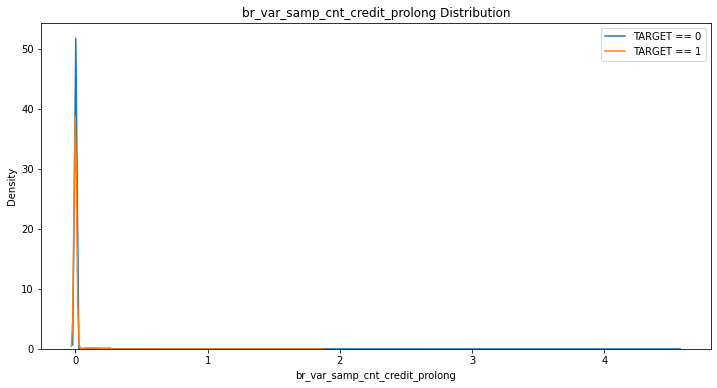

In [250]:
## 特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

In [251]:
## Yao-Johnson変換
num_cols = ['br_var_samp_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [252]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.011935
br_var_samp_cnt_credit_prolong  0.011935                        1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0119
Median value for loan that was not repaid = -0.1533
Median value for loan that was repaid =     -0.1533


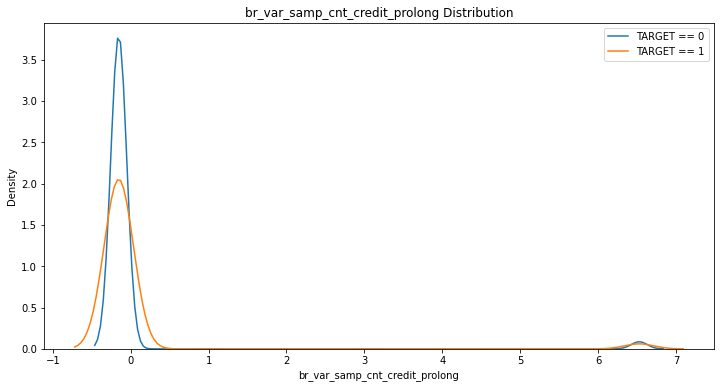

In [253]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

### br_variance_pop_cnt_credit_prolong

In [254]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.003283   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.003283  
br_variance_pop_cnt_credit_prolong                            1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0033
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


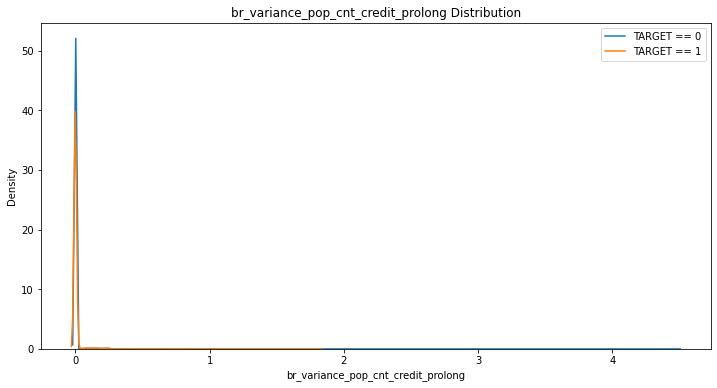

In [255]:
## 特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

In [256]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [257]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.011935   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.011935  
br_variance_pop_cnt_credit_prolong                            1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0119
Median value for loan that was not repaid = -0.1533
Median value for loan that was repaid =     -0.1533


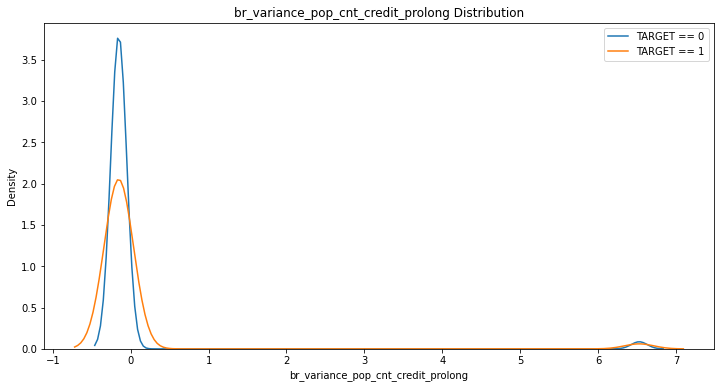

In [258]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

### br_min_amt_credit_sum

In [259]:
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.00000               -0.01632
br_min_amt_credit_sum -0.01632                1.00000

The correlation between br_min_amt_credit_sum and the TARGET is -0.0163
Median value for loan that was not repaid = 45000.0000
Median value for loan that was repaid =     49500.0000


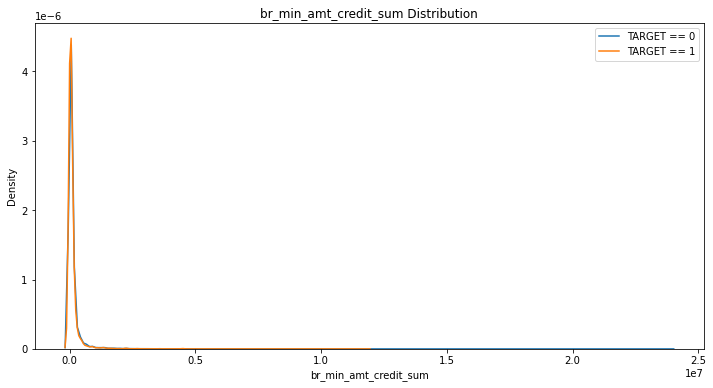

In [260]:
kde_target('br_min_amt_credit_sum', app_train)

In [261]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [262]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.022471
br_min_amt_credit_sum -0.022471               1.000000

The correlation between br_min_amt_credit_sum and the TARGET is -0.0225
Median value for loan that was not repaid = 0.0372
Median value for loan that was repaid =     0.0818


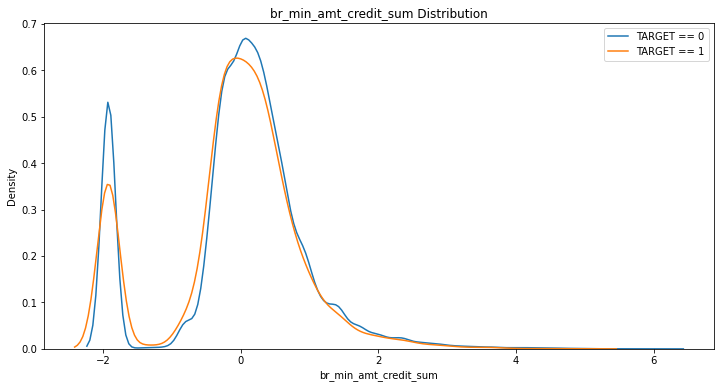

In [263]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum', app_train)

### br_max_amt_credit_sum

In [264]:
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.018063
br_max_amt_credit_sum -0.018063               1.000000

The correlation between br_max_amt_credit_sum and the TARGET is -0.0181
Median value for loan that was not repaid = 437400.0000
Median value for loan that was repaid =     450000.0000


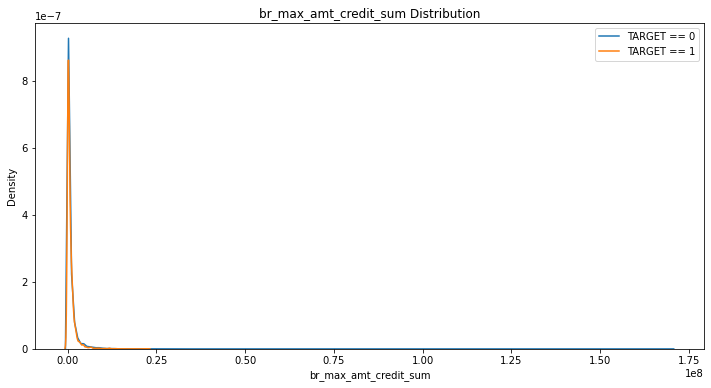

In [265]:
kde_target('br_max_amt_credit_sum', app_train)

In [266]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [267]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.019134
br_max_amt_credit_sum -0.019134               1.000000

The correlation between br_max_amt_credit_sum and the TARGET is -0.0191
Median value for loan that was not repaid = -0.0558
Median value for loan that was repaid =     -0.0350


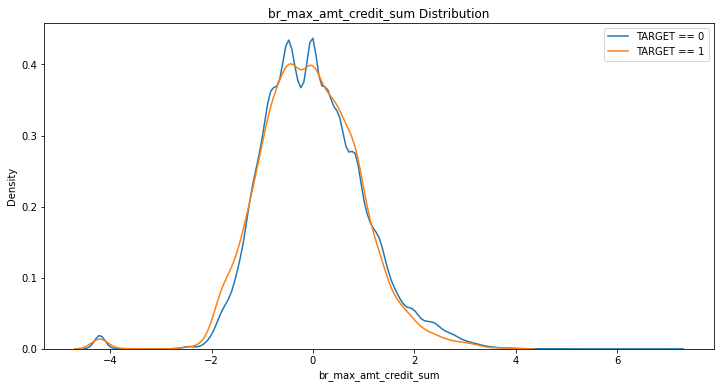

In [268]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum', app_train)

### br_sum_amt_credit_sum

In [269]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.018777
br_sum_amt_credit_sum -0.018777               1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0188
Median value for loan that was not repaid = 7217460.0000
Median value for loan that was repaid =     8587688.1750


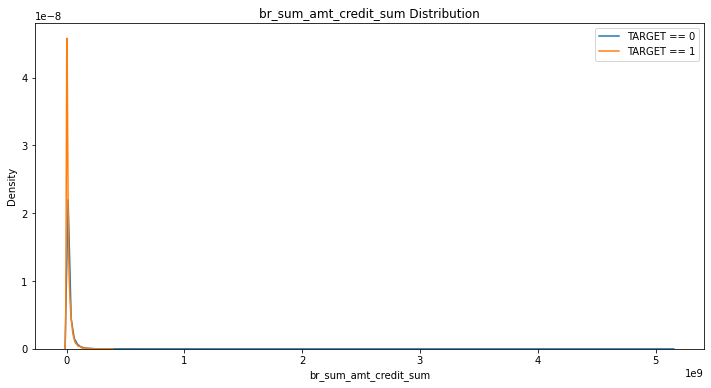

In [270]:
kde_target('br_sum_amt_credit_sum', app_train)

In [271]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [272]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.032159
br_sum_amt_credit_sum -0.032159               1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0322
Median value for loan that was not repaid = -0.1264
Median value for loan that was repaid =     -0.0130


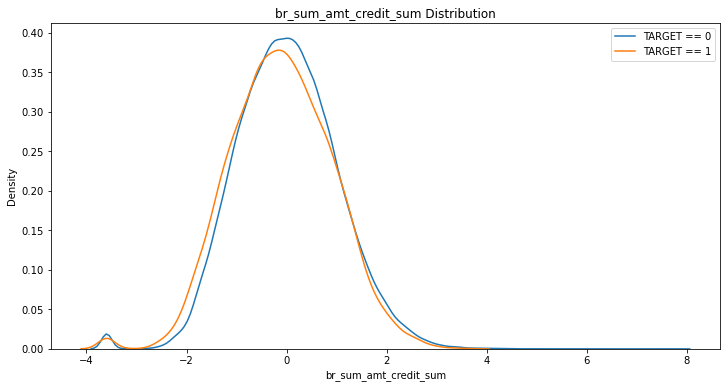

In [273]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum', app_train)

### br_avg_amt_credit_sum

In [274]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.023888
br_avg_amt_credit_sum -0.023888               1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0239
Median value for loan that was not repaid = 195750.0000
Median value for loan that was repaid =     211978.1824


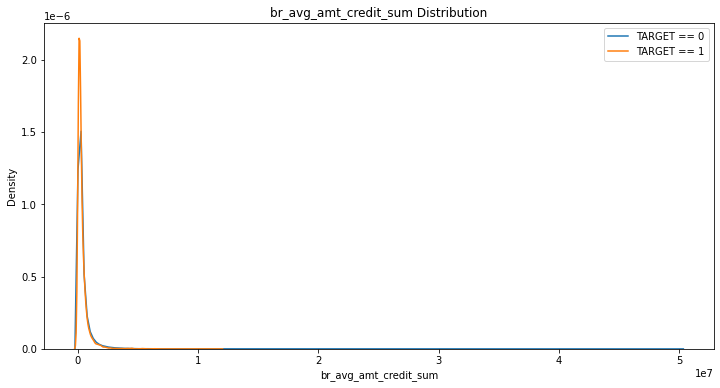

In [275]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

In [276]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [277]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.027534
br_avg_amt_credit_sum -0.027534               1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0275
Median value for loan that was not repaid = -0.1563
Median value for loan that was repaid =     -0.0896


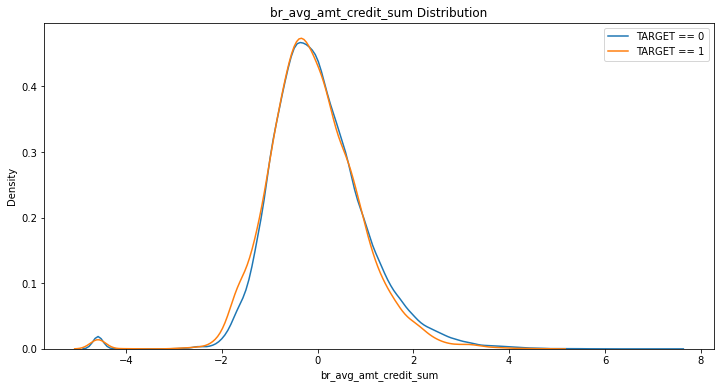

In [278]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

### br_cnt_amt_credit_sum

In [279]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.012242
br_cnt_amt_credit_sum -0.012242               1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0122
Median value for loan that was not repaid = 35.0000
Median value for loan that was repaid =     38.0000


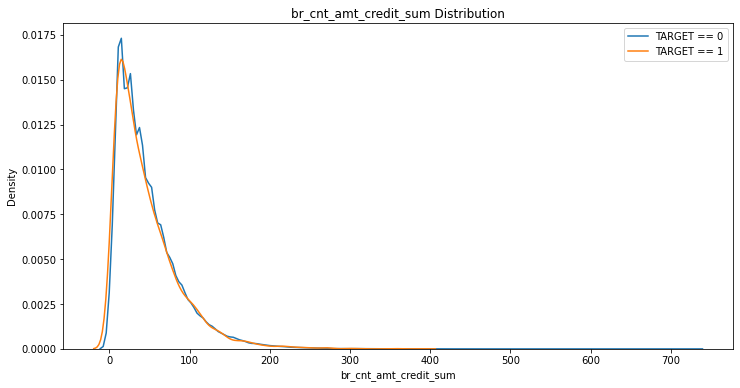

In [280]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

In [281]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [282]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.022992
br_cnt_amt_credit_sum -0.022992               1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0230
Median value for loan that was not repaid = -0.0478
Median value for loan that was repaid =     0.0477


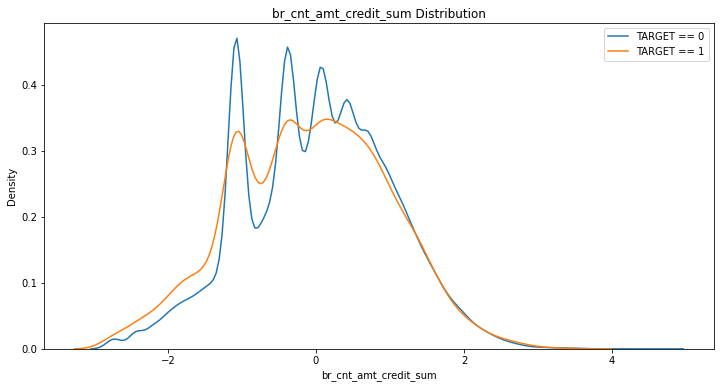

In [283]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

### br_stddev_amt_credit_sum

In [284]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.000000                 -0.015181
br_stddev_amt_credit_sum -0.015181                  1.000000

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0152
Median value for loan that was not repaid = 111641.9376
Median value for loan that was repaid =     113737.8809


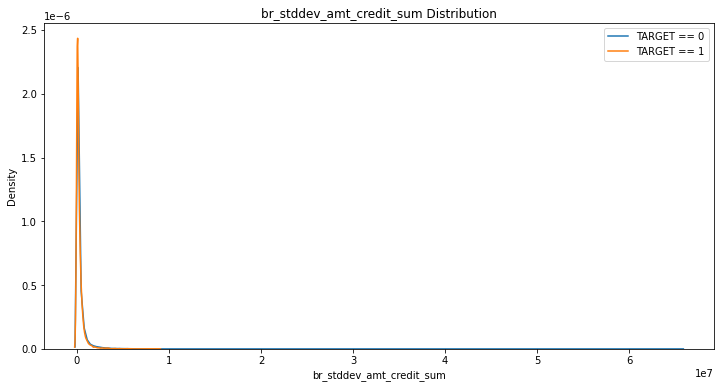

In [285]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

### br_stddev_pop_amt_credit_sum

In [286]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

TARGET  br_stddev_pop_amt_credit_sum
TARGET                        1.000000                     -0.015181
br_stddev_pop_amt_credit_sum -0.015181                      1.000000

The correlation between br_stddev_pop_amt_credit_sum and the TARGET is -0.0152
Median value for loan that was not repaid = 111641.9376
Median value for loan that was repaid =     113737.8809


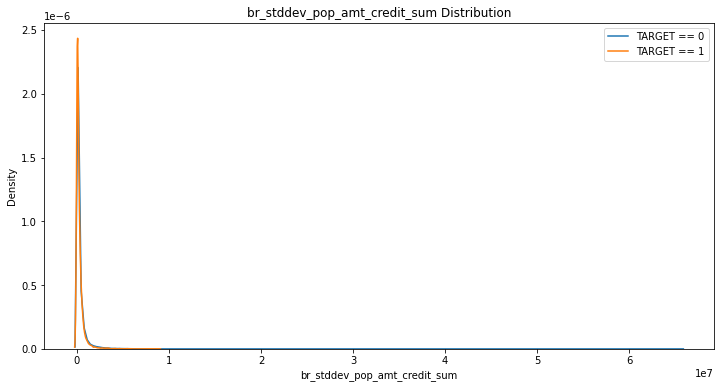

In [287]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum', app_train)

### br_var_pop_amt_credit_sum

In [288]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.003166
br_var_pop_amt_credit_sum -0.003166                   1.000000

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0032
Median value for loan that was not repaid = 12463922220.1642
Median value for loan that was repaid =     12936305550.3160


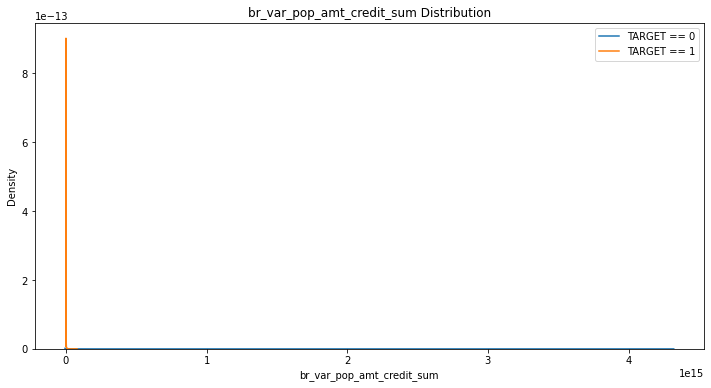

In [289]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

In [290]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [291]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.013173
br_var_pop_amt_credit_sum -0.013173                   1.000000

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0132
Median value for loan that was not repaid = 0.1552
Median value for loan that was repaid =     0.1631


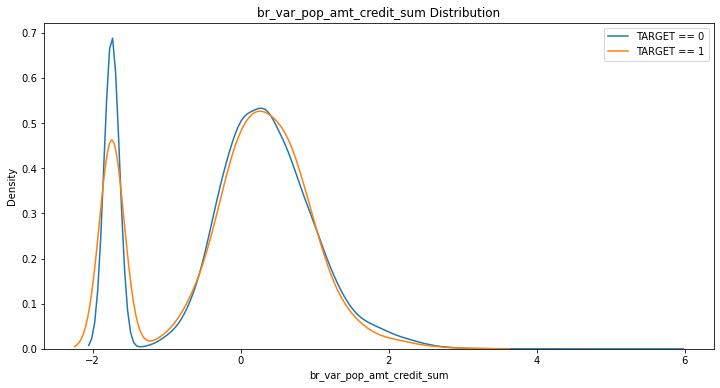

In [292]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

### br_var_samp_amt_credit_sum

In [293]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.003199
br_var_samp_amt_credit_sum -0.003199                    1.000000

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0032
Median value for loan that was not repaid = 12846224742.9101
Median value for loan that was repaid =     13306545100.6721


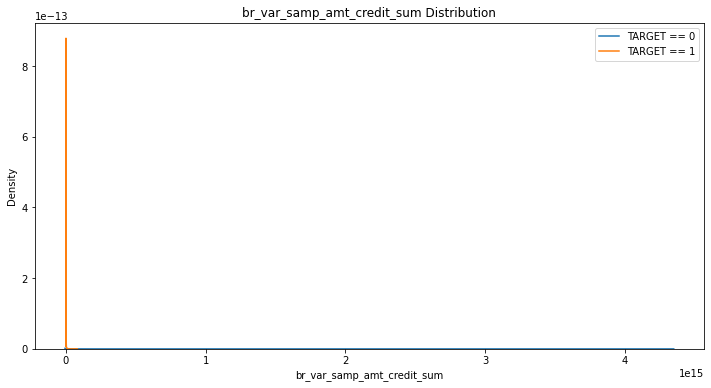

In [294]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

In [295]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [296]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.013043
br_var_samp_amt_credit_sum -0.013043                    1.000000

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0130
Median value for loan that was not repaid = 0.1556
Median value for loan that was repaid =     0.1631


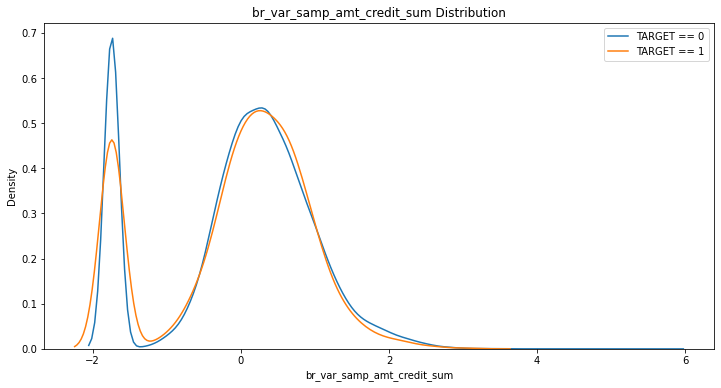

In [297]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

### br_variance_pop_amt_credit_sum

In [298]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.003166
br_variance_pop_amt_credit_sum -0.003166                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0032
Median value for loan that was not repaid = 12463922220.1642
Median value for loan that was repaid =     12936305550.3160


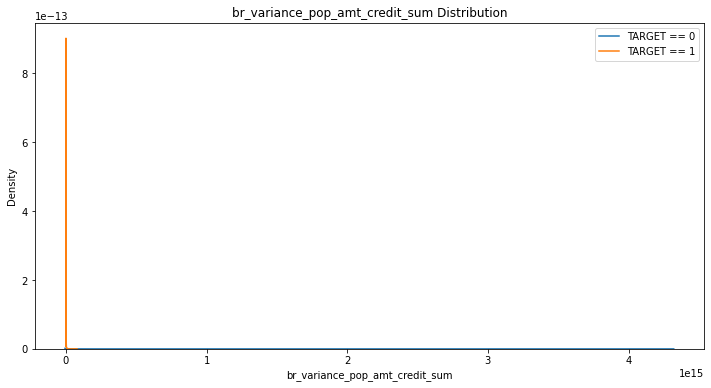

In [299]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [300]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [301]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.013173
br_variance_pop_amt_credit_sum -0.013173                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0132
Median value for loan that was not repaid = 0.1552
Median value for loan that was repaid =     0.1631


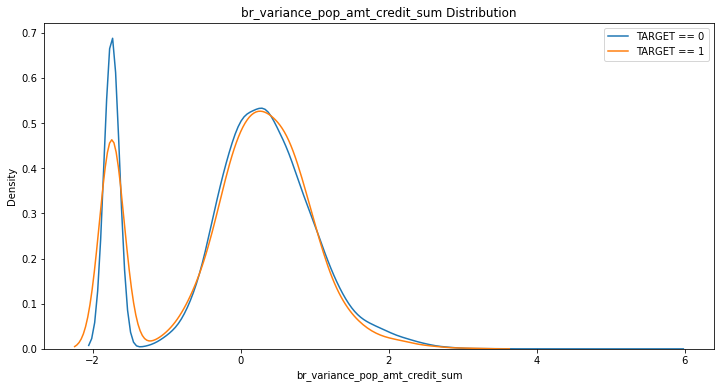

In [302]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

### br_min_amt_credit_sum_debt

In [303]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.00000                    -0.00307
br_min_amt_credit_sum_debt -0.00307                     1.00000

The correlation between br_min_amt_credit_sum_debt and the TARGET is -0.0031
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


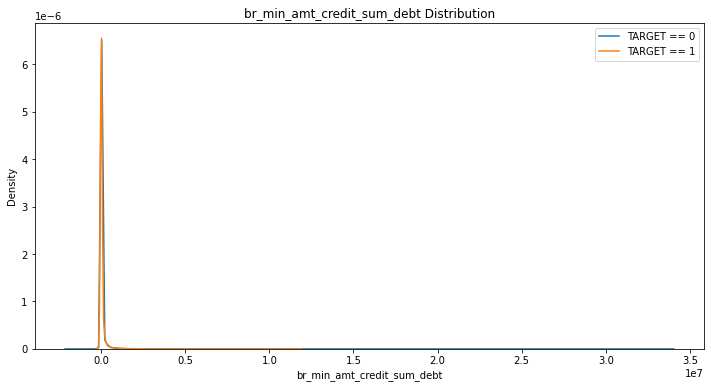

In [304]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [305]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [306]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.000000                    0.000423
br_min_amt_credit_sum_debt  0.000423                    1.000000

The correlation between br_min_amt_credit_sum_debt and the TARGET is 0.0004
Median value for loan that was not repaid = -0.1204
Median value for loan that was repaid =     -0.1204


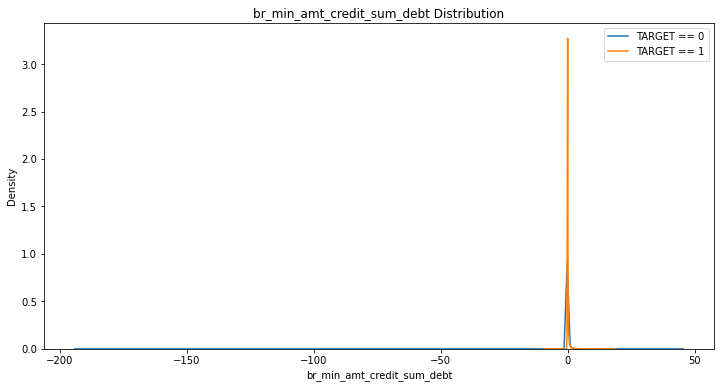

In [307]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [308]:
app_train.drop(['br_min_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_debt'], axis=1, inplace=True)

### br_max_amt_credit_sum_debt

In [309]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.00000                     0.00003
br_max_amt_credit_sum_debt  0.00003                     1.00000

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0000
Median value for loan that was not repaid = 201105.0000
Median value for loan that was repaid =     143491.5000


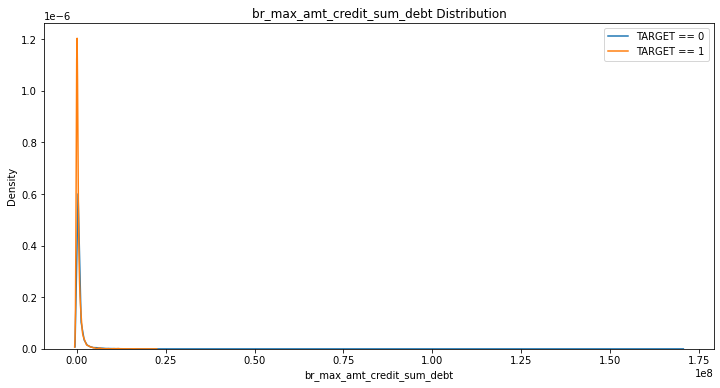

In [310]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

In [311]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [312]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.015048
br_max_amt_credit_sum_debt  0.015048                    1.000000

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0150
Median value for loan that was not repaid = -0.1346
Median value for loan that was repaid =     -0.2364


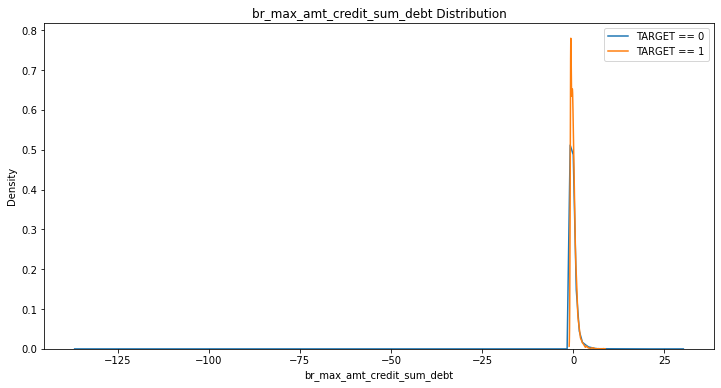

In [313]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

### br_sum_amt_credit_sum_debt

In [314]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                    0.001653
br_sum_amt_credit_sum_debt  0.001653                    1.000000

The correlation between br_sum_amt_credit_sum_debt and the TARGET is 0.0017
Median value for loan that was not repaid = 1991925.0000
Median value for loan that was repaid =     1387126.8000


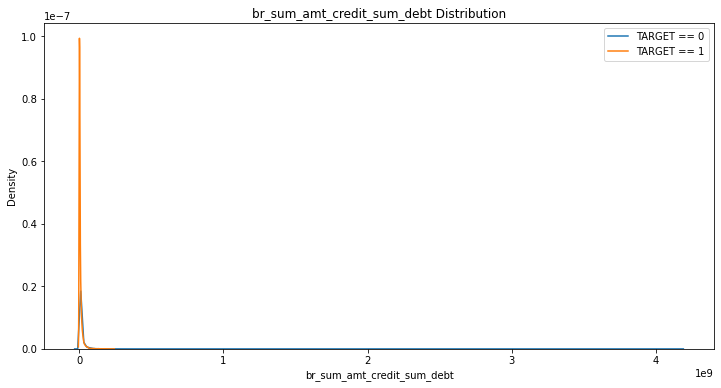

In [315]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [316]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [317]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                    0.005551
br_sum_amt_credit_sum_debt  0.005551                    1.000000

The correlation between br_sum_amt_credit_sum_debt and the TARGET is 0.0056
Median value for loan that was not repaid = -0.2306
Median value for loan that was repaid =     -0.2762


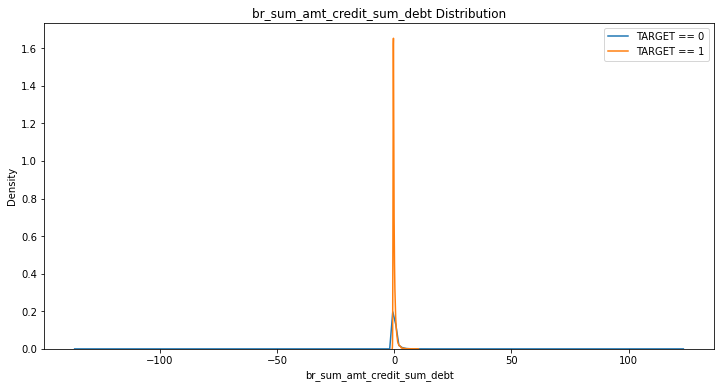

In [318]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [319]:
app_train.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)

### br_avg_amt_credit_sum_debt

In [320]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.00000                    -0.00128
br_avg_amt_credit_sum_debt -0.00128                     1.00000

The correlation between br_avg_amt_credit_sum_debt and the TARGET is -0.0013
Median value for loan that was not repaid = 69219.0000
Median value for loan that was repaid =     44812.0191


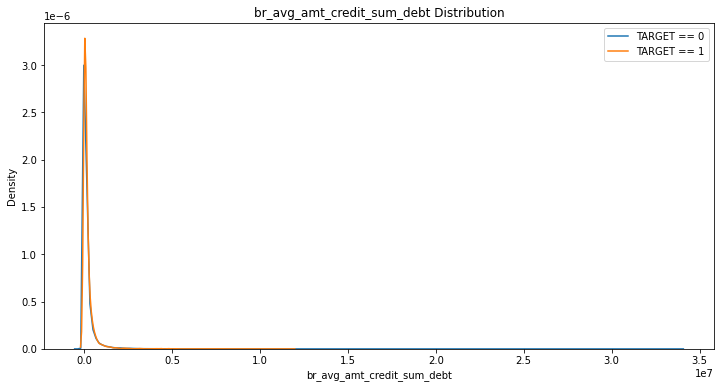

In [321]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [322]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [323]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                    0.006136
br_avg_amt_credit_sum_debt  0.006136                    1.000000

The correlation between br_avg_amt_credit_sum_debt and the TARGET is 0.0061
Median value for loan that was not repaid = -0.1776
Median value for loan that was repaid =     -0.2527


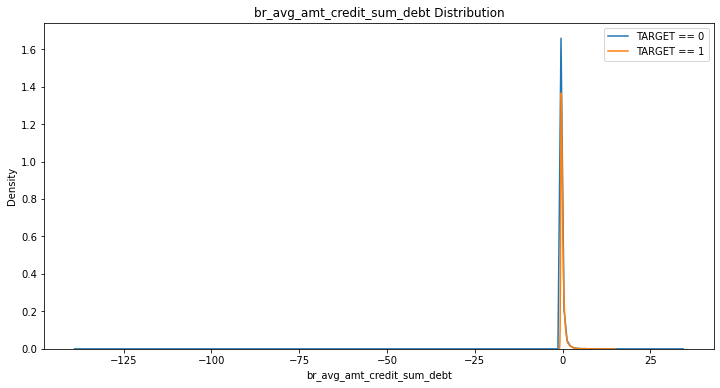

In [324]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [325]:
app_train.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)

### br_cnt_amt_credit_sum_debt

In [326]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.008634
br_cnt_amt_credit_sum_debt -0.008634                    1.000000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0086
Median value for loan that was not repaid = 29.0000
Median value for loan that was repaid =     31.0000


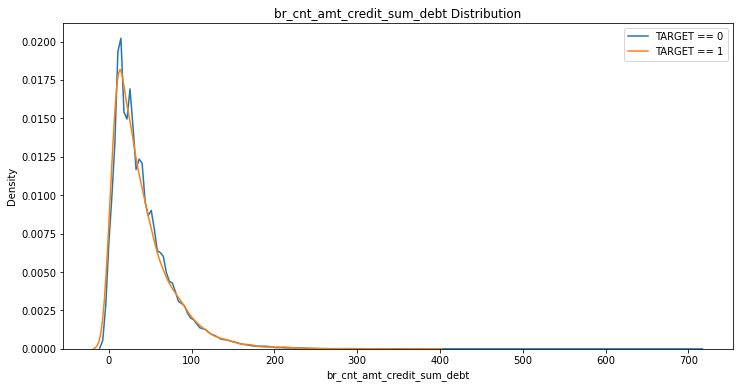

In [327]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

In [328]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [329]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.014367
br_cnt_amt_credit_sum_debt -0.014367                    1.000000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0144
Median value for loan that was not repaid = -0.0877
Median value for loan that was repaid =     -0.0176


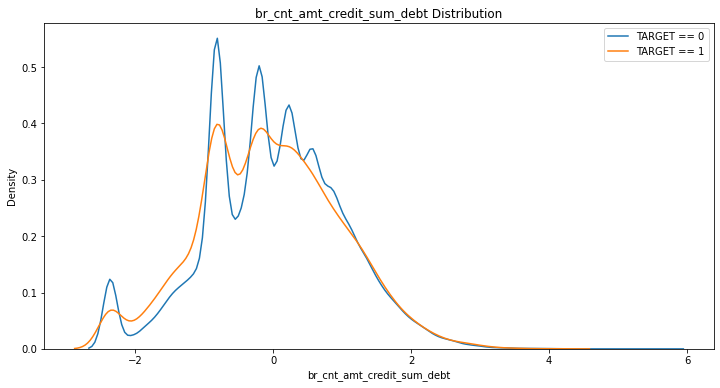

In [330]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

### br_stddev_amt_credit_sum_debt

In [331]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                      -0.000328
br_stddev_amt_credit_sum_debt -0.000328                       1.000000

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is -0.0003
Median value for loan that was not repaid = 54124.8120
Median value for loan that was repaid =     35397.5722


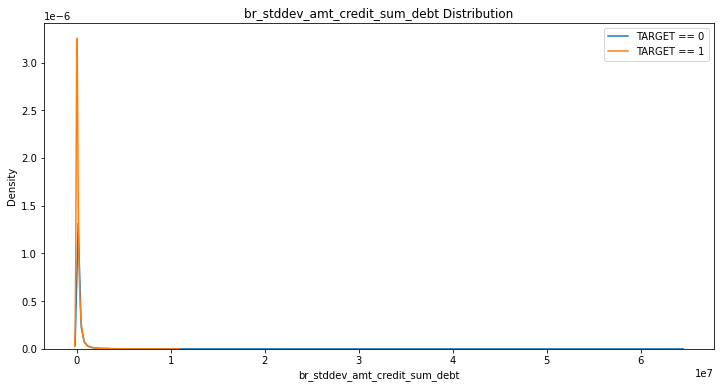

In [332]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [333]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [334]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                       0.030674
br_stddev_amt_credit_sum_debt  0.030674                       1.000000

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is 0.0307
Median value for loan that was not repaid = 0.5427
Median value for loan that was repaid =     0.4421


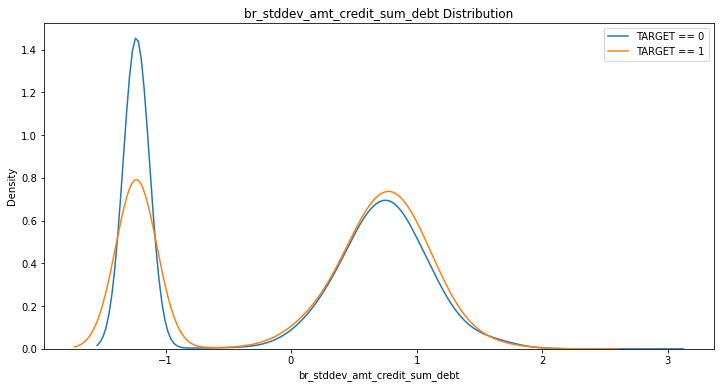

In [335]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

### br_stddev_pop_amt_credit_sum_debt

In [336]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

TARGET  br_stddev_pop_amt_credit_sum_debt
TARGET                             1.000000                          -0.000328
br_stddev_pop_amt_credit_sum_debt -0.000328                           1.000000

The correlation between br_stddev_pop_amt_credit_sum_debt and the TARGET is -0.0003
Median value for loan that was not repaid = 54124.8120
Median value for loan that was repaid =     35397.5722


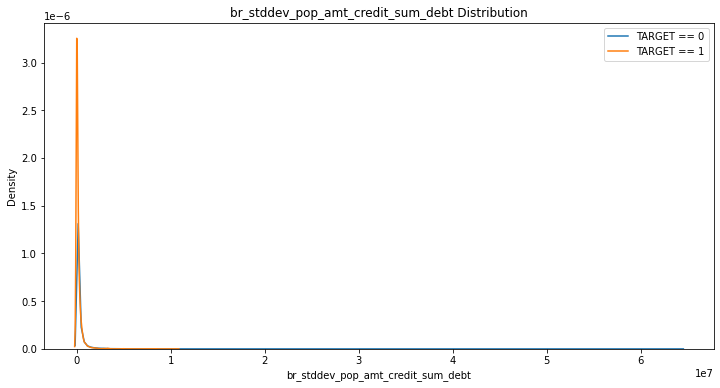

In [337]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [338]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [339]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.042469
br_sum_amt_credit_max_overdue  0.042469                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0425
Median value for loan that was not repaid = -0.4842
Median value for loan that was repaid =     -0.4842


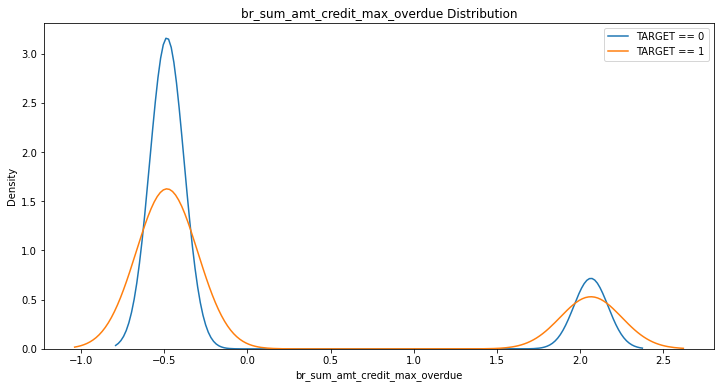

In [340]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_max_overdue', app_train)

### br_var_pop_amt_credit_sum_debt

In [341]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.00000                        -0.00186
br_var_pop_amt_credit_sum_debt -0.00186                         1.00000

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 2929495275.4645
Median value for loan that was repaid =     1252988121.9052


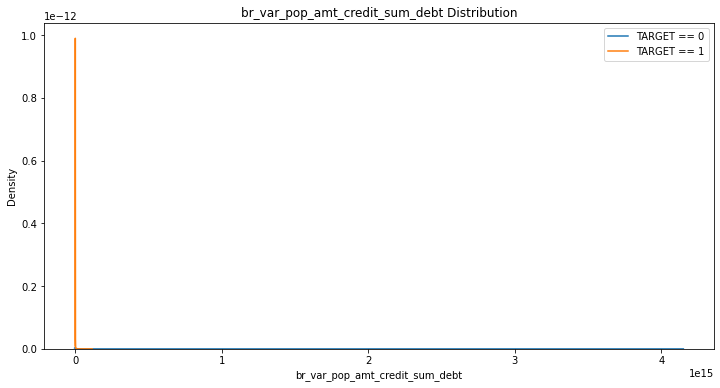

In [342]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [343]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [344]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.000000                        0.030673
br_var_pop_amt_credit_sum_debt  0.030673                        1.000000

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is 0.0307
Median value for loan that was not repaid = 0.5427
Median value for loan that was repaid =     0.4421


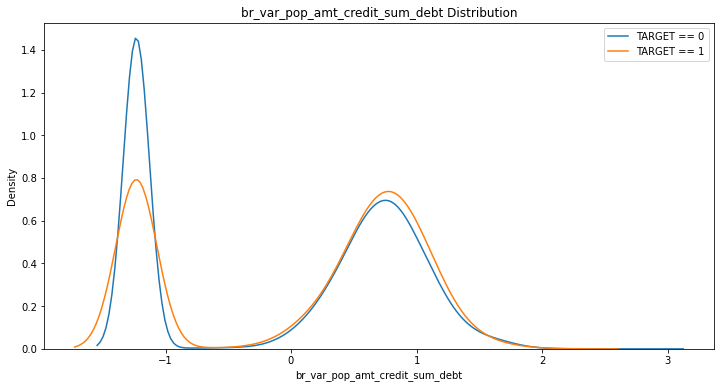

In [345]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

### br_var_samp_amt_credit_sum_debt

In [346]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                        -0.001885
br_var_samp_amt_credit_sum_debt -0.001885                         1.000000

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3009158199.1601
Median value for loan that was repaid =     1296189114.2238


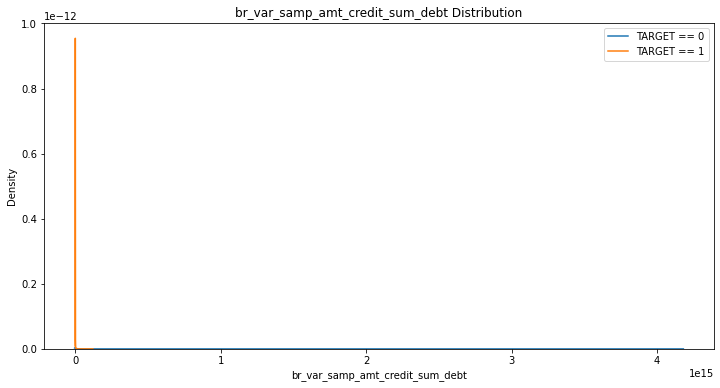

In [347]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [348]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [349]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                         0.030761
br_var_samp_amt_credit_sum_debt  0.030761                         1.000000

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is 0.0308
Median value for loan that was not repaid = 0.5424
Median value for loan that was repaid =     0.4426


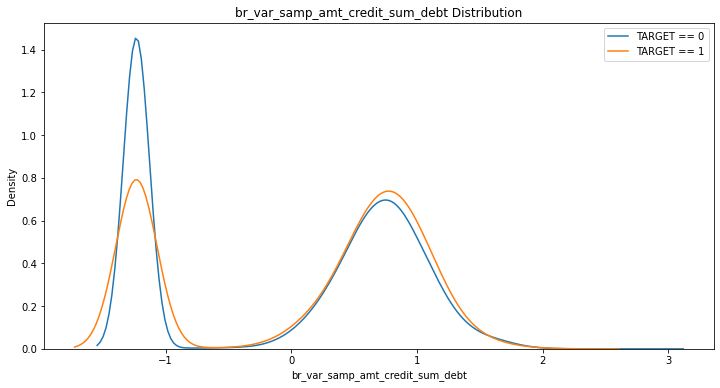

In [350]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

### br_variance_pop_amt_credit_sum_debt

In [351]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.00000   
br_variance_pop_amt_credit_sum_debt -0.00186   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                          -0.00186  
br_variance_pop_amt_credit_sum_debt                              1.00000

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 2929495275.4645
Median value for loan that was repaid =     1252988121.9052


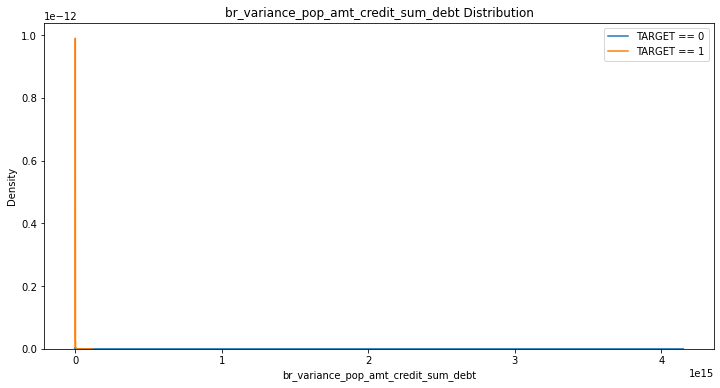

In [352]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [353]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [354]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_amt_credit_sum_debt  0.030673   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                          0.030673  
br_variance_pop_amt_credit_sum_debt                             1.000000

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is 0.0307
Median value for loan that was not repaid = 0.5427
Median value for loan that was repaid =     0.4421


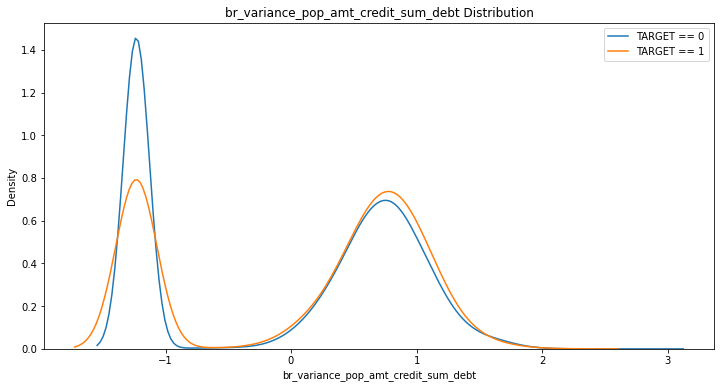

In [355]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

### br_min_amt_credit_sum_limit

In [356]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.004218
br_min_amt_credit_sum_limit -0.004218                     1.000000

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0042
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


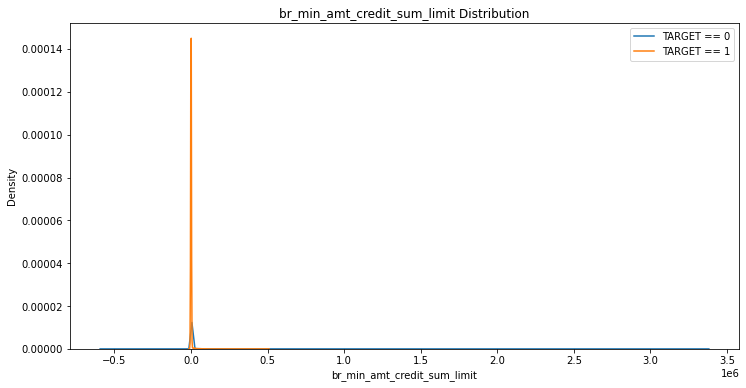

In [357]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [358]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [359]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.001814
br_min_amt_credit_sum_limit -0.001814                     1.000000

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0018
Median value for loan that was not repaid = -0.0429
Median value for loan that was repaid =     -0.0429


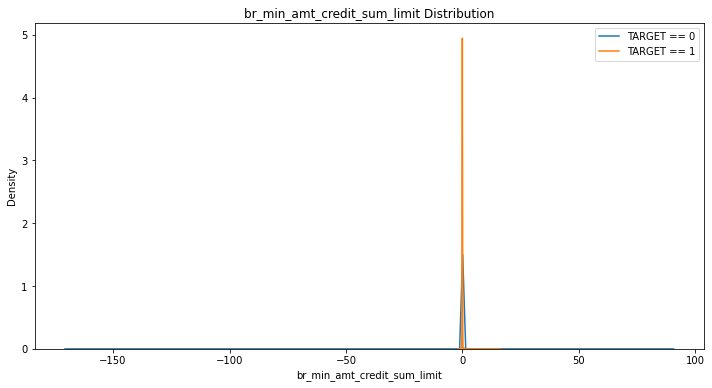

In [360]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [361]:
app_train.drop(['br_min_amt_credit_sum_limit'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_limit'], axis=1, inplace=True)

### br_max_amt_credit_sum_limit

In [362]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.012634
br_max_amt_credit_sum_limit -0.012634                     1.000000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0126
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


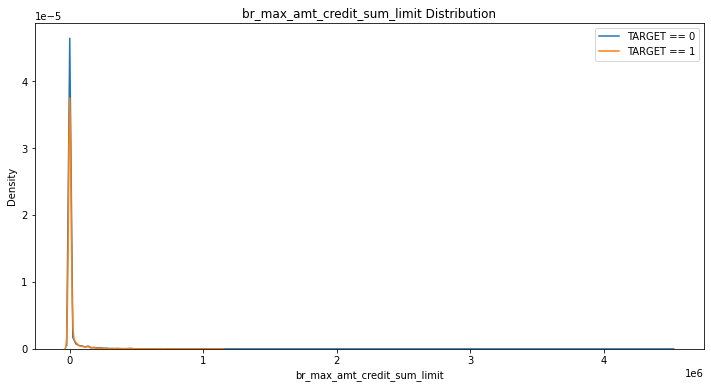

In [363]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

In [364]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [365]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [366]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum_limit', app_train)

### br_sum_amt_credit_sum_limit

In [367]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.014323
br_sum_amt_credit_sum_limit -0.014323                     1.000000

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0143
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


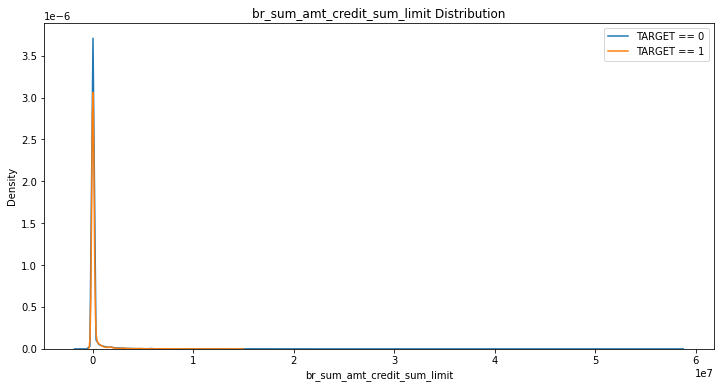

In [368]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

In [369]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [370]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

In [371]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_limit', app_train)

### br_avg_amt_credit_sum_limit

In [372]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

TARGET  br_avg_amt_credit_sum_limit
TARGET                       1.000000                    -0.011342
br_avg_amt_credit_sum_limit -0.011342                     1.000000

The correlation between br_avg_amt_credit_sum_limit and the TARGET is -0.0113
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


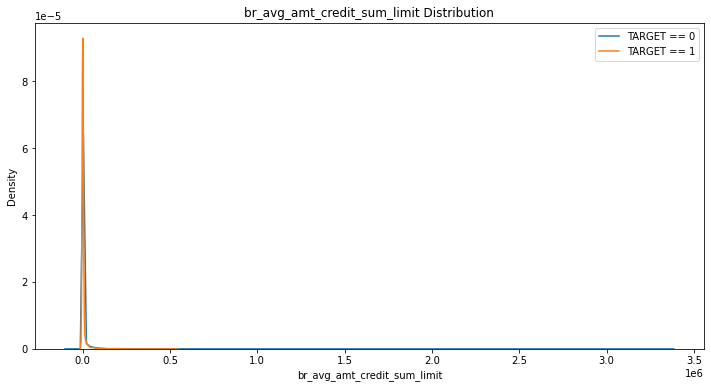

In [373]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_limit', app_train)

In [374]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [375]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [376]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_limit', app_train)

### br_cnt_amt_credit_sum_limit

In [377]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.008198
br_cnt_amt_credit_sum_limit -0.008198                     1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0082
Median value for loan that was not repaid = 23.0000
Median value for loan that was repaid =     25.0000


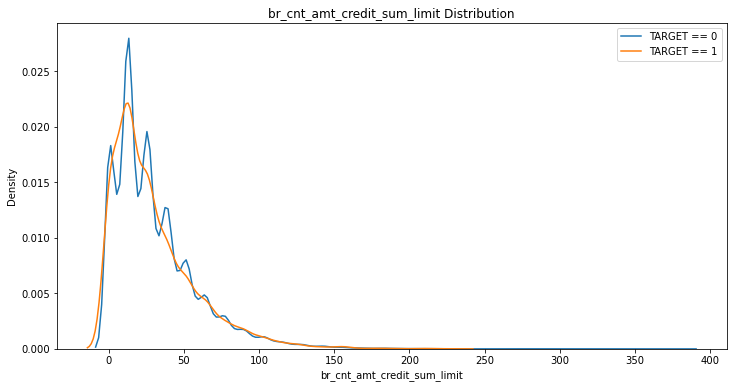

In [378]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

In [379]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [380]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.011385
br_cnt_amt_credit_sum_limit -0.011385                     1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0114
Median value for loan that was not repaid = 0.0191
Median value for loan that was repaid =     0.0988


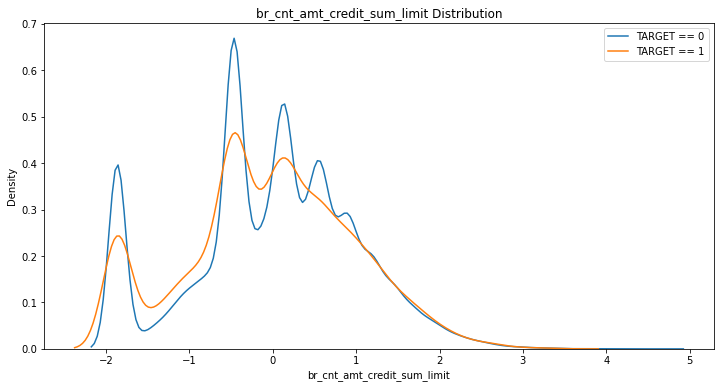

In [381]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

### br_stddev_amt_credit_sum_limit

In [382]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.00000                        -0.01273
br_stddev_amt_credit_sum_limit -0.01273                         1.00000

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is -0.0127
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


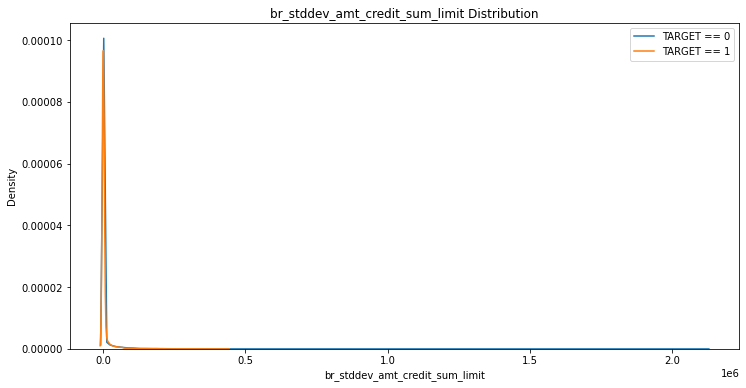

In [383]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [384]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [385]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.00000                         0.03642
br_stddev_amt_credit_sum_limit  0.03642                         1.00000

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4155
Median value for loan that was repaid =     -0.4155


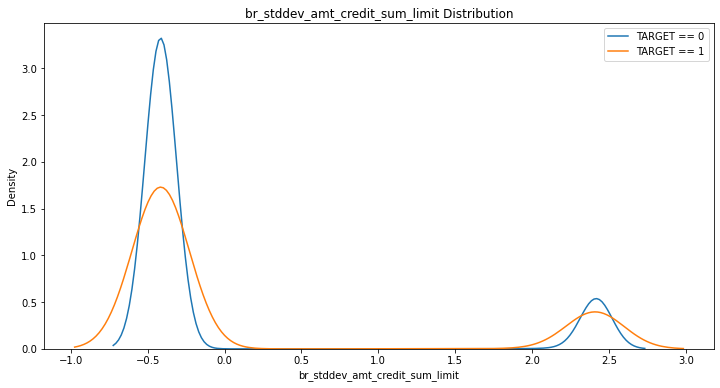

In [386]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

### br_stddev_pop_amt_credit_sum_limit

In [387]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.00000   
br_stddev_pop_amt_credit_sum_limit -0.01273   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                        -0.01273  
br_stddev_pop_amt_credit_sum_limit                             1.00000

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is -0.0127
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


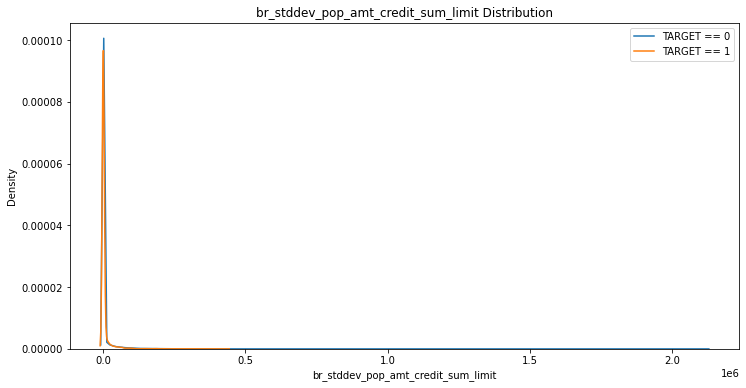

In [388]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [389]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [390]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.00000   
br_stddev_pop_amt_credit_sum_limit  0.03642   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                         0.03642  
br_stddev_pop_amt_credit_sum_limit                             1.00000

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4155
Median value for loan that was repaid =     -0.4155


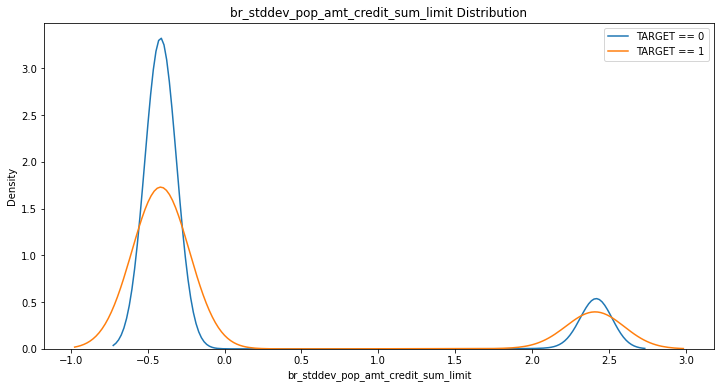

In [391]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

### br_var_pop_amt_credit_sum_limit

In [392]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.005846
br_var_pop_amt_credit_sum_limit -0.005846                         1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


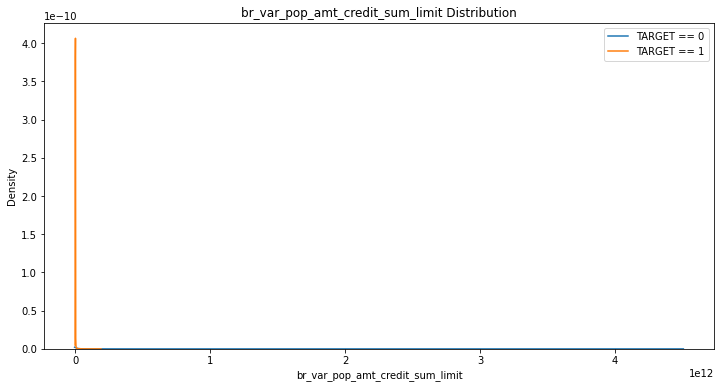

In [393]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

In [394]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [395]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                         0.036369
br_var_pop_amt_credit_sum_limit  0.036369                         1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4153
Median value for loan that was repaid =     -0.4153


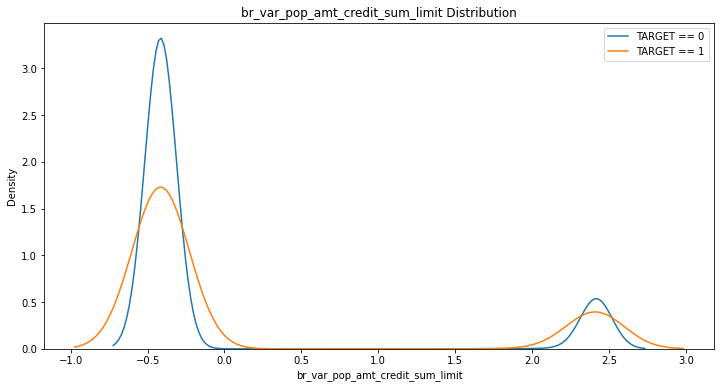

In [396]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

### br_var_samp_amt_credit_sum_limit

In [397]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.005811
br_var_samp_amt_credit_sum_limit -0.005811                          1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


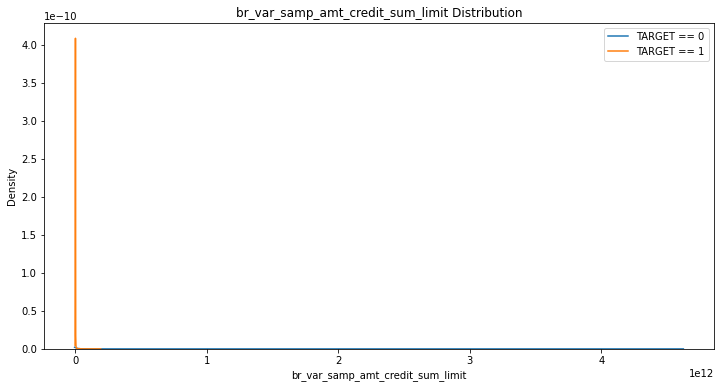

In [398]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

In [399]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [400]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                          0.036373
br_var_samp_amt_credit_sum_limit  0.036373                          1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4153
Median value for loan that was repaid =     -0.4153


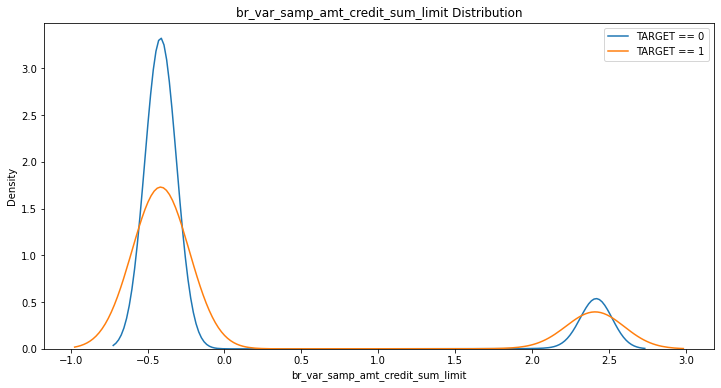

In [401]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

### br_variance_pop_amt_credit_sum_limit

In [402]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.005846   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.005846  
br_variance_pop_amt_credit_sum_limit                              1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


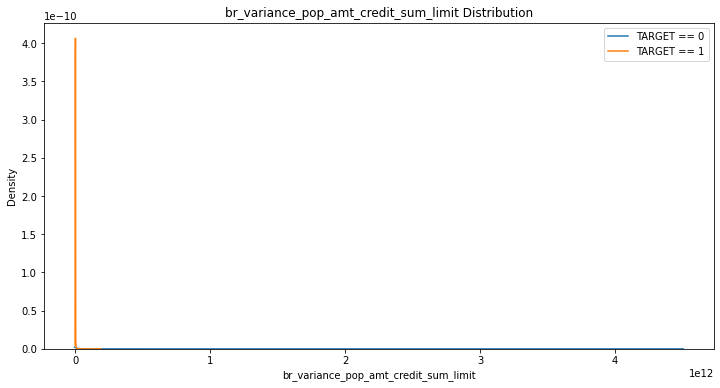

In [403]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

In [404]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [405]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit  0.036369   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                            0.036369  
br_variance_pop_amt_credit_sum_limit                              1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is 0.0364
Median value for loan that was not repaid = -0.4153
Median value for loan that was repaid =     -0.4153


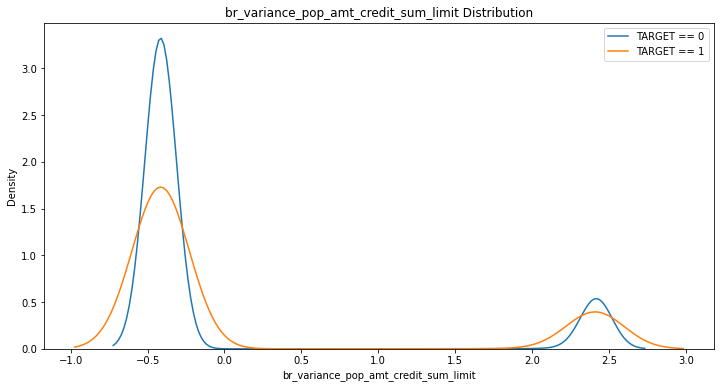

In [406]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

### br_min_amt_credit_sum_overdue

In [407]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.00000                       -0.00072
br_min_amt_credit_sum_overdue -0.00072                        1.00000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is -0.0007
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


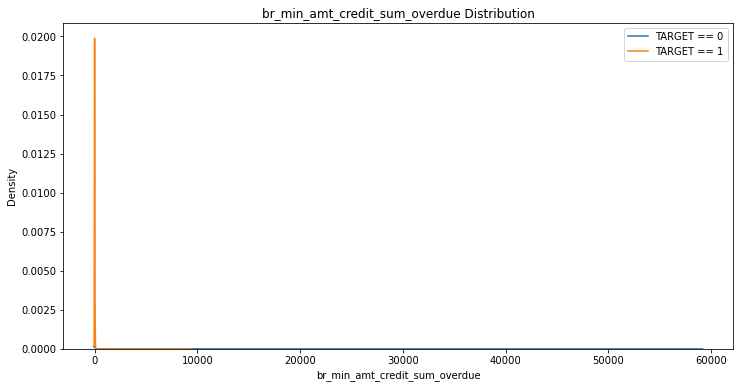

In [408]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [409]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [410]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.008968
br_min_amt_credit_sum_overdue  0.008968                       1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is 0.0090
Median value for loan that was not repaid = -0.0265
Median value for loan that was repaid =     -0.0265


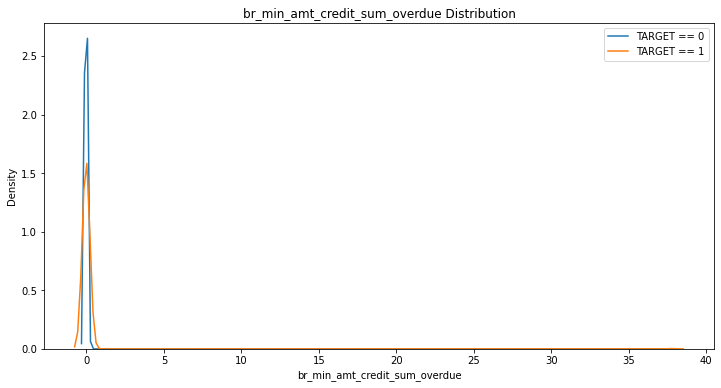

In [411]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [412]:
app_train.drop(['br_min_amt_credit_sum_overdue'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_overdue'], axis=1, inplace=True)

### br_max_amt_credit_sum_overdue

In [413]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.014796
br_max_amt_credit_sum_overdue  0.014796                       1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0148
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


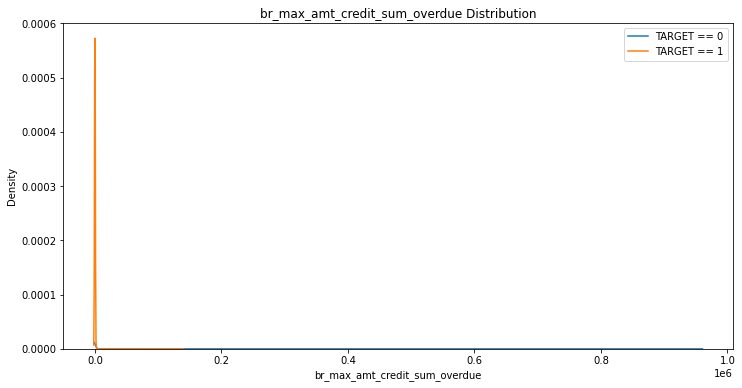

In [414]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

In [415]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [416]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.035663
br_max_amt_credit_sum_overdue  0.035663                       1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0357
Median value for loan that was not repaid = -0.1077
Median value for loan that was repaid =     -0.1077


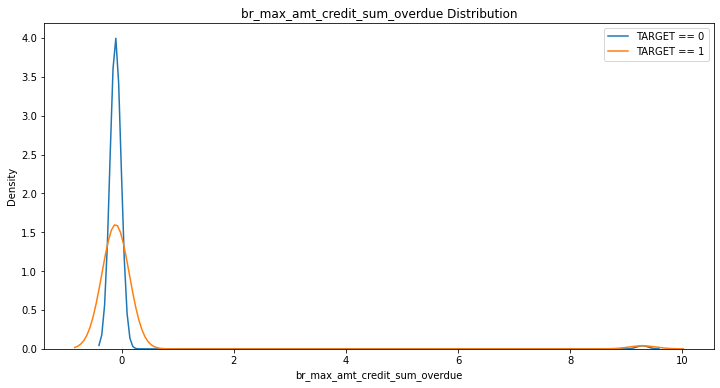

In [417]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

### br_sum_amt_credit_sum_overdue

In [418]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.007481
br_sum_amt_credit_sum_overdue  0.007481                       1.000000

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0075
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


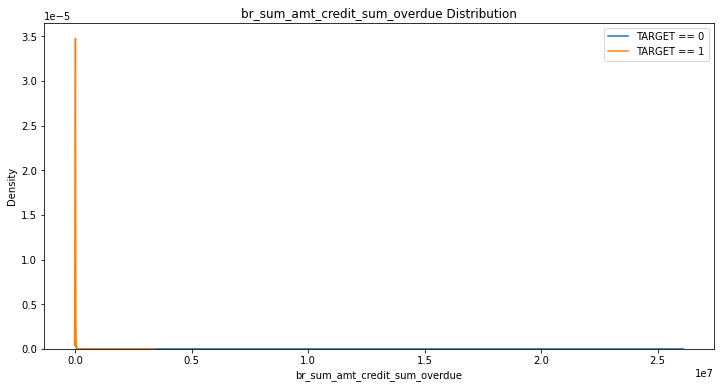

In [419]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [420]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [421]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.035661
br_sum_amt_credit_sum_overdue  0.035661                       1.000000

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0357
Median value for loan that was not repaid = -0.1077
Median value for loan that was repaid =     -0.1077


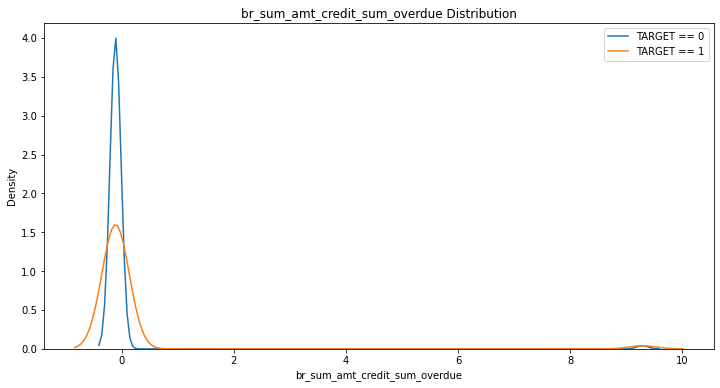

In [422]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

### br_avg_amt_credit_sum_overdue

In [423]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.020121
br_avg_amt_credit_sum_overdue  0.020121                       1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0201
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


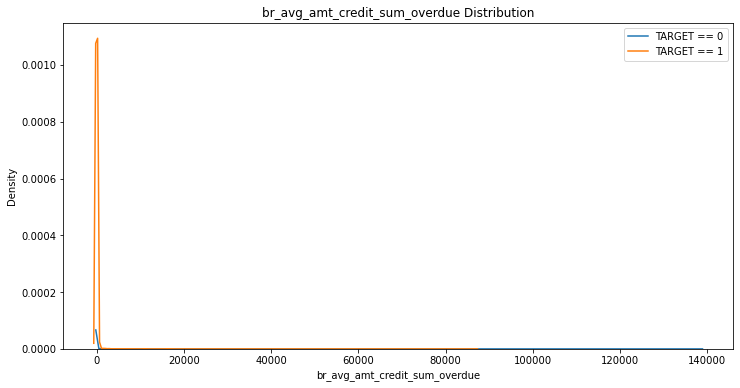

In [424]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

In [425]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [426]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.035732
br_avg_amt_credit_sum_overdue  0.035732                       1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0357
Median value for loan that was not repaid = -0.1077
Median value for loan that was repaid =     -0.1077


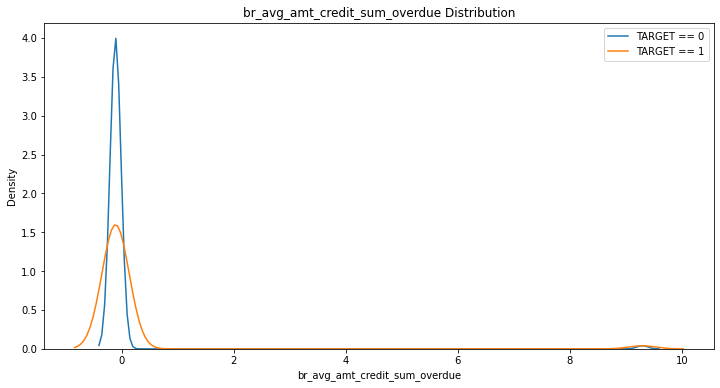

In [427]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

### br_cnt_amt_credit_sum_overdue

In [428]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.012242
br_cnt_amt_credit_sum_overdue -0.012242                       1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0122
Median value for loan that was not repaid = 35.0000
Median value for loan that was repaid =     38.0000


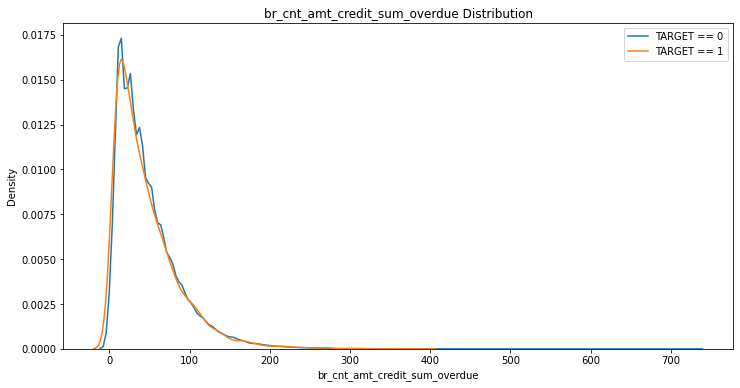

In [429]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

In [430]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [431]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.022992
br_cnt_amt_credit_sum_overdue -0.022992                       1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0230
Median value for loan that was not repaid = -0.0478
Median value for loan that was repaid =     0.0477


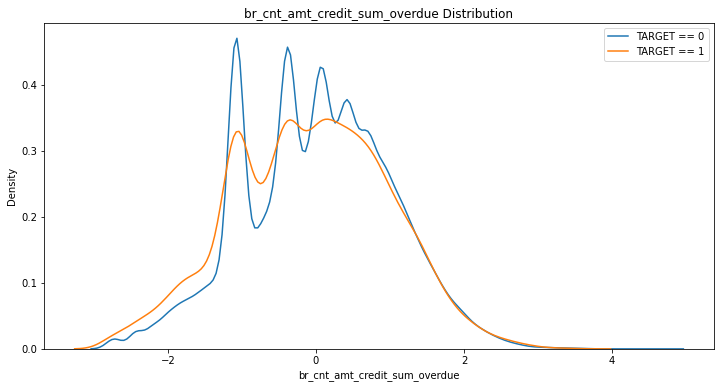

In [432]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

### br_stddev_amt_credit_sum_overdue

In [433]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.016705
br_stddev_amt_credit_sum_overdue  0.016705                          1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0167
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


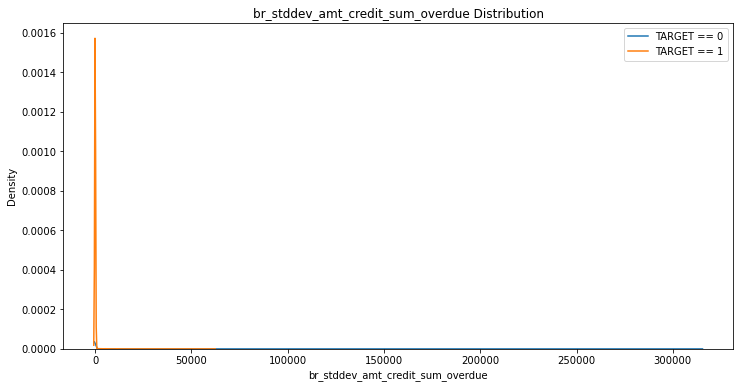

In [434]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

In [435]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [436]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.034505
br_stddev_amt_credit_sum_overdue  0.034505                          1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.1043
Median value for loan that was repaid =     -0.1043


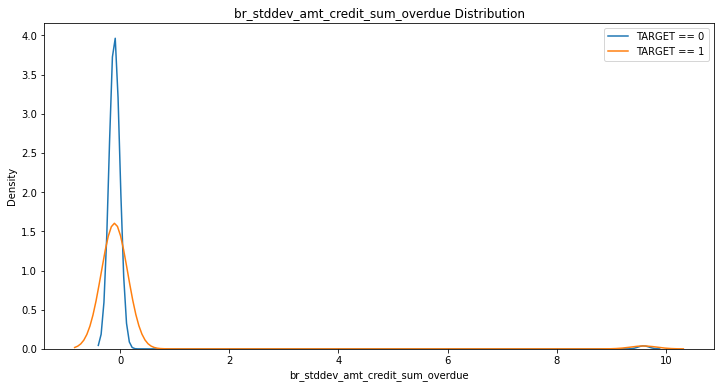

In [437]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

### br_stddev_pop_amt_credit_sum_overdue

In [438]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.016705   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.016705  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0167
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


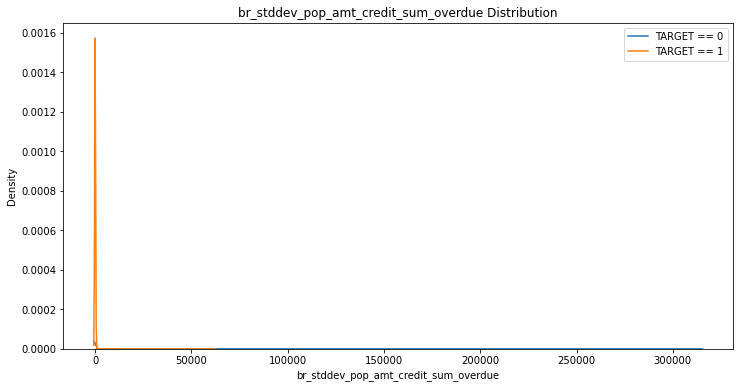

In [439]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

In [440]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [441]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.034505   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.034505  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0345
Median value for loan that was not repaid = -0.1043
Median value for loan that was repaid =     -0.1043


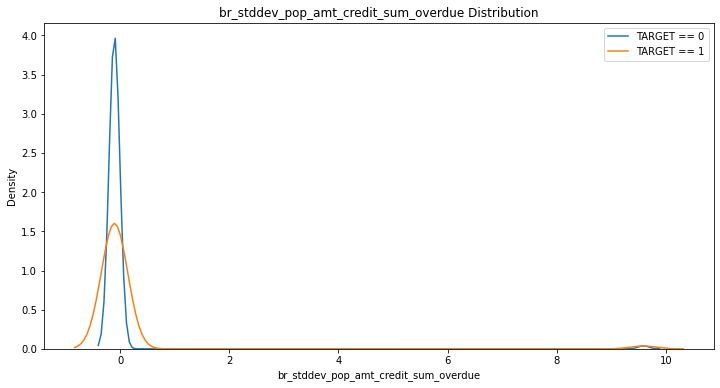

In [442]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

### br_var_pop_amt_credit_sum_overdue

In [443]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.000476
br_var_pop_amt_credit_sum_overdue  0.000476                           1.000000

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


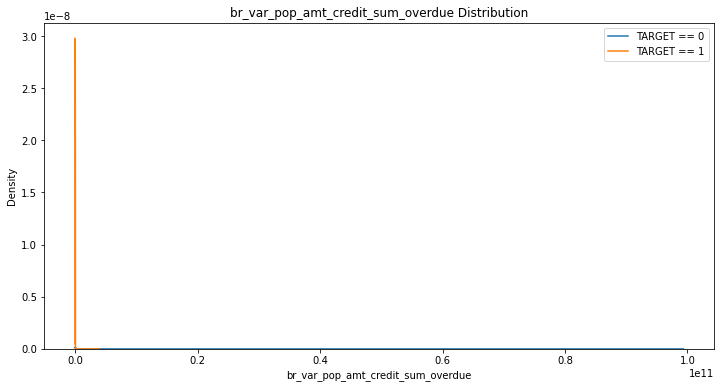

In [444]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [445]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [446]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.00000                            0.03458
br_var_pop_amt_credit_sum_overdue  0.03458                            1.00000

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0346
Median value for loan that was not repaid = -0.1042
Median value for loan that was repaid =     -0.1042


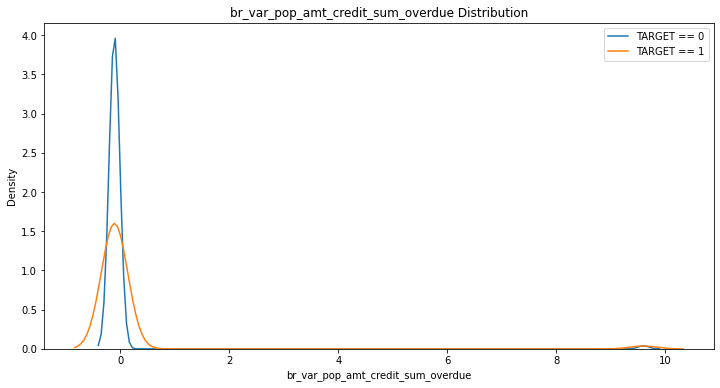

In [447]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

### br_var_samp_amt_credit_sum_overdue

In [448]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.000502   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.000502  
br_var_samp_amt_credit_sum_overdue                            1.000000

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


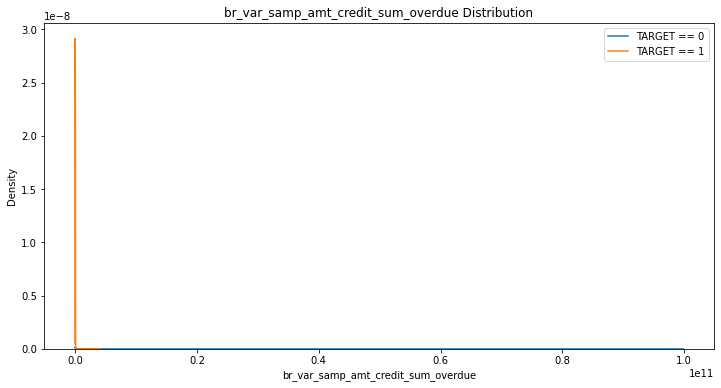

In [449]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [450]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [451]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.034579   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.034579  
br_var_samp_amt_credit_sum_overdue                            1.000000

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0346
Median value for loan that was not repaid = -0.1042
Median value for loan that was repaid =     -0.1042


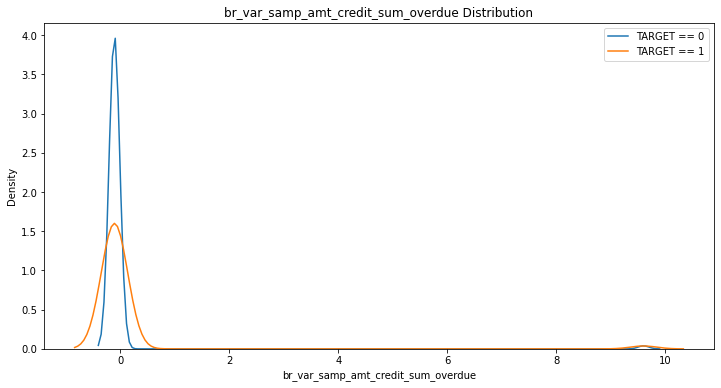

In [452]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

### br_variance_pop_amt_credit_sum_overdue

In [453]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_sum_overdue  0.000476   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                0.000476  
br_variance_pop_amt_credit_sum_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


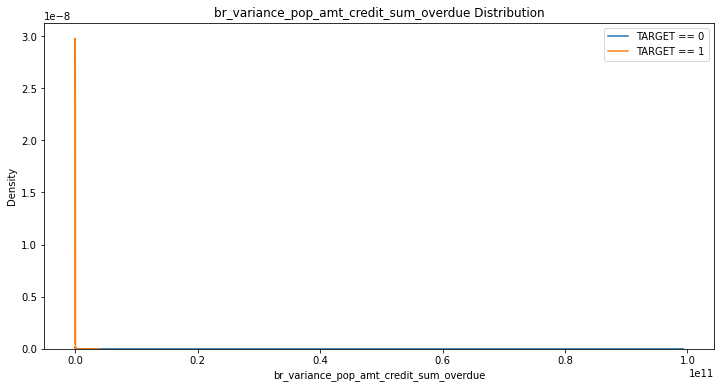

In [454]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [455]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [456]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.00000   
br_variance_pop_amt_credit_sum_overdue  0.03458   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                 0.03458  
br_variance_pop_amt_credit_sum_overdue                                 1.00000

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0346
Median value for loan that was not repaid = -0.1042
Median value for loan that was repaid =     -0.1042


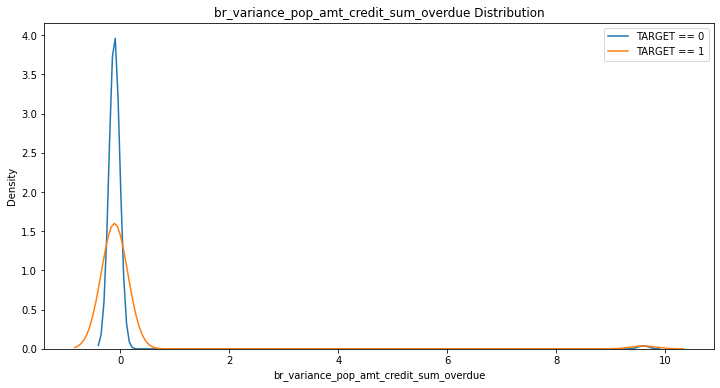

In [457]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

### br_min_days_credit_update

In [458]:
## 目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.050845
br_min_days_credit_update  0.050845                   1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0508
Median value for loan that was not repaid = -524.0000
Median value for loan that was repaid =     -726.0000


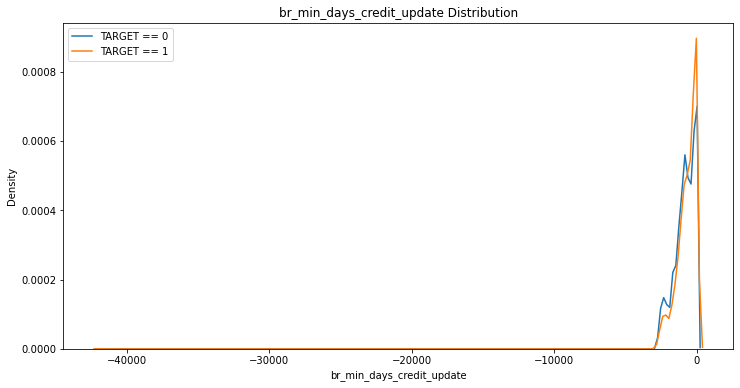

In [459]:
## 特徴量の分布
kde_target('br_min_days_credit_update', app_train)

In [460]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_update'] = pt.transform(app_test[num_cols])

In [461]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.060277
br_min_days_credit_update  0.060277                   1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0603
Median value for loan that was not repaid = 0.0989
Median value for loan that was repaid =     -0.1881


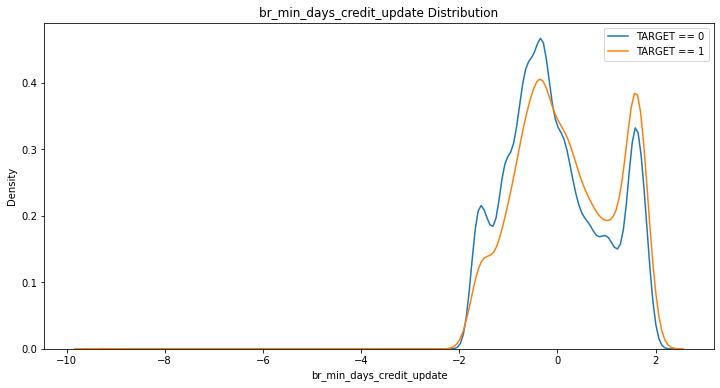

In [462]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_update', app_train)

### br_max_days_credit_update

In [463]:
## 目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.028488
br_max_days_credit_update  0.028488                   1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0285
Median value for loan that was not repaid = -14.0000
Median value for loan that was repaid =     -17.0000


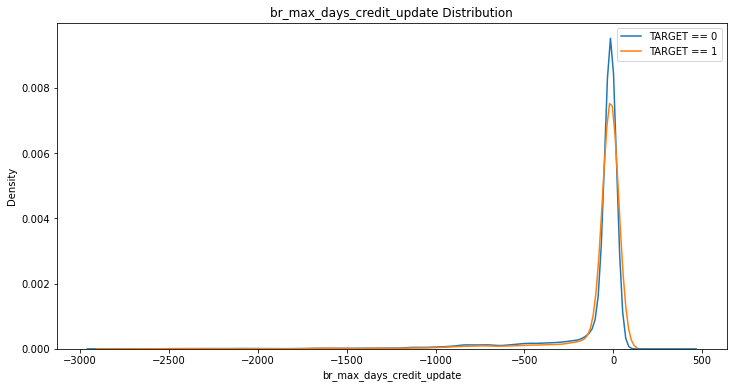

In [464]:
## 特徴量の分布
kde_target('br_max_days_credit_update', app_train)

In [465]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_update'] = pt.transform(app_test[num_cols])

In [466]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.032172
br_max_days_credit_update  0.032172                   1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0322
Median value for loan that was not repaid = 0.3652
Median value for loan that was repaid =     0.3308


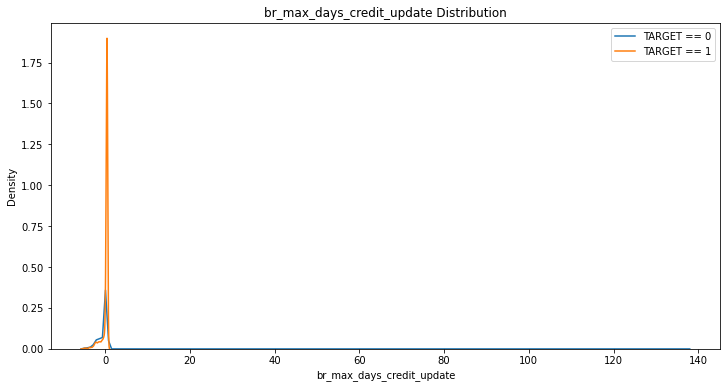

In [467]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_update', app_train)

### br_sum_days_credit_update

In [468]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.045285
br_sum_days_credit_update  0.045285                   1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0453
Median value for loan that was not repaid = -8548.0000
Median value for loan that was repaid =     -12825.0000


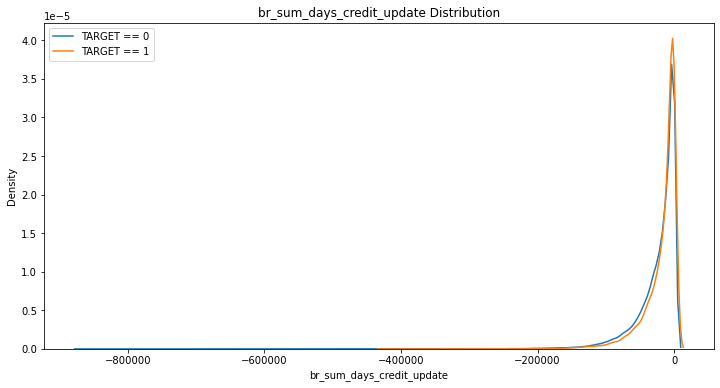

In [469]:
## 特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

In [470]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_update'] = pt.transform(app_test[num_cols])

In [471]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.058643
br_sum_days_credit_update  0.058643                   1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0586
Median value for loan that was not repaid = 0.1274
Median value for loan that was repaid =     -0.1128


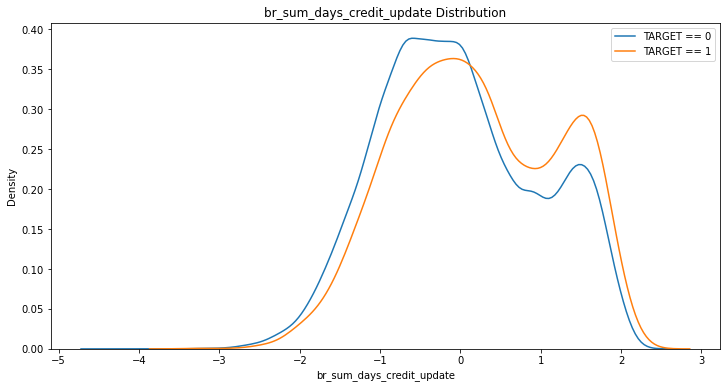

In [472]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

### br_avg_days_credit_update

In [473]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.057173
br_avg_days_credit_update  0.057173                   1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0572
Median value for loan that was not repaid = -224.3214
Median value for loan that was repaid =     -332.0000


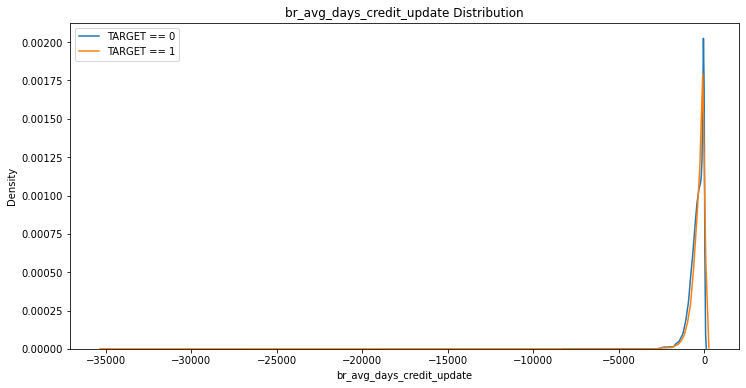

In [474]:
## 特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

In [475]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_update'] = pt.transform(app_test[num_cols])

In [476]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.069975
br_avg_days_credit_update  0.069975                   1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0700
Median value for loan that was not repaid = 0.1850
Median value for loan that was repaid =     -0.1476


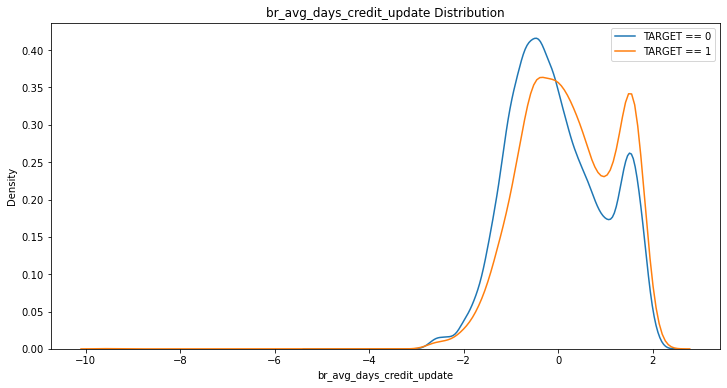

In [477]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

### br_cnt_days_credit_update

In [478]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.012242
br_cnt_days_credit_update -0.012242                   1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0122
Median value for loan that was not repaid = 35.0000
Median value for loan that was repaid =     38.0000


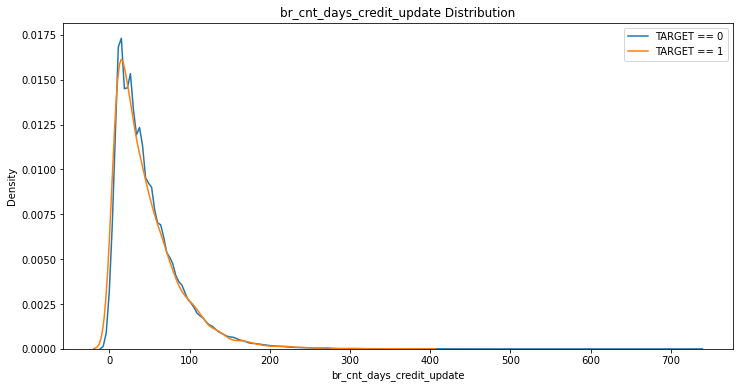

In [479]:
## 特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

In [480]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_update'] = pt.transform(app_test[num_cols])

In [481]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.022992
br_cnt_days_credit_update -0.022992                   1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0230
Median value for loan that was not repaid = -0.0478
Median value for loan that was repaid =     0.0477


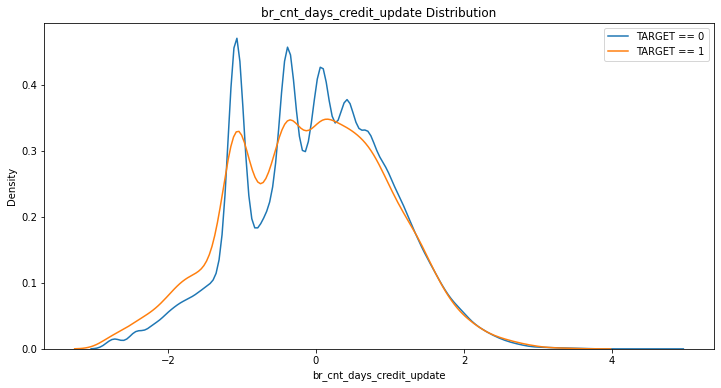

In [482]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

### br_stddev_days_credit_update

In [483]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.041842
br_stddev_days_credit_update -0.041842                      1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0418
Median value for loan that was not repaid = 162.5989
Median value for loan that was repaid =     223.3907


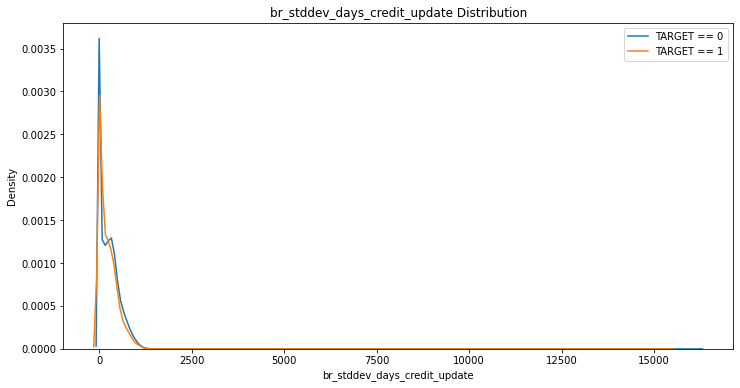

In [484]:
## 特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

In [485]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_credit_update'] = pt.transform(app_test[num_cols])

In [486]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.042454
br_stddev_days_credit_update -0.042454                      1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0425
Median value for loan that was not repaid = 0.0740
Median value for loan that was repaid =     0.2870


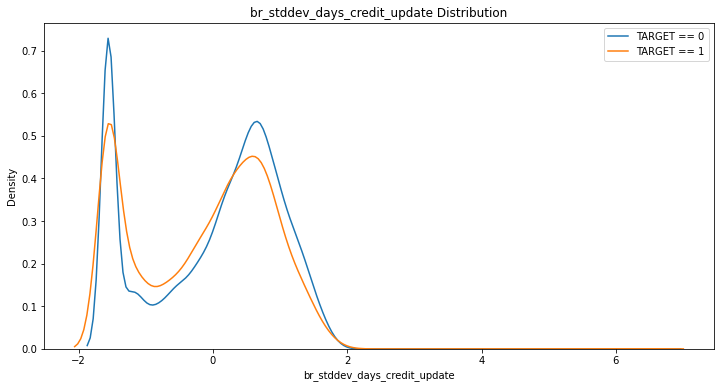

In [487]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

### br_stddev_pop_days_credit_update

In [488]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.041842
br_stddev_pop_days_credit_update -0.041842                          1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0418
Median value for loan that was not repaid = 162.5989
Median value for loan that was repaid =     223.3907


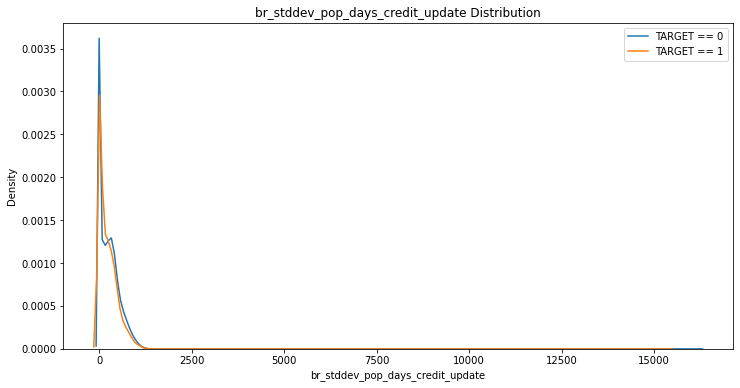

In [489]:
## 特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

In [490]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [491]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.042454
br_stddev_pop_days_credit_update -0.042454                          1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0425
Median value for loan that was not repaid = 0.0740
Median value for loan that was repaid =     0.2870


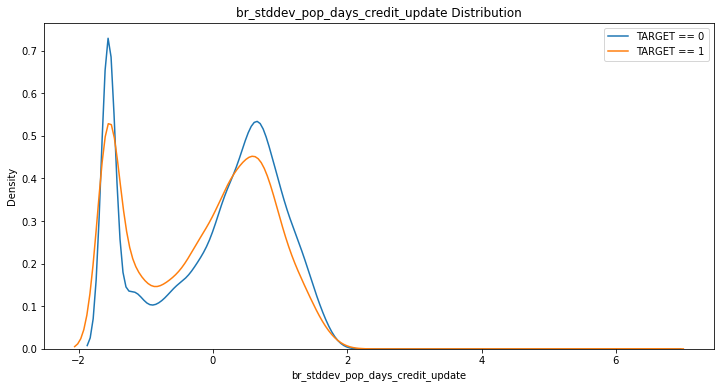

In [492]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

### br_var_pop_days_credit_update

In [493]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.001728
br_var_pop_days_credit_update -0.001728                       1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0017
Median value for loan that was not repaid = 26438.4024
Median value for loan that was repaid =     49903.3837


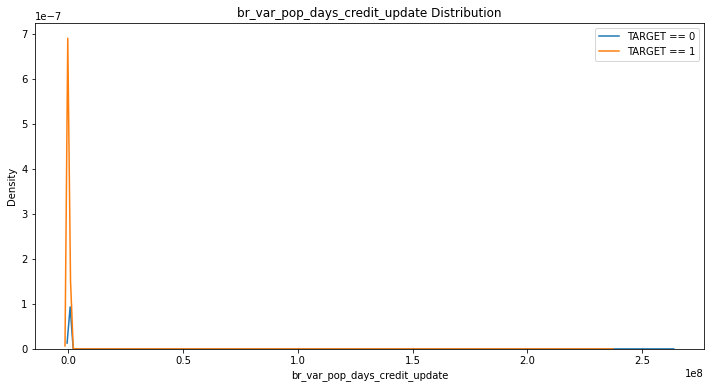

In [494]:
## 特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

In [495]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [496]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.042594
br_var_pop_days_credit_update -0.042594                       1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0426
Median value for loan that was not repaid = 0.0767
Median value for loan that was repaid =     0.2894


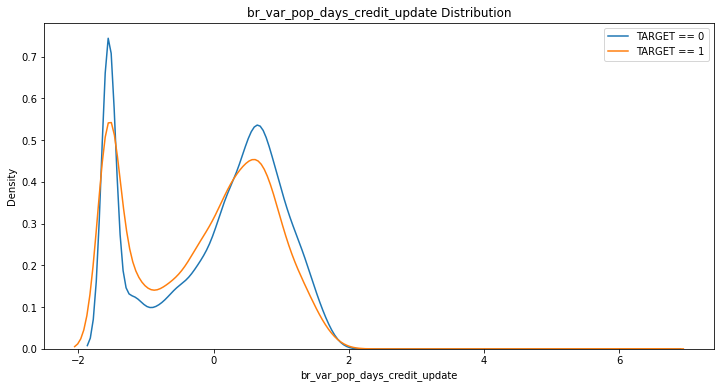

In [497]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

### br_var_samp_days_credit_update

In [498]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.001339
br_var_samp_days_credit_update -0.001339                        1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0013
Median value for loan that was not repaid = 27495.9385
Median value for loan that was repaid =     51223.4444


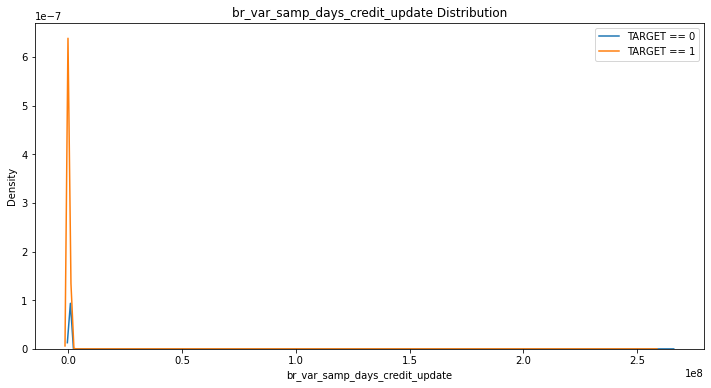

In [499]:
## 特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

In [500]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_credit_update'] = pt.transform(app_test[num_cols])

In [501]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.042566
br_var_samp_days_credit_update -0.042566                        1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0426
Median value for loan that was not repaid = 0.0807
Median value for loan that was repaid =     0.2897


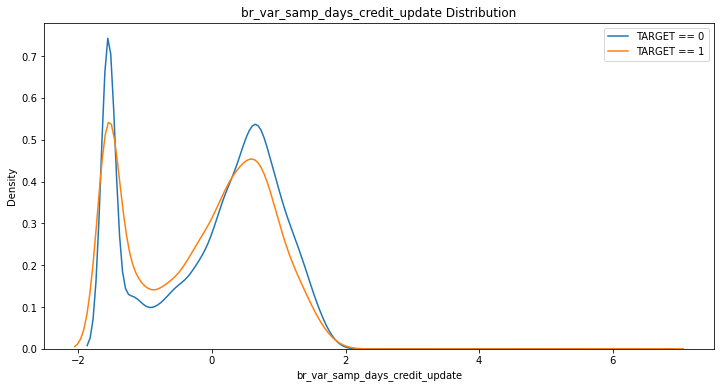

In [502]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

### br_variance_pop_days_credit_update

In [503]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.001728   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.001728  
br_variance_pop_days_credit_update                            1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0017
Median value for loan that was not repaid = 26438.4024
Median value for loan that was repaid =     49903.3837


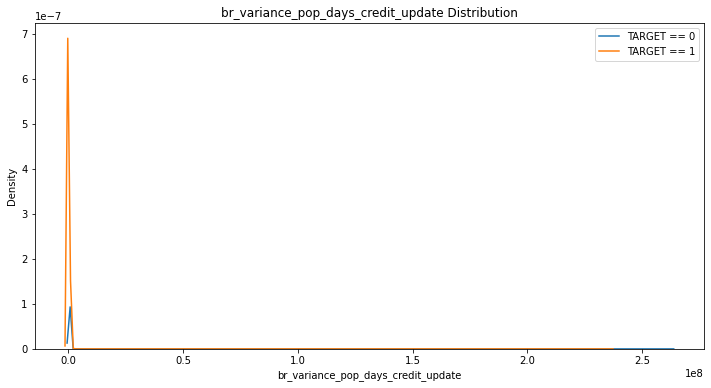

In [504]:
## 特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

In [505]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [506]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.042594   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.042594  
br_variance_pop_days_credit_update                            1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0426
Median value for loan that was not repaid = 0.0767
Median value for loan that was repaid =     0.2894


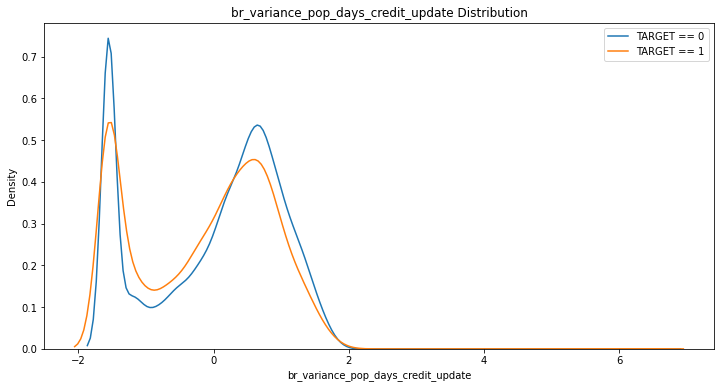

In [507]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

### br_min_amt_annuity

In [508]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.000000           -0.001827
br_min_amt_annuity -0.001827            1.000000

The correlation between br_min_amt_annuity and the TARGET is -0.0018
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


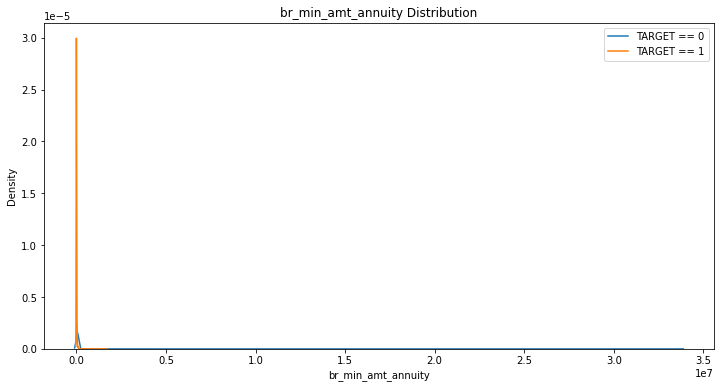

In [509]:
## 特徴量の分布
kde_target('br_min_amt_annuity', app_train)

In [510]:
## Yao-Johnson変換
num_cols = ['br_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_annuity'] = pt.transform(app_test[num_cols])

In [511]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.000000            0.036562
br_min_amt_annuity  0.036562            1.000000

The correlation between br_min_amt_annuity and the TARGET is 0.0366
Median value for loan that was not repaid = -0.8466
Median value for loan that was repaid =     -0.8466


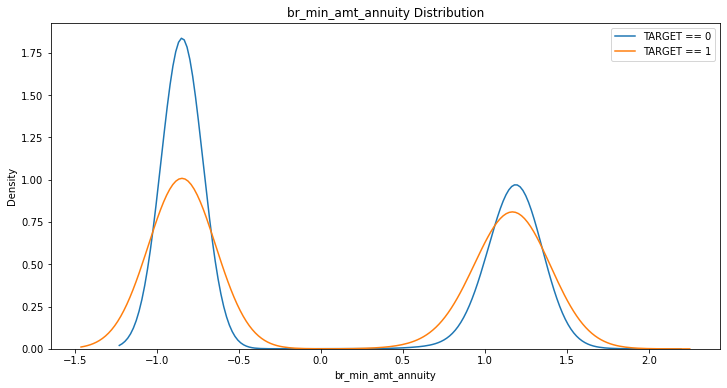

In [512]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_annuity', app_train)

### br_max_amt_annuity

In [513]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.005153
br_max_amt_annuity  0.005153            1.000000

The correlation between br_max_amt_annuity and the TARGET is 0.0052
Median value for loan that was not repaid = 7964.9100
Median value for loan that was repaid =     7551.0000


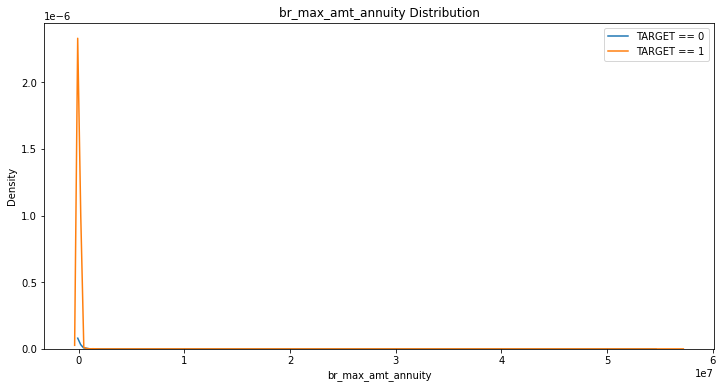

In [514]:
## 特徴量の分布
kde_target('br_max_amt_annuity', app_train)

In [515]:
## Yao-Johnson変換
num_cols = ['br_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_annuity'] = pt.transform(app_test[num_cols])

In [516]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.029218
br_max_amt_annuity  0.029218            1.000000

The correlation between br_max_amt_annuity and the TARGET is 0.0292
Median value for loan that was not repaid = 0.3539
Median value for loan that was repaid =     0.3342


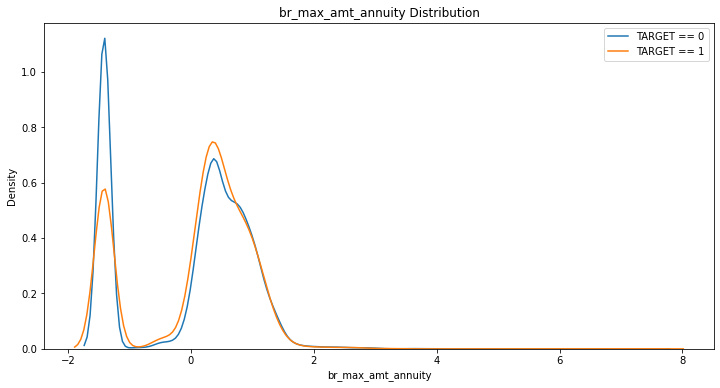

In [517]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_annuity', app_train)

### br_sum_amt_annuity

In [518]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000            0.000744
br_sum_amt_annuity  0.000744            1.000000

The correlation between br_sum_amt_annuity and the TARGET is 0.0007
Median value for loan that was not repaid = 80417.2050
Median value for loan that was repaid =     58500.0000


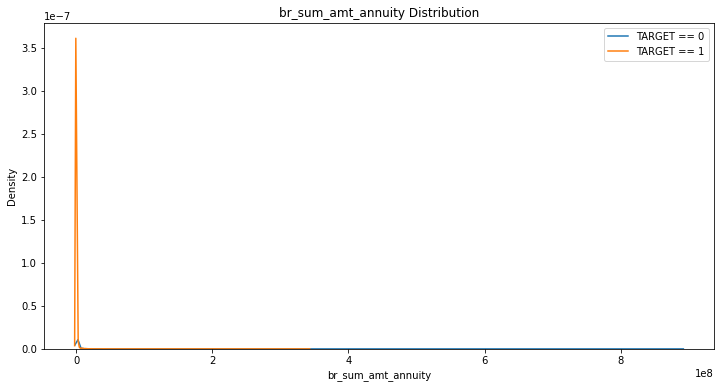

In [519]:
## 特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

In [520]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_annuity'] = pt.transform(app_test[num_cols])

In [521]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000            0.034689
br_sum_amt_annuity  0.034689            1.000000

The correlation between br_sum_amt_annuity and the TARGET is 0.0347
Median value for loan that was not repaid = 0.5645
Median value for loan that was repaid =     0.4987


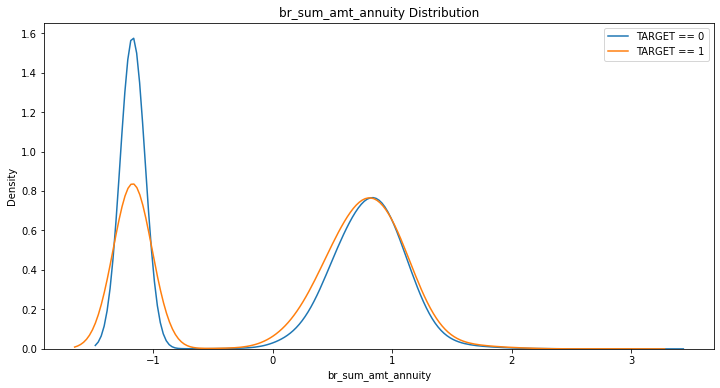

In [522]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

### br_avg_amt_annuity

In [523]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000           -0.000011
br_avg_amt_annuity -0.000011            1.000000

The correlation between br_avg_amt_annuity and the TARGET is -0.0000
Median value for loan that was not repaid = 2786.0294
Median value for loan that was repaid =     1703.7382


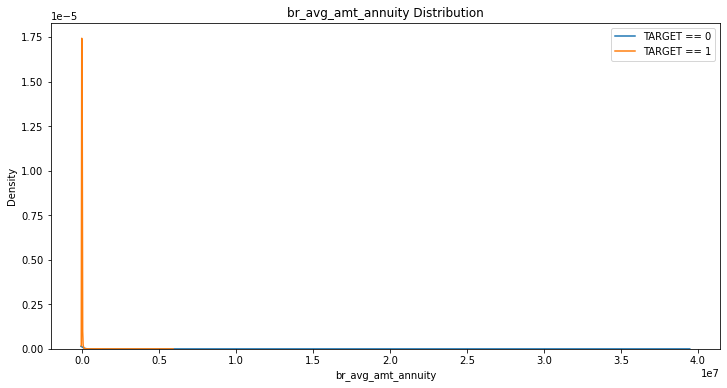

In [524]:
## 特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

In [525]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_annuity'] = pt.transform(app_test[num_cols])

In [526]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000            0.037262
br_avg_amt_annuity  0.037262            1.000000

The correlation between br_avg_amt_annuity and the TARGET is 0.0373
Median value for loan that was not repaid = 0.5651
Median value for loan that was repaid =     0.4338


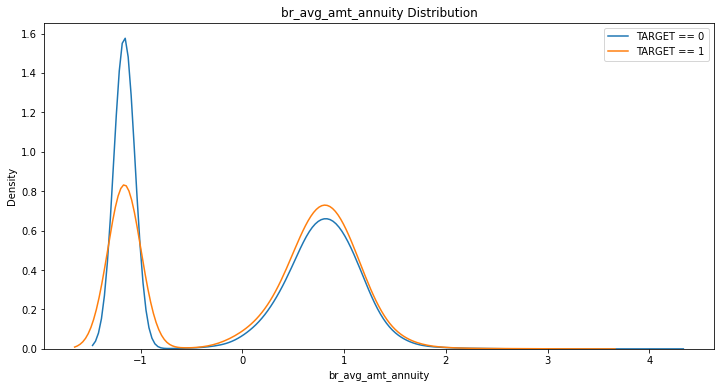

In [527]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

### br_cnt_amt_annuity

In [533]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.012242
br_cnt_amt_annuity -0.012242            1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0122
Median value for loan that was not repaid = 35.0000
Median value for loan that was repaid =     38.0000


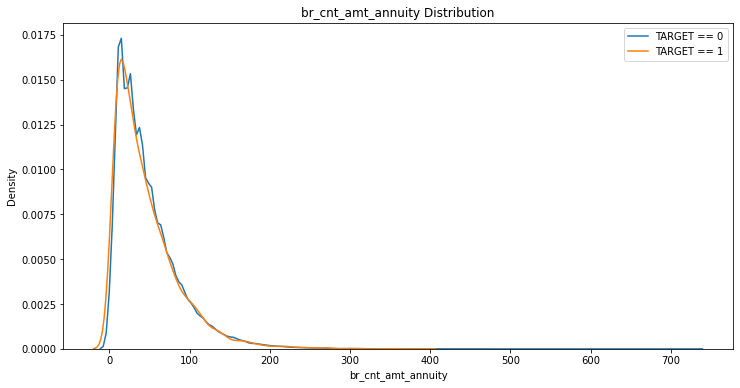

In [534]:
## 特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

In [535]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

In [536]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.022992
br_cnt_amt_annuity -0.022992            1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0230
Median value for loan that was not repaid = -0.0478
Median value for loan that was repaid =     0.0477


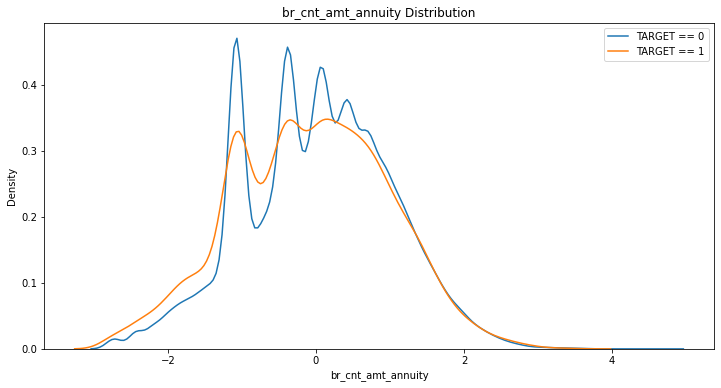

In [537]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

### br_stddev_amt_annuity

In [538]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.003142
br_stddev_amt_annuity  0.003142               1.000000

The correlation between br_stddev_amt_annuity and the TARGET is 0.0031
Median value for loan that was not repaid = 1012.5666
Median value for loan that was repaid =     0.0000


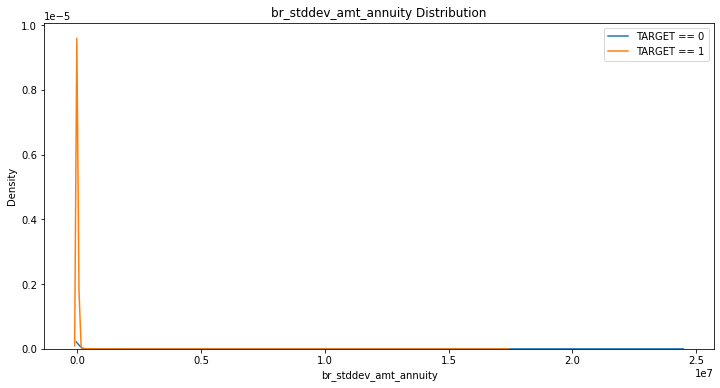

In [539]:
## 特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

In [540]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

In [541]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.00000                0.02793
br_stddev_amt_annuity  0.02793                1.00000

The correlation between br_stddev_amt_annuity and the TARGET is 0.0279
Median value for loan that was not repaid = 0.6991
Median value for loan that was repaid =     -0.9406


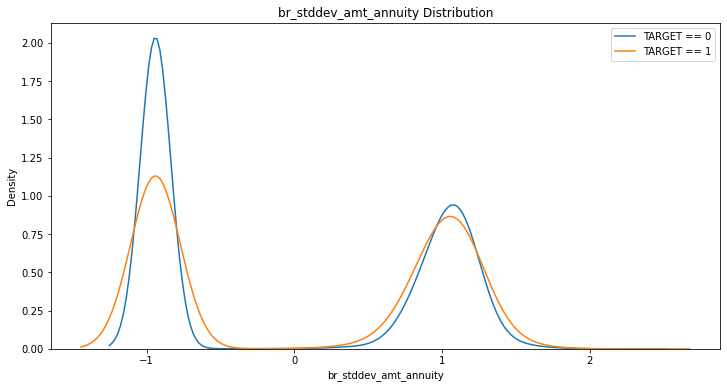

In [542]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

### br_stddev_pop_amt_annuity

In [543]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.003142
br_stddev_pop_amt_annuity  0.003142                   1.000000

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0031
Median value for loan that was not repaid = 1012.5666
Median value for loan that was repaid =     0.0000


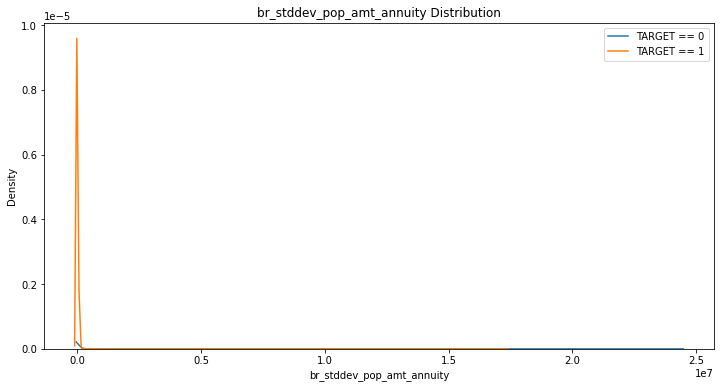

In [544]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

In [545]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [546]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.00000                    0.02793
br_stddev_pop_amt_annuity  0.02793                    1.00000

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0279
Median value for loan that was not repaid = 0.6991
Median value for loan that was repaid =     -0.9406


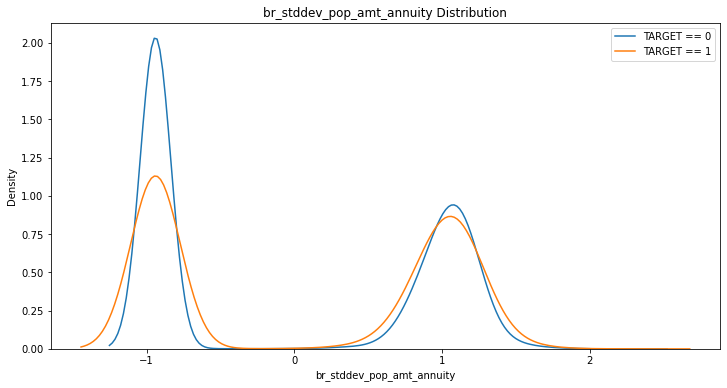

In [547]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

### br_var_pop_amt_annuity

In [548]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.002768
br_var_pop_amt_annuity  0.002768                1.000000

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0028
Median value for loan that was not repaid = 1025291.0884
Median value for loan that was repaid =     0.0000


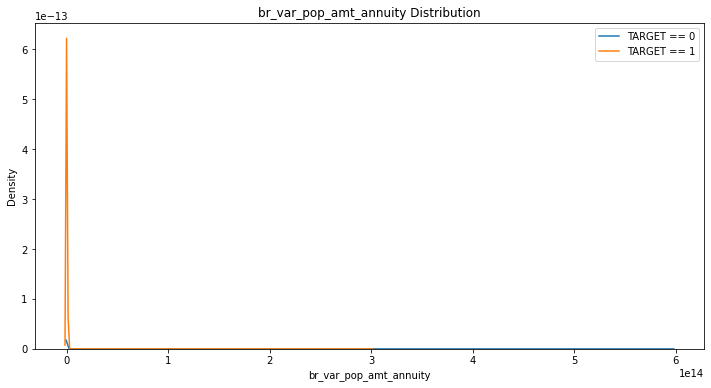

In [549]:
## 特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

In [550]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [551]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.027923
br_var_pop_amt_annuity  0.027923                1.000000

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0279
Median value for loan that was not repaid = 0.6991
Median value for loan that was repaid =     -0.9405


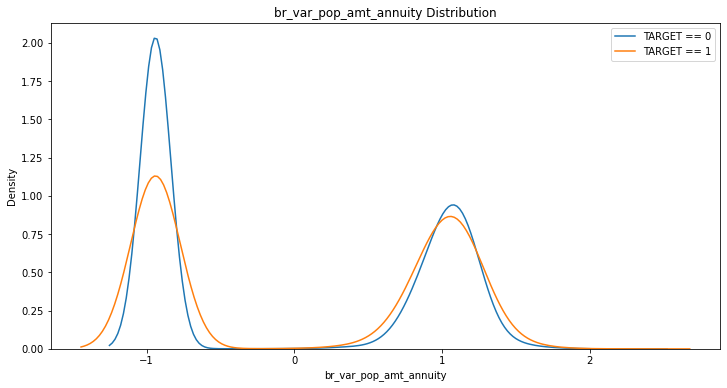

In [552]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

### br_var_samp_amt_annuity

In [553]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.002664
br_var_samp_amt_annuity  0.002664                 1.000000

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0027
Median value for loan that was not repaid = 1056774.1935
Median value for loan that was repaid =     0.0000


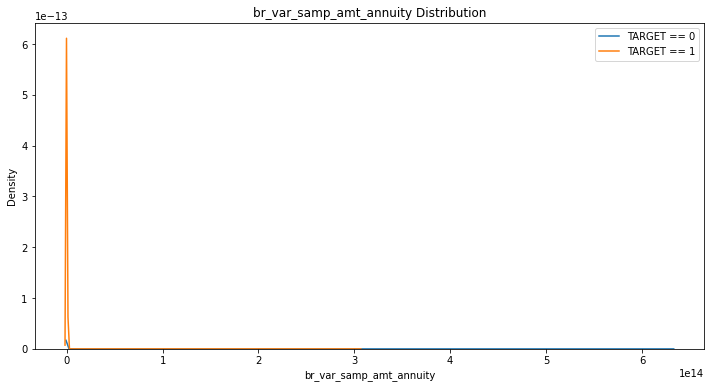

In [554]:
## 特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

In [555]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

In [556]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.027969
br_var_samp_amt_annuity  0.027969                 1.000000

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0280
Median value for loan that was not repaid = 0.6999
Median value for loan that was repaid =     -0.9405


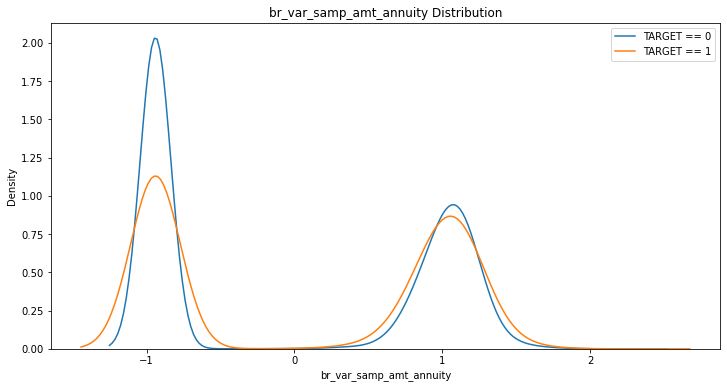

In [557]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

### br_variance_pop_amt_annuity

In [558]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.002768
br_variance_pop_amt_annuity  0.002768                     1.000000

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0028
Median value for loan that was not repaid = 1025291.0884
Median value for loan that was repaid =     0.0000


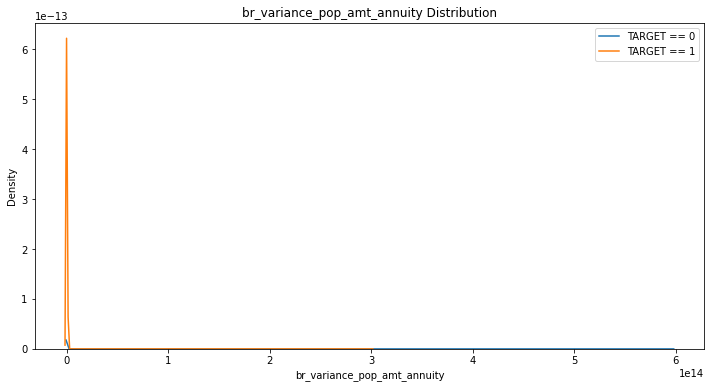

In [559]:
## 特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [560]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [561]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.027923
br_variance_pop_amt_annuity  0.027923                     1.000000

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0279
Median value for loan that was not repaid = 0.6991
Median value for loan that was repaid =     -0.9405


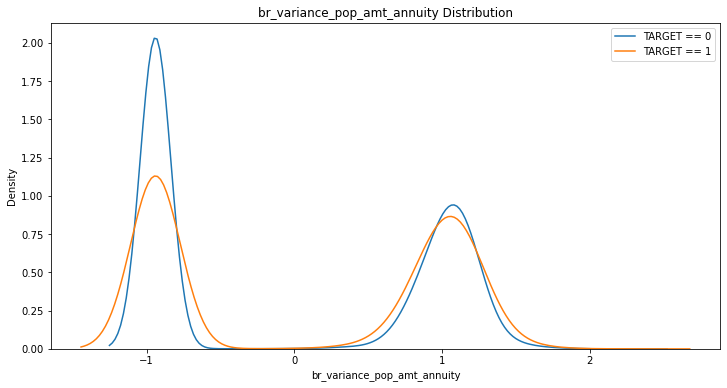

In [562]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [563]:
## CSVをEXPORT

In [564]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_train.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [565]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_test.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [566]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [567]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [568]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[21:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.55068	eval-auc:0.54144
[1]	train-auc:0.55850	eval-auc:0.54493
[2]	train-auc:0.56642	eval-auc:0.54488
[3]	train-auc:0.56854	eval-auc:0.54432
[4]	train-auc:0.57296	eval-auc:0.54480
[5]	train-auc:0.57496	eval-auc:0.54383
[6]	train-auc:0.57769	eval-auc:0.54562
[7]	train-auc:0.58109	eval-auc:0.54796
[8]	train-auc:0.58331	eval-auc:0.54790
[9]	train-auc:0.58480	eval-auc:0.54856
[10]	train-auc:0.58654	eval-auc:0.54871
[11]	train-auc:0.58761	eval-auc:0.54862
[12]	train-auc:0.58926	eval-auc:0.54771
[13]	train-auc:0.59178	eval-auc:0.54754
[14

[12]	train-auc:0.59065	eval-auc:0.54699
[13]	train-auc:0.59200	eval-auc:0.54685
[14]	train-auc:0.59256	eval-auc:0.54749
[15]	train-auc:0.59426	eval-auc:0.54799
[16]	train-auc:0.59655	eval-auc:0.55109
[17]	train-auc:0.59802	eval-auc:0.55052
[18]	train-auc:0.60095	eval-auc:0.55184
[19]	train-auc:0.60182	eval-auc:0.55071
[20]	train-auc:0.60219	eval-auc:0.55125
[21]	train-auc:0.60407	eval-auc:0.55130
[22]	train-auc:0.60611	eval-auc:0.55153
[23]	train-auc:0.60768	eval-auc:0.55063
[24]	train-auc:0.60812	eval-auc:0.55238
[25]	train-auc:0.60936	eval-auc:0.55168
[26]	train-auc:0.61040	eval-auc:0.55208
[27]	train-auc:0.61206	eval-auc:0.55211
[28]	train-auc:0.61239	eval-auc:0.55151
[29]	train-auc:0.61356	eval-auc:0.55184
[30]	train-auc:0.61416	eval-auc:0.55230
[31]	train-auc:0.61568	eval-auc:0.55149
[32]	train-auc:0.61663	eval-auc:0.55188
[33]	train-auc:0.61738	eval-auc:0.55245
[34]	train-auc:0.61799	eval-auc:0.55289
[35]	train-auc:0.61912	eval-auc:0.55176
[36]	train-auc:0.62171	eval-auc:0.55185


In [569]:
app_train = app_train.drop('TARGET', axis=1)

In [570]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [571]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [572]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [573]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[21:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.72729	eval-auc:0.71241
[1]	train-auc:0.74175	eval-auc:0.72538
[2]	train-auc:0.75077	eval-auc:0.73158
[3]	train-auc:0.75462	eval-auc:0.73307
[4]	train-auc:0.75906	eval-auc:0.73481
[5]	train-auc:0.76485	eval-auc:0.73841
[6]	train-auc:0.76667	eval-auc:0.73900
[7]	train-auc:0.76763	eval-auc:0.74006
[8]	train-auc:0.76860	eval-auc:0.74061
[9]	train-auc:0.77097	eval-auc:0.74116
[10]	train-auc:0.77349	eval-auc:0.74242
[11]	train-auc:0.77476	eval-auc:0.74246
[12]	train-auc:0.77696	eval-auc:0.74350
[13]	train-auc:0.77784	eval-auc:0.74405
[14

[12]	train-auc:0.77720	eval-auc:0.73988
[13]	train-auc:0.77907	eval-auc:0.74060
[14]	train-auc:0.78055	eval-auc:0.74123
[15]	train-auc:0.78122	eval-auc:0.74093
[16]	train-auc:0.78261	eval-auc:0.74167
[17]	train-auc:0.78388	eval-auc:0.74259
[18]	train-auc:0.78542	eval-auc:0.74283
[19]	train-auc:0.78781	eval-auc:0.74369
[20]	train-auc:0.78913	eval-auc:0.74417
[21]	train-auc:0.79045	eval-auc:0.74445
[22]	train-auc:0.79199	eval-auc:0.74518
[23]	train-auc:0.79259	eval-auc:0.74567
[24]	train-auc:0.79381	eval-auc:0.74654
[25]	train-auc:0.79482	eval-auc:0.74756
[26]	train-auc:0.79623	eval-auc:0.74767
[27]	train-auc:0.79746	eval-auc:0.74767
[28]	train-auc:0.79889	eval-auc:0.74809
[29]	train-auc:0.80014	eval-auc:0.74848
[30]	train-auc:0.80148	eval-auc:0.74842
[31]	train-auc:0.80324	eval-auc:0.74911
[32]	train-auc:0.80464	eval-auc:0.74965
[33]	train-auc:0.80592	eval-auc:0.74974
[34]	train-auc:0.80766	eval-auc:0.74981
[35]	train-auc:0.80883	eval-auc:0.75026
[36]	train-auc:0.80950	eval-auc:0.75062


In [574]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [575]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [576]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [577]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [578]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [579]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [580]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.075516       0.050285       0.070753       0.057610       0.087730
1       0.129810       0.065477       0.115702       0.097456       0.088858
2       0.038143       0.026913       0.046396       0.040481       0.025865
3       0.036356       0.044862       0.043143       0.053405       0.028911
4       0.156076       0.118676       0.129405       0.119544       0.137512

In [581]:
submit_all = app_test[["SK_ID_CURR"]].copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.068379
1      100005  0.099461
2      100013  0.035560
3      100028  0.041335
4      100038  0.132243

In [582]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_br_main_test_12-monthes.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.013676
1      100005  0.019892
2      100013  0.007112
3      100028  0.008267
4      100038  0.026449

In [583]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64